## Labeled Image

In [ ]:
# Download ignoring certificate verification
!wget --no-check-certificate -O hyper-kvasir-labeled-images.zip "https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-labeled-images.zip"

# Check file size
!ls -lh hyper-kvasir-labeled-images.zip

# Create extraction directory
!mkdir -p /kaggle/working/hyper-kvasir-labeled-images

# Unzip
!unzip hyper-kvasir-labeled-images.zip -d /kaggle/working/hyper-kvasir-labeled-images


## Segemented image

In [19]:
# Download ignoring certificate verification
!wget --no-check-certificate -O hyper-kvasir-segmented-images.zip "https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-segmented-images.zip"

# Check file size
!ls -lh hyper-kvasir-segmented-images.zip

# Create extraction directory
!mkdir -p /kaggle/working/hyper-kvasir-segmented-images

# Unzip
!unzip hyper-kvasir-segmented-images.zip -d /kaggle/working/hyper-kvasir-segmented-images


--2026-01-21 17:21:22--  https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-segmented-images.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 46179365 (44M) [application/zip]
Saving to: ‘hyper-kvasir-segmented-images.zip’

mages.zip            45%[========>           ]  19.99M  2.63MB/s    eta 10s    ^C
-rw-r--r-- 1 root root 21M Jan 21 17:21 hyper-kvasir-segmented-images.zip
Archive:  hyper-kvasir-segmented-images.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hyper-kvasir-segmented-images.zip or
        hype

In [18]:
!ls /kaggle/working/hyper-kvasir-labeled-images/labeled-images/lower-gi-tract
!ls /kaggle/working/hyper-kvasir-segmented-images/segmented-images/


anatomical-landmarks   quality-of-mucosal-views
pathological-findings  therapeutic-interventions
bounding-boxes.json  images  license.txt  masks


In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image

base = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images"
cls = os.listdir(base)[0]
imgs = os.listdir(os.path.join(base, cls))[:5]

plt.figure(figsize=(12,3))
for i, img in enumerate(imgs):
    im = Image.open(os.path.join(base, cls, img))
    plt.subplot(1,5,i+1)
    plt.imshow(im)
    plt.axis("off")
    plt.title(cls)

plt.show()


NotADirectoryError: [Errno 20] Not a directory: '/kaggle/working/hyper-kvasir-segmented-images/segmented-images/license.txt'

In [15]:
!ls

hyper-kvasir-labeled-images	 hyper-kvasir-segmented-images
hyper-kvasir-labeled-images.zip  hyper-kvasir-segmented-images.zip


## Plan 1

- SSL(Self-Supervised Learning)
      Unlabelled Images -> MAE -> DinoV2
  Description:
      MAE is a self-supervised pretraining method (masked image modeling).
  
      1) Train MAE on your endoscopy images
      After MAE training, you keep:
        ✔ ViT Encoder weights
      We discard: Decoder, Reconstruction head
      What the encoder represents:
        Patch-level embeddings with strong:
        Texture understanding
        Color statistics
        Local anatomical structure
        Weak global semantics (by design)
      At this stage, the encoder is not a classifier.
  
      2) Initialize DINOv2 student network with:
          Encoder weights from MAE
          Initialize DINOv2 teacher network as:
          Exponential Moving Average (EMA) of the student
          No decoder, no reconstruction head anymore.


In [5]:
# Downloading unlabelled images 

# Create extraction directory
!mkdir -p /kaggle/working/hyper-kvasir-unlabeled-images

# Download the ZIP to temporary file
!wget --no-check-certificate -O /kaggle/working/hyper-kvasir-unlabeled-images.zip \
https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-unlabeled-images.zip

# Unzip into extraction directory
!unzip -q /kaggle/working/hyper-kvasir-unlabeled-images.zip -d /kaggle/working/hyper-kvasir-unlabeled-images

# Delete ZIP to save space
!rm /kaggle/working/hyper-kvasir-unlabeled-images.zip

# Quick check
!ls /kaggle/working/hyper-kvasir-unlabeled-images | head


--2026-01-20 14:05:12--  https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-unlabeled-images.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 29402908886 (27G) [application/zip]
Saving to: ‘/kaggle/working/hyper-kvasir-unlabeled-images.zip’

/kaggle/working/hyp  71%[=============>      ]  19.50G  19.6MB/s    in 33m 33s 


Cannot write to ‘/kaggle/working/hyper-kvasir-unlabeled-images.zip’ (Success).
[/kaggle/working/hyper-kvasir-unlabeled-images.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /kaggle/working/h

## Plain Unet with segmented data

In [88]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class MedicalSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # List of filenames, assuming image and mask names match
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        assert len(self.images) == len(self.masks), "Mismatch in images and masks count"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read image
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read mask
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('uint8')  # binary mask

        # Apply transform (resize + augmentations)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask, self.images[idx]

def save_transformed_images(dataset, out_dir):
    """Save transformed images and masks to output directory."""
    os.makedirs(os.path.join(out_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(out_dir, 'masks'), exist_ok=True)

    for idx in range(len(dataset)):
        image, mask, filename = dataset[idx]

        # Convert tensor to numpy array
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # CHW -> HWC
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()

        # Convert to uint8 for saving
        image = (image * 255).astype(np.uint8) if image.max() <= 1 else image.astype(np.uint8)
        mask = (mask * 255).astype(np.uint8)

        # Convert RGB back to BGR for cv2
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Save image and mask
        base_name = os.path.splitext(filename)[0]
        cv2.imwrite(os.path.join(out_dir, 'images', f'{base_name}.png'), image)
        cv2.imwrite(os.path.join(out_dir, 'masks', f'{base_name}.png'), mask)

        if (idx + 1) % 100 == 0:
            print(f'Saved {idx + 1}/{len(dataset)} images')

    print(f'All transformed images saved to {out_dir}')

# Define transform (resize + augmentation + to tensor)
transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2()
], additional_targets={'mask':'mask'})

# Example usage
if __name__ == '__main__':
    dataset = MedicalSegDataset(
        image_dir='/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images',
        mask_dir='/kaggle/working/hyper-kvasir-segmented-images/segmented-images/masks',
        transform=transform
    )

    out_dir = '/kaggle/working/transformed_output'
    save_transformed_images(dataset, out_dir)

Saved 100/1000 images
Saved 200/1000 images
Saved 300/1000 images
Saved 400/1000 images
Saved 500/1000 images
Saved 600/1000 images
Saved 700/1000 images
Saved 800/1000 images
Saved 900/1000 images
Saved 1000/1000 images
All transformed images saved to /kaggle/working/transformed_output


In [89]:
import os
from sklearn.model_selection import train_test_split

IMAGE_DIR = "/kaggle/working/transformed_output/images"
MASK_DIR  = "/kaggle/working/transformed_output/masks"

# Get UUID filenames
filenames = sorted(os.listdir(IMAGE_DIR))

# Optional sanity check
assert set(filenames) == set(os.listdir(MASK_DIR)), "Image-mask mismatch!"

# Train / validation split (80/20)
train_files, val_files = train_test_split(
    filenames,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Train samples: {len(train_files)}")
print(f"Val samples: {len(val_files)}")


Train samples: 800
Val samples: 200


In [90]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=10,
        p=0.5
    ),
    ToTensorV2()
])

val_transform = A.Compose([
    ToTensorV2()
])


In [91]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np

class MedicalSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]

        # ---- Load image ----
        img_path = os.path.join(self.image_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ---- Load mask ----
        mask_path = os.path.join(self.mask_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ---- Binary mask ----
        mask = (mask > 127).astype(np.uint8)

        # ---- Augmentations ----
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]      # Tensor [3,H,W]
            mask = augmented["mask"]        # Tensor [H,W]

        # ---- FIXES (CRITICAL) ----
        image = image.float() / 255.0      # ✅ float32 + normalized
        mask = mask.unsqueeze(0).float()   # ✅ [1,H,W], float32

        return image, mask



In [92]:
train_dataset = MedicalSegDataset(
    IMAGE_DIR,
    MASK_DIR,
    train_files,
    transform=train_transform
)

val_dataset = MedicalSegDataset(
    IMAGE_DIR,
    MASK_DIR,
    val_files,
    transform=val_transform
)


In [93]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [94]:
images, masks = next(iter(train_loader))
print(images.shape)  # [B, 3, 320, 320]
print(masks.shape)   # [B, 1, 320, 320]
print(masks.unique())  # should be tensor([0., 1.])


torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])
tensor([0., 1.])


In [95]:
imgs, masks = next(iter(train_loader))
print(imgs.dtype, masks.dtype)
print(imgs.min(), imgs.max())
print(torch.unique(masks))



torch.float32 torch.float32
tensor(0.) tensor(1.)
tensor([0., 1.])


## BAselien Plain Unet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)  # logits


In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / \
               (probs.sum() + targets.sum() + self.smooth)

        return 1 - dice


In [20]:
bce = nn.BCEWithLogitsLoss()
dice = DiceLoss()

def criterion(logits, targets):
    return bce(logits, targets) + dice(logits, targets)


In [7]:
@torch.no_grad()
def dice_score(logits, targets, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    return (2. * intersection + 1e-6) / (union + 1e-6)


In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


In [9]:
import torch
print(torch.__version__)
print(torch.version)


2.8.0+cu126
<module 'torch.version' from '/usr/local/lib/python3.12/dist-packages/torch/version.py'>


In [10]:
model = UNet().to(device)
print(model)

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (conv): Sequ

In [35]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


In [36]:
@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    dice_total = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        logits = model(imgs)
        dice_total += dice_score(logits, masks)

    return dice_total / len(loader)


In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"


model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_dice = 0.0
num_epochs = 40
patience = 5  # stop if no improvement for 5 epochs
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_dice = validate(model, val_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "unet_baseline_best.pth")
        print("✅ Saved best model")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    torch.save(model.state_dict(), "unet_baseline_last.pth")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
        break


Epoch [1/40] Train Loss: 1.3088 | Val Dice: 0.4233
✅ Saved best model
Epoch [2/40] Train Loss: 1.1867 | Val Dice: 0.4764
✅ Saved best model
Epoch [3/40] Train Loss: 1.1251 | Val Dice: 0.5156
✅ Saved best model
Epoch [4/40] Train Loss: 1.0455 | Val Dice: 0.5194
✅ Saved best model
Epoch [5/40] Train Loss: 0.9935 | Val Dice: 0.5642
✅ Saved best model
Epoch [6/40] Train Loss: 0.9515 | Val Dice: 0.5623
Epoch [7/40] Train Loss: 0.9023 | Val Dice: 0.5980
✅ Saved best model
Epoch [8/40] Train Loss: 0.8588 | Val Dice: 0.6152
✅ Saved best model
Epoch [9/40] Train Loss: 0.8138 | Val Dice: 0.6553
✅ Saved best model
Epoch [10/40] Train Loss: 0.7823 | Val Dice: 0.5505
Epoch [11/40] Train Loss: 0.7503 | Val Dice: 0.6685
✅ Saved best model
Epoch [12/40] Train Loss: 0.7046 | Val Dice: 0.6609
Epoch [13/40] Train Loss: 0.6855 | Val Dice: 0.7039
✅ Saved best model
Epoch [14/40] Train Loss: 0.6499 | Val Dice: 0.6864
Epoch [15/40] Train Loss: 0.6257 | Val Dice: 0.6860
Epoch [16/40] Train Loss: 0.5977 | Val 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_dice = 0.0
num_epochs = 40

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_dice = validate(model, val_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "unet_baseline_best.pth")
        print("✅ Saved best model")


In [39]:
model = UNet().to(device)
model.load_state_dict(torch.load("/kaggle/working/unet_baseline_best.pth", map_location=device))
model.eval()  # Set to evaluation mode

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (conv): Sequ

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)  # logits


model = UNet().to(device)
model.load_state_dict(torch.load("/kaggle/working/unet_baseline_best.pth", map_location=device))
model.eval()  # Set to evaluation mode

import matplotlib.pyplot as plt
import cv2

# Reload the original image for visualization (not normalized)
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
orig_img = cv2.resize(orig_img, (320, 320))

# Get mask as numpy array
mask_np = mask_pred.squeeze().cpu().numpy().astype(np.uint8)  # shape [H, W], values 0 or 1

# Find contours (boundaries) in the mask
contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
overlay = orig_img.copy()
cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue boundary

# Show results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay with Boundary")
plt.imshow(overlay)
plt.axis("off")

plt.show()

In [48]:
import cv2
import torch
import numpy as np

# Load and preprocess image
img_path = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images/0198bc50-169e-456c-a56b-970a7f7d23b7.jpg"  # Change this to your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320, 320))  # Resize to match training size

# Convert to tensor and normalize
img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # [3, H, W]
img = img.unsqueeze(0).to(device)  # Add batch dimension: [1, 3, H, W]


with torch.no_grad():
    output = model(img)
    mask_pred = (torch.sigmoid(output) > 0.5).float()

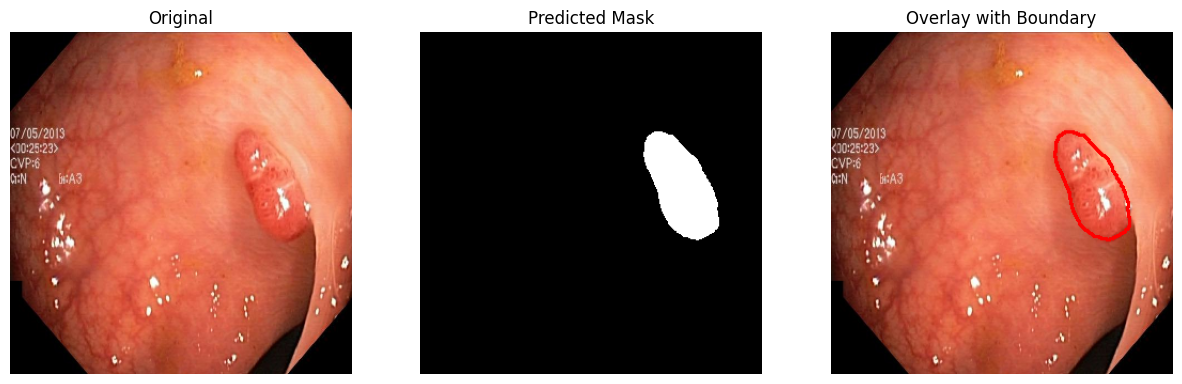

In [49]:
import matplotlib.pyplot as plt
import cv2

# Reload the original image for visualization (not normalized)
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
orig_img = cv2.resize(orig_img, (320, 320))

# Get mask as numpy array
mask_np = mask_pred.squeeze().cpu().numpy().astype(np.uint8)  # shape [H, W], values 0 or 1

# Find contours (boundaries) in the mask
contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
overlay = orig_img.copy()
cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue boundary

# Show results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay with Boundary")
plt.imshow(overlay)
plt.axis("off")

plt.show()

## DINOV@-UNET


Loading DINOv2 from torch.hub ...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Trainable params: 26,527,037


Train:   0%|          | 0/100 [00:00<?, ?it/s]

DINO output shape: torch.Size([8, 384])


Train:   0%|          | 0/100 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 250.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 100.19 MiB is free. Process 7311 has 14.64 GiB memory in use. Of the allocated memory 13.78 GiB is allocated by PyTorch, and 752.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [102]:
from transformers import AutoModel, AutoImageProcessor

token = "HF_TOKEN_REDACTED"

dino_path = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(dino_path, use_auth_token=token)
dino = AutoModel.from_pretrained(dino_path, use_auth_token=token).to(device)


In [99]:
# train_dinov2_unet.py
import os
import math
import json
import random
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Huggingface
from transformers import AutoModel, AutoImageProcessor

# ---------------------------
# Basic utils & dataset
# ---------------------------
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

class ImgDataset(Dataset):
    def __init__(self, img_paths, mask_paths=None, train=True, sz=720):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.train = train
        self.sz = sz

        if train:
            self.tfms = T.Compose([
                T.RandomHorizontalFlip(0.5),
                T.RandomVerticalFlip(0.5),
                T.RandomRotation(90),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
            ])
        else:
            self.tfms = None

    def __len__(self):
        return len(self.img_paths)

    def load_mask(self, path):
        if path is None:
            return None
        if not os.path.exists(path):
            return None
        mask = np.load(path)
        if mask.ndim == 3:
            mask = mask.max(axis=0)
        return (mask > 0).astype(np.uint8)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((self.sz, self.sz), Image.LANCZOS)
        img_np = np.array(img).astype(np.float32) / 255.0  # H,W,3

        if self.mask_paths:
            mask_path = self.mask_paths[idx]
            mask = self.load_mask(mask_path)
            if mask is None:
                mask = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)
            mask = cv2.resize(mask, (self.sz, self.sz), interpolation=cv2.INTER_NEAREST)

            img_t = torch.from_numpy(img_np).permute(2,0,1)  # C,H,W
            mask_t = torch.from_numpy(mask).unsqueeze(0).float()  # 1,H,W

            if self.train and self.tfms is not None:
                # apply same random transforms to both
                seed = np.random.randint(2147483647)
                torch.manual_seed(seed)
                img_t = self.tfms(img_t)
                torch.manual_seed(seed)
                mask_t = self.tfms(mask_t)

            return img_t, mask_t
        else:
            img_t = torch.from_numpy(img_np).permute(2,0,1)
            return img_t, str(img_path)

# ---------------------------
# UNet decoder blocks (ConvBlock)
# ---------------------------
class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch // r, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // r, ch, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, use_se=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        self.se = SEBlock(out_ch) if use_se else nn.Identity()

    def forward(self, x):
        return self.se(self.conv(x))

# ---------------------------
# Hybrid model: frozen DINOv2 encoder + UNet decoder
# ---------------------------
class DINOv2UNet(nn.Module):
    def __init__(self, dino_path, n_classes=1, img_size=720, device='cuda'):
        super().__init__()
        self.device = device
        self.img_size = img_size

        # load processor & model
        print("Loading DINOv2 from:", dino_path)
        # self.processor = AutoImageProcessor.from_pretrained(dino_path, local_files_only=True, use_fast=False)
        # self.dino = AutoModel.from_pretrained(dino_path, local_files_only=True).to(self.device)
        self.processor = AutoImageProcessor.from_pretrained(dino_path)
        self.dino = AutoModel.from_pretrained(dino_path).to(self.device)


        # freeze dino
        for p in self.dino.parameters():
            p.requires_grad = False
        self.dino.eval()

        dino_dim = getattr(self.dino.config, "hidden_size", None)
        if dino_dim is None:
            raise ValueError("Cannot infer hidden_size from DINO model config.")

        # projection heads: project token map -> desired channels for decoder
        self.dino_proj = nn.Sequential(
            nn.Conv2d(dino_dim, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        # project the larger map to smaller skip channels
        self.dino_proj_e3 = nn.Sequential(nn.Conv2d(512, 256, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.dino_proj_e2 = nn.Sequential(nn.Conv2d(512, 128, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.dino_proj_e1 = nn.Sequential(nn.Conv2d(512, 64, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))

        self.drop = nn.Dropout2d(0.1)
        bottleneck_in = 512
        self.bottleneck = ConvBlock(bottleneck_in, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ConvBlock(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ConvBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ConvBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ConvBlock(128, 64)

        self.final = nn.Conv2d(64, n_classes, 1)

        # move trainable parts to device
        self.to(self.device)

    def forward_features_dino(self, x):
        # x: [B, C, H, W] in [0,1] float32 on self.device
        # Convert to PIL Images for processor (more reliable than numpy arrays)
        from PIL import Image
        
        # Convert tensor to list of PIL Images
        imgs = []
        for img_tensor in x:
            # Convert to numpy and scale to 0-255
            img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            # Convert to PIL Image
            img_pil = Image.fromarray(img_np)
            imgs.append(img_pil)
        
        inputs = self.processor(images=imgs, return_tensors="pt").to(self.device)
        with torch.no_grad():
            out = self.dino(**inputs).last_hidden_state  # [B, N, C]
        B, N, C = out.shape
        tokens = out[:, 1:, :]  # remove CLS
        s = int(math.sqrt(N - 1))
        fmap = tokens.permute(0, 2, 1).reshape(B, C, s, s)  # [B,C,s,s]
        return fmap  # on self.device

    def forward(self, x):
        # x on device
        dino_feats = self.forward_features_dino(x)  # [B, dino_dim, s, s]
        # project to e4
        e4 = self.dino_proj(dino_feats)  # [B,512,s,s]
        # desired target sizes for typical UNet with patch=16: e4 ~ img/16, e3~img/4, e2~img/2, e1~img
        target_e4 = x.shape[2] // 16
        e4 = F.interpolate(e4, size=(target_e4, target_e4), mode='bilinear', align_corners=False)

        e3_interp = F.interpolate(e4, size=(x.shape[2]//4, x.shape[3]//4), mode='bilinear', align_corners=False)
        e3 = self.dino_proj_e3(e3_interp)

        e2_interp = F.interpolate(e4, size=(x.shape[2]//2, x.shape[3]//2), mode='bilinear', align_corners=False)
        e2 = self.dino_proj_e2(e2_interp)

        e1_interp = F.interpolate(e4, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        e1 = self.dino_proj_e1(e1_interp)

        b = self.bottleneck(self.drop(e4))

        d4 = self.up4(b)
        if d4.shape[2:] != e4.shape[2:]:
            e4 = F.interpolate(e4, size=d4.shape[2:], mode='bilinear', align_corners=False)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        if d3.shape[2:] != e3.shape[2:]:
            e3 = F.interpolate(e3, size=d3.shape[2:], mode='bilinear', align_corners=False)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        if d2.shape[2:] != e2.shape[2:]:
            e2 = F.interpolate(e2, size=d2.shape[2:], mode='bilinear', align_corners=False)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        if d1.shape[2:] != e1.shape[2:]:
            e1 = F.interpolate(e1, size=d1.shape[2:], mode='bilinear', align_corners=False)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return torch.sigmoid(out)

# ---------------------------
# Losses & training utilities
# ---------------------------
def dice_loss(pred, target, smooth=1e-6):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return 1 - (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def bce_dice_loss(pred, target):
    bce = F.binary_cross_entropy(pred, target)
    dice = dice_loss(pred, target)
    return bce + dice

def train_epoch(model, loader, optimizer, device):
    model.train()
    running = 0.0
    for imgs, masks in tqdm(loader, desc="Train"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = bce_dice_loss(preds, masks)
        loss.backward()
        optimizer.step()
        running += loss.item()
    return running / len(loader)

def val_epoch(model, loader, device):
    model.eval()
    running = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val"):
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            loss = bce_dice_loss(preds, masks)
            running += loss.item()
    return running / len(loader)

# ---------------------------
# MAIN - configure paths & loaders
# ---------------------------
if __name__ == "__main__":
    # Edit these to your paths
    BASE_PATH = '/kaggle/input/recodai-luc-scientific-image-forgery-detection'
    # TRAIN_IMG_DIR = Path(BASE_PATH) / 'train_images'
    # TRAIN_MASK_DIR = Path(BASE_PATH) / 'train_masks'
    # SUPP_IMG_DIR = Path(BASE_PATH) / 'supplemental_images'
    # SUPP_MASK_DIR = Path(BASE_PATH) / 'supplemental_masks'

    DINO_PATH = dino_path  # change to your local DINOv2 path
    #dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)
    # dino.eval()  # freeze
    # for p in dino.parameters():
    #     p.requires_grad = False

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # collect image and mask paths
    # train_imgs = sorted(list(TRAIN_IMG_DIR.glob('*.png')))
    # train_mask_paths = []
    # train_img_paths_filtered = []
    # for p in train_imgs:
    #     mask_p = TRAIN_MASK_DIR / f"{p.stem}.npy"
    #     if mask_p.exists():
    #         train_img_paths_filtered.append(p)
    #         train_mask_paths.append(mask_p)

    # print(f"Found {len(train_img_paths_filtered)} train images with masks")

    # split train/val
    # idxs = np.arange(len(train_img_paths_filtered))
    # np.random.shuffle(idxs)
    # split = int(0.9 * len(idxs))
    # train_idx, val_idx = idxs[:split], idxs[split:]

    # train_imgs_final = [train_img_paths_filtered[i] for i in train_idx]
    # train_masks_final = [train_mask_paths[i] for i in train_idx]
    # val_imgs_final = [train_img_paths_filtered[i] for i in val_idx]
    # val_masks_final = [train_mask_paths[i] for i in val_idx]

    # dataset & loader
    BATCH = 2
    IMG_SIZE = 224
    # train_ds = ImgDataset(train_imgs_final, train_masks_final, train=True, sz=IMG_SIZE)
    # val_ds = ImgDataset(val_imgs_final, val_masks_final, train=False, sz=IMG_SIZE)

    # train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
    # val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

    # model
    model = DINOv2UNet(dino_path=DINO_PATH, n_classes=1, img_size=IMG_SIZE, device=device).to(device)
    # ensure DINO parameters are frozen
    for n, p in model.named_parameters():
        if 'dino' in n:
            p.requires_grad = False

    # optim only params that require grad
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr=2e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

    best_val = 1e9
    epochs = 20
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = val_epoch(model, val_loader, device)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} — Train: {train_loss:.4f} — Val: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), "best_dinov2_unet.pth")
            print("Saved best_dinov2_unet.pth")


Loading DINOv2 from: facebook/dinov2-small


Val: 100%|██████████| 25/25 [00:05<00:00,  4.29it/s]


Epoch 1/20 — Train: 1.0805 — Val: 0.9624
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]


Epoch 2/20 — Train: 0.9153 — Val: 0.8340
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]


Epoch 3/20 — Train: 0.8044 — Val: 0.8205
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 4/20 — Train: 0.7253 — Val: 0.6977
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 5/20 — Train: 0.6750 — Val: 0.6818
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 6/20 — Train: 0.6304 — Val: 0.5938
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 7/20 — Train: 0.5240 — Val: 0.4902
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]


Epoch 8/20 — Train: 0.4367 — Val: 0.4275
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]


Epoch 9/20 — Train: 0.3716 — Val: 0.3577
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 10/20 — Train: 0.3257 — Val: 0.3590


Val: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 11/20 — Train: 0.3020 — Val: 0.3160
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 12/20 — Train: 0.2694 — Val: 0.3120
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 13/20 — Train: 0.2487 — Val: 0.2966
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.26it/s]


Epoch 14/20 — Train: 0.2384 — Val: 0.2989


Val: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 15/20 — Train: 0.2369 — Val: 0.3023


Val: 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 16/20 — Train: 0.2721 — Val: 0.2943
Saved best_dinov2_unet.pth


Val: 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]


Epoch 17/20 — Train: 0.2563 — Val: 0.2979


Val: 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 18/20 — Train: 0.2523 — Val: 0.3283


Val: 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


Epoch 19/20 — Train: 0.2364 — Val: 0.2954


Val: 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]


Epoch 20/20 — Train: 0.2145 — Val: 0.2757
Saved best_dinov2_unet.pth


In [98]:
import torch
import gc

# Clear GPU memory before anything else
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    gc.collect()

# Set memory allocation strategy
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

Loading DINOv2 from: facebook/dinov2-small


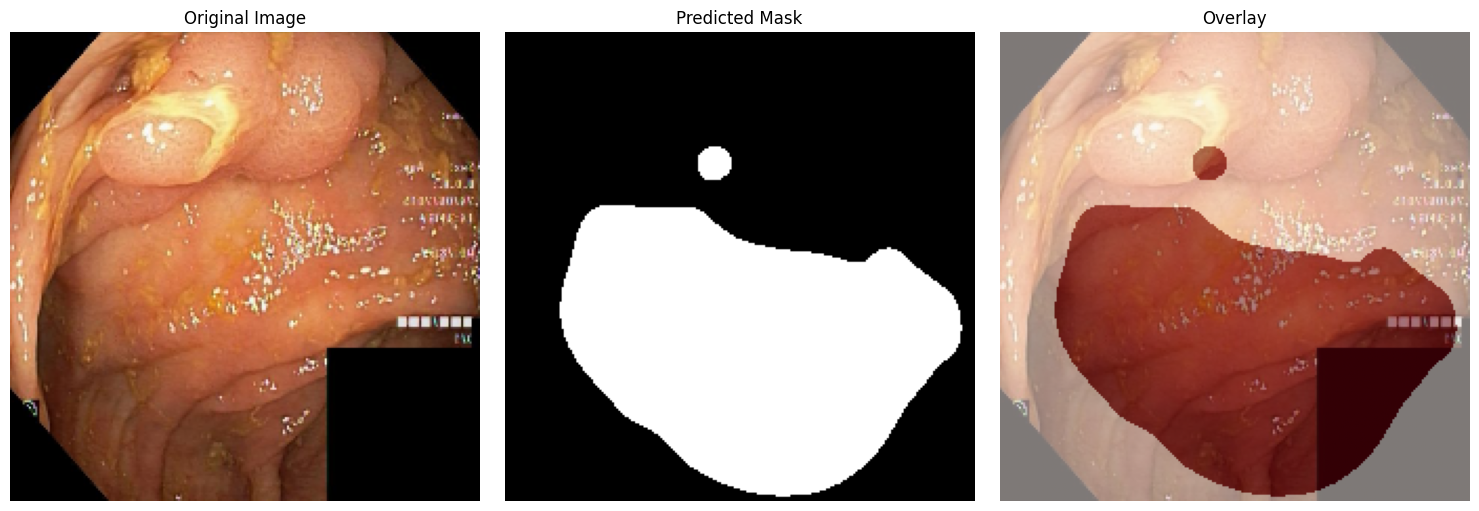

In [118]:
import torch, torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2
# --------- copy the network definition from your train file ---------
#from train_dinov2_unet import DINOv2UNet   # or wherever you put the class
# --------------------------------------------------------------------

# =====================  USER SETTINGS  =====================
CKPT_PATH   = "/kaggle/working/best_dinov2_unet.pth"      # your saved weights
#DINO_NAME   = "facebook/dinov2-small"     # or local DINO folder
IMG_SIZE    = 224                         # must match training
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
# ===========================================================

# 1. build model and load weights
model = DINOv2UNet(dino_path=DINO_PATH, n_classes=1,
                   img_size=IMG_SIZE, device=DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval().to(DEVICE)

# 2. preprocessing
prep = T.Compose([
        T.Resize((IMG_SIZE, IMG_SIZE), interpolation=T.InterpolationMode.LANCZOS),
        T.ToTensor()          # -> 0-1 float32, C,H,W
      ])

# 3. single-image inference helper
@torch.no_grad()
def predict_one(image, threshold=0.5):
    """
    image : PIL Image, np.uint8 HWC, or path (str/Path)
    returns: np.uint8 binary mask, original resolution
    """
    if isinstance(image, (str, Path)):
        image = Image.open(image).convert('RGB')
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    W, H = image.size
    x = prep(image).unsqueeze(0).to(DEVICE)        # 1,3,224,224
    prob = model(x)                                # 1,1,224,224
    prob = torch.nn.functional.interpolate(
            prob, size=(H, W), mode='bilinear', align_corners=False)
    mask = (prob.squeeze().cpu().numpy() > threshold).astype(np.uint8)*255
    return mask

# ------------------- usage example -------------------
if __name__ == "__main__":
    mask = predict_one("/kaggle/working/transformed_output/images/0d944153-a3c5-4d55-be3f-5543d64b5023.png")   # or pass PIL / numpy array
    cv2.imwrite("my_picture_mask.png", mask)


import matplotlib.pyplot as plt

def visualize_prediction(image_path, predicted_mask, save_path=None):
    """Visualize original image and predicted mask side by side"""
    # Load original image
    img = Image.open(image_path)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img)
    axes[2].imshow(predicted_mask, alpha=0.5, cmap='Reds')
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Usage with visualization
predicted_mask = mask
visualize_prediction(test_image, predicted_mask, "prediction_result.png")

In [109]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T

def load_model_for_inference(model_path, dino_path, device='cuda'):
    """Load the trained model for inference"""
    model = DINOv2UNet(dino_path=dino_path, n_classes=1, img_size=512, device=device)
    
    # Load trained weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Ensure DINO is still frozen
    for p in model.parameters():
        p.requires_grad = False
    
    return model

def predict_single_image(model, image_path, device='cuda', threshold=0.5):
    """Predict mask for a single image"""
    model.eval()
    
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    
    # Resize to model input size
    transform = T.Compose([
        T.Resize((512, 512)),  # Match your IMG_SIZE
        T.ToTensor(),
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred_mask = model(img_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        
        # Apply threshold
        pred_mask = (pred_mask > threshold).float()
    
    # Resize back to original size if needed
    pred_mask = F.interpolate(pred_mask, size=img.size[::-1], mode='bilinear', align_corners=False)
    
    return pred_mask.squeeze().cpu().numpy()

def predict_batch(model, image_paths, device='cuda', batch_size=4):
    """Predict masks for multiple images"""
    model.eval()
    results = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        
        # Load batch of images
        batch_tensors = []
        for path in batch_paths:
            img = Image.open(path).convert('RGB')
            transform = T.Compose([
                T.Resize((512, 512)),
                T.ToTensor(),
            ])
            batch_tensors.append(transform(img))
        
        batch_tensor = torch.stack(batch_tensors).to(device)
        
        # Predict
        with torch.no_grad():
            pred_masks = model(batch_tensor)
            pred_masks = torch.sigmoid(pred_masks)
        
        # Process each prediction
        for j, pred_mask in enumerate(pred_masks):
            results.append(pred_mask.squeeze().cpu().numpy())
    
    return results

# Usage Example
if __name__ == "__main__":
    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #dino_path = "/kaggle/input/dinov2small/transformers/default/1/model (2).safetensors"
    model_path = "/kaggle/working/best_dinov2_unet.pth"  # Your trained model
    
    # Load model
    model = load_model_for_inference(model_path, dino_path, device)
    
    # Single image prediction
    test_image = "/kaggle/working/transformed_output/images/01e6cfd7-bdb6-4929-9fc0-9a7dd2d3c7f7.png"
    predicted_mask = predict_single_image(model, test_image, device)
    
    # Save result
    result_img = (predicted_mask * 255).astype(np.uint8)
    Image.fromarray(result_img).save("predicted_mask.png")
    
    print(f"Prediction complete! Mask shape: {predicted_mask.shape}")

Loading DINOv2 from: facebook/dinov2-small
Prediction complete! Mask shape: (224, 224)


## With visualtion 

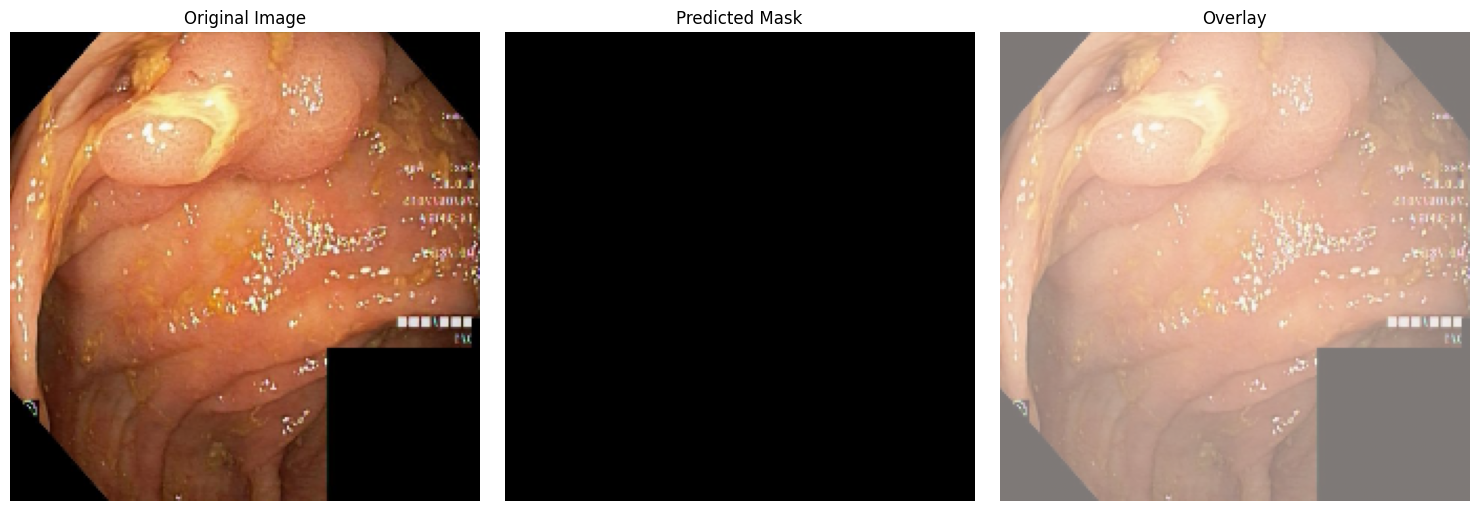

In [110]:
import matplotlib.pyplot as plt

def visualize_prediction(image_path, predicted_mask, save_path=None):
    """Visualize original image and predicted mask side by side"""
    # Load original image
    img = Image.open(image_path)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img)
    axes[2].imshow(predicted_mask, alpha=0.5, cmap='Reds')
    axes[2].set_title('Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Usage with visualization
predicted_mask = predict_single_image(model, test_image, device)
visualize_prediction(test_image, predicted_mask, "prediction_result.png")

## Mae 

In [1]:
git clone https://github.com/facebookresearch/mae.git
cd mae
pip install -r requirements.txt


SyntaxError: invalid syntax (4178006917.py, line 1)

linear prob dino v2

In [3]:
import os
os.environ["HYPER_KVASIR_LABELED_ROOT"] = "/kaggle/working/hyper-kvasir-labeled-images/labeled-images"

In [4]:
import os
import csv
from pathlib import Path
from typing import List, Tuple, Dict

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image

# ---- Hyper-Kvasir paths (edit or keep) ----
# This folder must contain: image-labels.csv, lower-gi-tract/, upper-gi-tract/
DATA_ROOT = Path(os.environ.get(
    "HYPER_KVASIR_LABELED_ROOT",
    "~/sharedscratch/datasets/hyper-kvasir/labeled-images/labeled-images",
)).expanduser()

CSV_PATH = DATA_ROOT / "image-labels.csv"

IMAGE_SIZE = 256
NUM_WORKERS = 4


def get_train_transform(image_size: int):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])


def get_valid_transform(image_size: int):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])


def _organ_to_dir(organ: str) -> str:
    o = organ.strip().lower()
    if "lower" in o:
        return "lower-gi-tract"
    if "upper" in o:
        return "upper-gi-tract"
    raise ValueError(f"Unknown Organ value in CSV: {organ!r}")


def _find_image_path(root: Path, organ: str, classification: str, finding: str, stem: str) -> Path:
    """
    CSV has an id like '000e3fee-...'. Images are stored under:
    root/<tract>/<classification>/<finding>/<stem>.jpg
    """
    tract_dir = _organ_to_dir(organ)
    base = root / tract_dir / classification / finding

    # Most images are .jpg, but be tolerant.
    jpg = base / f"{stem}.jpg"
    if jpg.exists():
        return jpg
    jpeg = base / f"{stem}.jpeg"
    if jpeg.exists():
        return jpeg
    png = base / f"{stem}.png"
    if png.exists():
        return png

    # Last resort: glob any extension (slower, but robust)
    hits = list(base.glob(f"{stem}.*"))
    if hits:
        return hits[0]

    raise FileNotFoundError(f"Image not found for id={stem} under {base}")


def _read_index_from_csv(root: Path, csv_path: Path) -> Tuple[List[Path], List[str]]:
    paths: List[Path] = []
    findings: List[str] = []

    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        # Expected columns: Video file, Organ, Finding, Classification
        for row in reader:
            stem = row.get("Video file") or row.get("Video_file") or row.get("video file")
            organ = row["Organ"]
            finding = row["Finding"]
            classification = row["Classification"]

            if stem is None:
                raise KeyError(f"Could not find 'Video file' column in CSV. Columns: {reader.fieldnames}")

            p = _find_image_path(root, organ, classification, finding, stem.strip())
            paths.append(p)
            findings.append(finding.strip())

    return paths, findings


class HyperKvasirFindingDataset(Dataset):
    """
    Single-task dataset: y = Finding (23-way).
    """
    def __init__(self, root: Path, csv_path: Path, transform=None):
        self.root = Path(root)
        self.csv_path = Path(csv_path)
        self.transform = transform

        self.paths, self.finding_str = _read_index_from_csv(self.root, self.csv_path)

        self.classes = sorted(set(self.finding_str))
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.y = [self.class_to_idx[s] for s in self.finding_str]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx: int):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y[idx]


def _stratified_split_indices(y: List[int], val_frac: float, seed: int = 42):
    g = torch.Generator().manual_seed(seed)
    y_t = torch.tensor(y, dtype=torch.long)

    train_idx = []
    val_idx = []

    for cls in torch.unique(y_t).tolist():
        idx = torch.where(y_t == cls)[0]
        idx = idx[torch.randperm(idx.numel(), generator=g)]
        n_val = max(1, int(round(idx.numel() * val_frac))) if idx.numel() > 1 else 0

        val_idx.append(idx[:n_val])
        train_idx.append(idx[n_val:])

    train_idx = torch.cat(train_idx).tolist()
    val_idx = torch.cat(val_idx).tolist()

    # Shuffle final lists
    train_idx = torch.tensor(train_idx)[torch.randperm(len(train_idx), generator=g)].tolist()
    val_idx = torch.tensor(val_idx)[torch.randperm(len(val_idx), generator=g)].tolist()
    return train_idx, val_idx


def get_datasets(val_frac: float = 0.1, seed: int = 42):
    """
    Returns: train_subset, val_subset, class_names
    """
    full_train = HyperKvasirFindingDataset(DATA_ROOT, CSV_PATH, transform=get_train_transform(IMAGE_SIZE))
    full_valid = HyperKvasirFindingDataset(DATA_ROOT, CSV_PATH, transform=get_valid_transform(IMAGE_SIZE))

    train_idx, val_idx = _stratified_split_indices(full_train.y, val_frac=val_frac, seed=seed)

    train_ds = Subset(full_train, train_idx)
    val_ds = Subset(full_valid, val_idx)
    return train_ds, val_ds, full_train.classes


def get_data_loaders(dataset_train, dataset_valid, batch_size: int):
    train_loader = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return train_loader, valid_loader

In [4]:
%%bash
set -euo pipefail

ROOT="/kaggle/working/hyper-kvasir-labeled-images/labeled-images"
OUT="/kaggle/working/hk23_flat"

mkdir -p "$OUT"

# Leaf class folders: ROOT/<tract>/<classification>/<finding>
find "$ROOT" -mindepth 3 -maxdepth 3 -type d | while read -r d; do
  cls="$(basename "$d")"
  mkdir -p "$OUT/$cls"

  find "$d" -maxdepth 1 -type f \( -iname "*.jpg" -o -iname "*.jpeg" -o -iname "*.png" \) -print0 \
    | while IFS= read -r -d '' f; do
        base="$(basename "$f")"
        prefix="$(echo "$d" | sed 's#/#_#g')"
        ln -sf "$f" "$OUT/$cls/${prefix}_${base}"
      done
done

echo "Created: $OUT"
ls "$OUT" | head

Created: /kaggle/working/hk23_flat
barretts
barretts-short-segment
bbps-0-1
bbps-2-3
cecum
dyed-lifted-polyps
dyed-resection-margins
esophagitis-a
esophagitis-b-d
hemorrhoids


In [10]:
import os

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Required constants.
# Kaggle: you created the flat folder here.
DATA_DIR = os.environ.get("HK_FLAT_ROOT", "/kaggle/working/hk23_flat")

IMAGE_SIZE = 256  # Image size of resize when applying transforms.
NUM_WORKERS = 4   # Number of parallel processes for data preparation.
VAL_FRAC = 0.1
TEST_FRAC = 0.1
SEED = 42

# Training transforms
def get_train_transform(image_size):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_test_transform(image_size):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


# Validation transforms
def get_valid_transform(image_size):
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

def get_datasets(val_frac: float = VAL_FRAC, test_frac: float = TEST_FRAC, seed: int = SEED):
    """
    Prepare datasets from a single ImageFolder root + random split.
    Returns train dataset, valid dataset, and class names.
    """
    # Two dataset instances so train/val can use different transforms.
    full_train = datasets.ImageFolder(
        DATA_DIR,
        transform=get_train_transform(IMAGE_SIZE)
    )
    full_valid = datasets.ImageFolder(
        DATA_DIR,
        transform=get_valid_transform(IMAGE_SIZE)
    )
    full_test = datasets.ImageFolder(
        DATA_DIR,
        transform=get_test_transform(IMAGE_SIZE)
    )

    n = len(full_train)
    n_test = int(n * test_frac)
    n_val = int(n * val_frac)
    n_train = n - n_val - n_test

    g = torch.Generator().manual_seed(seed)
    train_subset, val_subset, test_subset = random_split(full_train, [n_train, n_val, n_test], generator=g)

    # Swap the underlying dataset for validation subset to use valid transforms.
    val_subset.dataset = full_valid
    test_subset.dataset = full_test

    return train_subset, val_subset,test_subset, full_train.classes

def get_data_loaders(dataset_train, dataset_valid,dataset_test, batch_size):
    """
    Prepares the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
    test_loader = DataLoader(
        dataset_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader,test_loader

model.py

In [11]:
import torch

from collections import OrderedDict

def build_model(num_classes=23, fine_tune=False):
    backobone_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

    model = torch.nn.Sequential(OrderedDict([
        ('backbone', backobone_model),
        ('head', torch.nn.Linear(
            in_features=384, out_features=num_classes, bias=True
        ))
    ]))
    
    if not fine_tune:
        for params in model.backbone.parameters():
            params.requires_grad = False

    return model

if __name__ == '__main__':
    model = build_model()
    print(model)
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

# import torch

# def build_model(num_classes=10, fine_tune=False):
#     model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_lc')

#     if not fine_tune:
#         for params in model.backbone.parameters():
#             params.requires_grad = False

#     model.linear_head = torch.nn.Linear(
#         in_features=1920, out_features=num_classes, bias=True
#     )
#     return model

# if __name__ == '__main__':
#     model = build_model()
#     print(model)
#     # Total parameters and trainable parameters.
#     total_params = sum(p.numel() for p in model.parameters())
#     print(f"{total_params:,} total parameters.")
#     total_trainable_params = sum(
#         p.numel() for p in model.parameters() if p.requires_grad)
#     print(f"{total_trainable_params:,} training parameters.")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Sequential(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): LayerScale()
        (drop_path2): Iden

utils.py

In [12]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.style.use('ggplot')

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, epoch, model, out_dir, name
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'backbone_state_dict': model.backbone.state_dict(),
                'head_state_dict': model.head.state_dict(),
                }, os.path.join(out_dir, 'best_'+name+'.pth'))

def save_model(epochs, model, optimizer, criterion, out_dir, name):
    """
    Function to save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'backbone_state_dict': model.backbone.state_dict(),
                'head_state_dict': model.head.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, os.path.join(out_dir, name+'.pth'))

def save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='tab:blue', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='tab:red', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'accuracy.png'))
    
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='tab:blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='tab:red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(out_dir, 'loss.png'))

Train.py

In [ ]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import os

from tqdm.auto import tqdm
# from model import build_model
# from datasets import get_datasets, get_data_loaders
# from utils import save_model, save_plots, SaveBestModel
from torch.optim.lr_scheduler import MultiStepLR

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Construct the argument parser.
parser = argparse.ArgumentParser()
parser.add_argument(
    '-e', '--epochs', 
    type=int, 
    default=10,
    help='Number of epochs to train our network for'
)
parser.add_argument(
    '-lr', '--learning-rate', 
    type=float,
    dest='learning_rate', 
    default=0.001,
    help='Learning rate for training the model'
)
parser.add_argument(
    '-b', '--batch-size',
    dest='batch_size',
    default=32,
    type=int
)
parser.add_argument(
    '--save-name',
    dest='save_name',
    default='model',
    help='file name of the final model to save'
)
parser.add_argument(
    '--fine-tune',
    dest='fine_tune',
    action='store_true',
    help='whether to fine-tune the model or train the classifier layer only'
)
parser.add_argument(
    '--out-dir',
    dest='out_dir',
    default='results',
    help='output sub-directory path inside the `outputs` directory'
)
parser.add_argument(
    '--scheduler',
    type=int,
    nargs='+',
    default=[1000],
    help='number of epochs after which learning rate scheduler is applied'
)
args = parser.parse_args([
    "-lr", "0.0001",
    "-e", "20",
    "-b", "32",
    "--out-dir", "fine_tuning",
    "--fine-tune",
    "--scheduler", "10", "15",
])
print(args)

# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

if __name__ == '__main__':
    # Create a directory with the model name for outputs.
    out_dir = os.path.join('..', 'outputs', args.out_dir)
    os.makedirs(out_dir, exist_ok=True)
    # Load the training and validation datasets.
    dataset_train, dataset_valid, dataset_classes = get_datasets()
    print(f"[INFO]: Number of training images: {len(dataset_train)}")
    print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
    print(f"[INFO]: Classes: {dataset_classes}")
    # Load the training and validation data loaders.
    train_loader, valid_loader = get_data_loaders(
        dataset_train, dataset_valid, batch_size=args.batch_size
    )

    # Learning_parameters. 
    lr = args.learning_rate
    epochs = args.epochs
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Computation device: {device}")
    print(f"Learning rate: {lr}")
    print(f"Epochs to train for: {epochs}\n")

    # Load the model.
    model = build_model(
        num_classes=len(dataset_classes), fine_tune=args.fine_tune
    ).to(device)
    print(model)
    
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

    # Optimizer.
    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, nesterov=True
    )
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    # Loss function.
    criterion = nn.CrossEntropyLoss()

    # Initialize `SaveBestModel` class.
    save_best_model = SaveBestModel()

    # Scheduler.
    scheduler = MultiStepLR(optimizer, milestones=args.scheduler, gamma=0.1)

    # Lists to keep track of losses and accuracies.
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    # Start the training.
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                    criterion, dataset_classes)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        save_best_model(
            valid_epoch_loss, epoch, model, out_dir, args.save_name
        )
        print('-'*50)
        scheduler.step()
        last_lr = scheduler.get_last_lr()
        print(f"LR for next epoch: {last_lr}")

    # Save the trained model weights.
    save_model(epochs, model, optimizer, criterion, out_dir, args.save_name)
    # Save the loss and accuracy plots.
    save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir)
    print('TRAINING COMPLETE')

In [24]:
!pwd


/kaggle/working


In [25]:
!cd ..

In [13]:
!ls

hk23_flat			 hyper-kvasir-segmented-images
hyper-kvasir-labeled-images	 hyper-kvasir-segmented-images.zip
hyper-kvasir-labeled-images.zip


In [14]:
import os
print("cwd:", os.getcwd())

cwd: /kaggle/working


In [134]:
!pwd
!ls -la
!ls -la ..
!find /kaggle -maxdepth 3 -type d -name outputs 2>/dev/null

/kaggle/working
total 4292264
drwxr-xr-x  7 root root       4096 Jan 21 20:54 .
drwxr-xr-x  6 root root       4096 Jan 21 20:58 ..
-rw-r--r--  1 root root  196220040 Jan 21 20:09 best_dinov2_unet.pth
-rw-r--r--  1 root root     148132 Jan 21 16:46 detected_output.png
drwxr-xr-x 25 root root       4096 Jan 21 20:55 hk23_flat
drwxr-xr-x  3 root root       4096 Jan 21 20:52 hyper-kvasir-labeled-images
-rw-r--r--  1 root root 3928814344 Aug 10  2020 hyper-kvasir-labeled-images.zip
drwxr-xr-x  3 root root       4096 Jan 21 16:40 hyper-kvasir-segmented-images
-rw-r--r--  1 root root   21287892 Jan 21 17:21 hyper-kvasir-segmented-images.zip
-rw-r--r--  1 root root       1065 Jan 21 20:25 my_picture_mask.png
-rw-r--r--  1 root root        325 Jan 21 20:17 predicted_mask.png
-rw-r--r--  1 root root     270951 Jan 21 20:25 prediction_result.png
drwxr-xr-x  4 root root       4096 Jan 21 17:23 transformed_output
-rw-r--r--  1 root root  124238631 Jan 21 18:06 unet_baseline_best.pth
-rw-r--r--  1 r

In [135]:
!ls -ლა /kaggle/outputs
!find /kaggle/outputs -maxdepth 2 -type f | head

ls: invalid option -- '�'
Try 'ls --help' for more information.
/kaggle/outputs/transfer_learning/loss.png
/kaggle/outputs/transfer_learning/best_model.pth
/kaggle/outputs/transfer_learning/model.pth
/kaggle/outputs/transfer_learning/accuracy.png


In [15]:
!cp /kaggle/outputs/transfer_learning/best_model.pth /kaggle/working/Transfer_learned_final.pth
!cp /kaggle/outputs/transfer_learning/model.pth /kaggle/working/model.pth

In [16]:
!cp /kaggle/outputs/fine_tuning/loss.png /kaggle/working/loss.png
!cp /kaggle/outputs/fine_tuning/accuracy.png /kaggle/working/accuracy.png

cp: cannot stat '/kaggle/outputs/fine_tuning/loss.png': No such file or directory
cp: cannot stat '/kaggle/outputs/fine_tuning/accuracy.png': No such file or directory


## Inference 

In [37]:
import os
import glob
import pathlib

import torch
import numpy as np
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#from model import build_model  # make sure model.py is available in the notebook environment

# --------- SET THESE ---------
WEIGHTS = "/kaggle/outputs/fine_tuning/best_model.pth"
FLAT_ROOT = "/kaggle/working/hk23_flat"          # used to get class order
INPUT_DIR = "/kaggle/working/inference_data"     # put test images here
OUT_DIR = "/kaggle/working/inference_results"
# -----------------------------

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_RESIZE = 224

def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def annotate_image(label: str, orig_bgr):
    cv2.putText(
        orig_bgr,
        label,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return orig_bgr

@torch.no_grad()
def predict_one(model, x):
    logits = model(x.to(DEVICE))
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()
    pred = int(np.argmax(probs))
    return pred, float(probs[pred])

# 1) Class names MUST match training ImageFolder order
CLASS_NAMES = ImageFolder(FLAT_ROOT).classes
print("Num classes:", len(CLASS_NAMES))

# 2) Load model
ckpt = torch.load(pathlib.Path(WEIGHTS), map_location="cpu")
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

model = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()

# 3) Collect images
os.makedirs(OUT_DIR, exist_ok=True)
image_paths = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    image_paths.extend(glob.glob(os.path.join(INPUT_DIR, ext)))

if not image_paths:
    raise FileNotFoundError(f"No images found in {INPUT_DIR}. Put some .jpg/.png there.")

transform = get_test_transform(IMAGE_RESIZE)

# 4) Run inference + save annotated images
for i, p in enumerate(sorted(image_paths)):
    bgr = cv2.imread(p)
    if bgr is None:
        print("Skipping unreadable:", p)
        continue

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = transform(rgb).unsqueeze(0)

    pred, conf = predict_one(model, x)
    label = f"{CLASS_NAMES[pred]} ({conf:.2f})"

    out_img = annotate_image(label, bgr.copy())
    out_path = os.path.join(OUT_DIR, os.path.basename(p))
    cv2.imwrite(out_path, out_img)

    print(f"[{i+1}/{len(image_paths)}] {os.path.basename(p)} -> {label}")

print("Saved to:", OUT_DIR)

Num classes: 23


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


FileNotFoundError: No images found in /kaggle/working/inference_data. Put some .jpg/.png there.

single image

In [43]:
import os
import pathlib

import torch
import numpy as np
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#from model import build_model

# ---- paths ----
WEIGHTS = "/kaggle/outputs/fine_tuning/best_model.pth"
IMAGE_PATH = "/kaggle/input/d1234q/barretts.jpg"
FLAT_ROOT = "/kaggle/working/hk23_flat"  # must match training class order
OUT_PATH = "/kaggle/working/inference_single.jpg"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_RESIZE = 224

def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def annotate_image(text: str, orig_bgr):
    cv2.putText(
        orig_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return orig_bgr

# 1) class names (same order as training ImageFolder)
CLASS_NAMES = ImageFolder(FLAT_ROOT).classes
print("Num classes:", len(CLASS_NAMES))

# 2) load weights (supports dict checkpoint or raw state_dict)
ckpt = torch.load(pathlib.Path(WEIGHTS), map_location="cpu")
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# before load_state_dict
m1 = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
w_before = m1.head.weight.detach().cpu().clone()

m1.load_state_dict(state_dict)
w_after = m1.head.weight.detach().cpu().clone()

print("Head changed:", not torch.allclose(w_before, w_after))

model = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()

# 3) read image + preprocess
bgr = cv2.imread(IMAGE_PATH)
if bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMAGE_PATH}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
x = get_test_transform(IMAGE_RESIZE)(rgb).unsqueeze(0).to(DEVICE)

# 4) predict
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()

pred_idx = int(np.argmax(probs))
pred_name = CLASS_NAMES[pred_idx]
pred_conf = float(probs[pred_idx])

print("Prediction:", pred_name, "confidence:", round(pred_conf, 4))

# 5) save annotated image to /kaggle/working
out = annotate_image(f"{pred_name} ({pred_conf:.2f})", bgr.copy())
cv2.imwrite(OUT_PATH, out)
print("Saved annotated image to:", OUT_PATH)

Num classes: 23


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Head changed: True


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Prediction: z-line confidence: 0.3577
Saved annotated image to: /kaggle/working/inference_single.jpg


In [ ]:
python train.py -lr 0.0005 --epochs 20 --batch 32 --out-dir transfer_learning --scheduler 10


## Transfer Learning

Namespace(epochs=20, learning_rate=0.0005, batch_size=32, save_name='model', fine_tune=False, out_dir='transfer_learning', scheduler=[10])
[INFO]: Number of training images: 8530
[INFO]: Number of validation images: 1066
[INFO]: Number of test images: 1066
[INFO]: Classes: ['barretts', 'barretts-short-segment', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'hemorrhoids', 'ileum', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-2', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-3', 'z-line']
Computation device: cuda
Learning rate: 0.0005
Epochs to train for: 20



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Sequential(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): LayerScale()
        (drop_path2): Iden

  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 1.230, training acc: 64.572
Validation loss: 0.682, validation acc: 80.019

Best validation loss: 0.6823607656885596

Saving best model for epoch: 1

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.710, training acc: 78.124
Validation loss: 0.586, validation acc: 82.176

Best validation loss: 0.586088305887054

Saving best model for epoch: 2

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 80.375
Validation loss: 0.520, validation acc: 84.522

Best validation loss: 0.5195030285155072

Saving best model for epoch: 3

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.584, training acc: 81.336
Validation loss: 0.500, validation acc: 84.615

Best validation loss: 0.49997977255021825

Saving best model for epoch: 4

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.559, training acc: 81.559
Validation loss: 0.480, validation acc: 85.178

Best validation loss: 0.48034615113454704

Saving best model for epoch: 5

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.523, training acc: 82.626
Validation loss: 0.460, validation acc: 86.116

Best validation loss: 0.46045904299792123

Saving best model for epoch: 6

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.495, training acc: 83.962
Validation loss: 0.444, validation acc: 85.835

Best validation loss: 0.4437980160993688

Saving best model for epoch: 7

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.495, training acc: 83.623
Validation loss: 0.440, validation acc: 86.867

Best validation loss: 0.4398307397085078

Saving best model for epoch: 8

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.482, training acc: 84.232
Validation loss: 0.429, validation acc: 86.585

Best validation loss: 0.42939220412689094

Saving best model for epoch: 9

--------------------------------------------------
LR for next epoch: [0.0005]
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.476, training acc: 83.834
Validation loss: 0.422, validation acc: 86.585

Best validation loss: 0.4218457341194153

Saving best model for epoch: 10

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.447, training acc: 85.205
Validation loss: 0.414, validation acc: 87.523

Best validation loss: 0.41403916653464823

Saving best model for epoch: 11

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.457, training acc: 85.064
Validation loss: 0.414, validation acc: 87.148

Best validation loss: 0.4139784052968025

Saving best model for epoch: 12

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.451, training acc: 85.147
Validation loss: 0.413, validation acc: 87.617

Best validation loss: 0.41291948714677024

Saving best model for epoch: 13

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.451, training acc: 85.076
Validation loss: 0.413, validation acc: 87.242
--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.456, training acc: 84.959
Validation loss: 0.413, validation acc: 87.336

Best validation loss: 0.4126214525278877

Saving best model for epoch: 15

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.458, training acc: 84.736
Validation loss: 0.412, validation acc: 87.430

Best validation loss: 0.4115161492544062

Saving best model for epoch: 16

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.444, training acc: 85.404
Validation loss: 0.410, validation acc: 87.617

Best validation loss: 0.41047168303938475

Saving best model for epoch: 17

--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.444, training acc: 85.287
Validation loss: 0.411, validation acc: 87.336
--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.445, training acc: 85.510
Validation loss: 0.411, validation acc: 86.867
--------------------------------------------------
LR for next epoch: [5e-05]
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/267 [00:00<?, ?it/s]

Validation


  0%|          | 0/34 [00:00<?, ?it/s]

Training loss: 0.448, training acc: 85.510
Validation loss: 0.411, validation acc: 87.523
--------------------------------------------------
LR for next epoch: [5e-05]
TRAINING COMPLETE


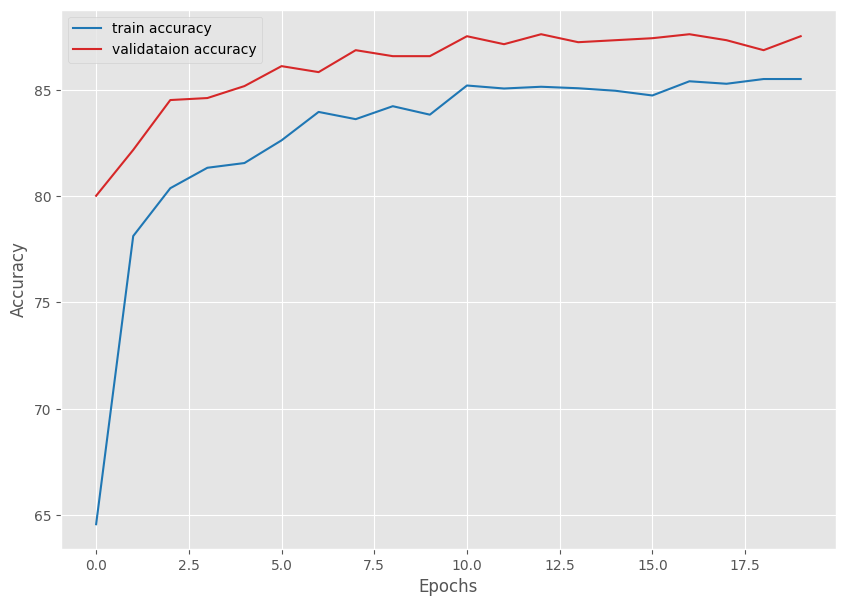

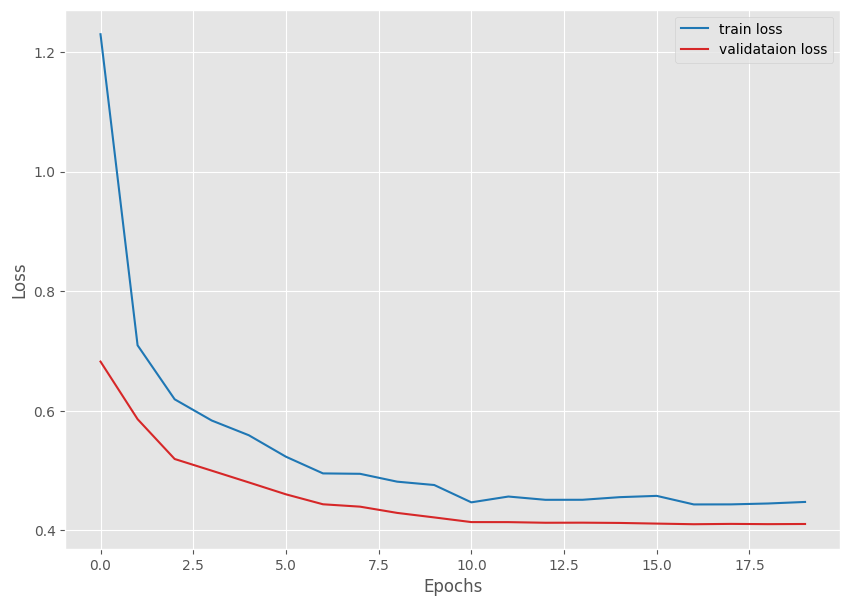

In [13]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import os

from tqdm.auto import tqdm
# from model import build_model
# from datasets import get_datasets, get_data_loaders
# from utils import save_model, save_plots, SaveBestModel
from torch.optim.lr_scheduler import MultiStepLR

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Construct the argument parser.
parser = argparse.ArgumentParser()
parser.add_argument(
    '-e', '--epochs', 
    type=int, 
    default=10,
    help='Number of epochs to train our network for'
)
parser.add_argument(
    '-lr', '--learning-rate', 
    type=float,
    dest='learning_rate', 
    default=0.001,
    help='Learning rate for training the model'
)
parser.add_argument(
    '-b', '--batch-size',
    dest='batch_size',
    default=32,
    type=int
)
parser.add_argument(
    '--save-name',
    dest='save_name',
    default='model',
    help='file name of the final model to save'
)
parser.add_argument(
    '--fine-tune',
    dest='fine_tune',
    action='store_true',
    help='whether to fine-tune the model or train the classifier layer only'
)
parser.add_argument(
    '--out-dir',
    dest='out_dir',
    default='results',
    help='output sub-directory path inside the `outputs` directory'
)
parser.add_argument(
    '--scheduler',
    type=int,
    nargs='+',
    default=[1000],
    help='number of epochs after which learning rate scheduler is applied'
)
args = parser.parse_args([
    "-lr", "0.0005",
    "-e", "20",
    "-b", "32",
    "--out-dir", "transfer_learning",
    "--scheduler", "10", 
])
print(args)

# Training function.
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation.
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# Validation function.
def validate(model, testloader, criterion, class_names):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

@torch.no_grad()
def test(model, testloader, criterion):
    model.eval()
    print('Testing')

    test_running_loss = 0.0
    test_running_correct = 0
    counter = 0

    for image, labels in tqdm(testloader):
        counter += 1
        image = image.to(device)
        labels = labels.to(device)

        outputs = model(image)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        test_running_correct += (preds == labels).sum().item()

    epoch_loss = test_running_loss / counter
    epoch_acc = 100. * (test_running_correct / len(testloader.dataset))

    return epoch_loss, epoch_acc


if __name__ == '__main__':
    # Create a directory with the model name for outputs.
    out_dir = os.path.join('..', 'outputs', args.out_dir)
    os.makedirs(out_dir, exist_ok=True)
    # Load the training and validation datasets.
    dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets()

    print(f"[INFO]: Number of training images: {len(dataset_train)}")
    print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
    print(f"[INFO]: Number of test images: {len(dataset_test)}")
    print(f"[INFO]: Classes: {dataset_classes}")
    
    train_loader, valid_loader, test_loader = get_data_loaders(
        dataset_train,
        dataset_valid,
        dataset_test,
        batch_size=args.batch_size
    )


    # Learning_parameters. 
    lr = args.learning_rate
    epochs = args.epochs
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Computation device: {device}")
    print(f"Learning rate: {lr}")
    print(f"Epochs to train for: {epochs}\n")

    # Load the model.
    model = build_model(
        num_classes=len(dataset_classes), fine_tune=args.fine_tune
    ).to(device)
    print(model)
    
    # Total parameters and trainable parameters.
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

    # Optimizer.
    optimizer = optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, nesterov=True
    )
    # optimizer = optim.Adam(model.parameters(), lr=lr)
    # Loss function.
    criterion = nn.CrossEntropyLoss()

    # Initialize `SaveBestModel` class.
    save_best_model = SaveBestModel()

    # Scheduler.
    scheduler = MultiStepLR(optimizer, milestones=args.scheduler, gamma=0.1)

    # Lists to keep track of losses and accuracies.
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    # Start the training.
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                    criterion, dataset_classes)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        save_best_model(
            valid_epoch_loss, epoch, model, out_dir, args.save_name
        )
        print('-'*50)
        scheduler.step()
        last_lr = scheduler.get_last_lr()
        print(f"LR for next epoch: {last_lr}")

    # Save the trained model weights.
    save_model(epochs, model, optimizer, criterion, out_dir, args.save_name)
    # Save the loss and accuracy plots.
    save_plots(train_acc, valid_acc, train_loss, valid_loss, out_dir)
    print('TRAINING COMPLETE')

In [17]:
!cp /kaggle/outputs/transfer_learning/loss.png /kaggle/working/loss.png
!cp /kaggle/outputs/transfer_learning/accuracy.png /kaggle/working/accuracy.png

In [24]:
!ls -ლა /kaggle/outputs
!find /kaggle/outputs -maxdepth 2 -type f | head

ls: invalid option -- '�'
Try 'ls --help' for more information.
/kaggle/outputs/transfer_learning/loss.png
/kaggle/outputs/transfer_learning/best_model.pth
/kaggle/outputs/transfer_learning/model.pth
/kaggle/outputs/transfer_learning/accuracy.png


In [18]:
best_model_path = os.path.join(out_dir, 'best_' + args.save_name + '.pth')

checkpoint = torch.load(best_model_path, map_location=device)
model.backbone.load_state_dict(checkpoint['backbone_state_dict'])
model.head.load_state_dict(checkpoint['head_state_dict'])
model.to(device)

print(f"[INFO]: Loaded best model from epoch {checkpoint['epoch']}")


[INFO]: Loaded best model from epoch 17


In [19]:
test_loss, test_acc = test(model, test_loader, criterion)

print(f"[TEST] Loss: {test_loss:.4f}")
print(f"[TEST] Accuracy: {test_acc:.2f}%")


Testing


  0%|          | 0/34 [00:00<?, ?it/s]

[TEST] Loss: 0.4230
[TEST] Accuracy: 86.02%


In [25]:
import torch
import numpy as np

@torch.no_grad()
def collect_predictions(model, dataloader, device):
    model.eval()

    all_logits = []
    all_labels = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        all_logits.append(outputs.cpu())
        all_labels.append(labels.cpu())

    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)

    return logits, labels


In [27]:
def topk_accuracy(logits, labels, ks=(1, 5)):
    max_k = max(ks)
    _, preds = logits.topk(max_k, dim=1)
    preds = preds.t()

    correct = preds.eq(labels.view(1, -1))
    results = {}

    for k in ks:
        correct_k = correct[:k].any(dim=0).float().sum()
        results[f"top_{k}"] = (correct_k / labels.size(0)).item() * 100

    return results


In [28]:
from sklearn.metrics import precision_recall_fscore_support

def classification_metrics(logits, labels):
    preds = torch.argmax(logits, dim=1).numpy()
    labels = labels.numpy()

    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro"
    )

    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    return {
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
    }


In [29]:
def per_class_accuracy(logits, labels, class_names):
    preds = torch.argmax(logits, dim=1)
    results = {}

    for idx, name in enumerate(class_names):
        mask = labels == idx
        if mask.sum() == 0:
            acc = float("nan")
        else:
            acc = (preds[mask] == labels[mask]).float().mean().item() * 100
        results[name] = acc

    return results


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

def save_confusion_matrix(
    logits, labels, class_names, out_dir
):
    preds = torch.argmax(logits, dim=1).numpy()
    labels = labels.numpy()

    cm = confusion_matrix(labels, preds, normalize="true")

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        xticklabels=class_names,
        yticklabels=class_names,
        cmap="Blues",
        annot=False
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix")
    plt.tight_layout()

    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, "confusion_matrix.png"))
    plt.close()


In [31]:
def expected_calibration_error(logits, labels, n_bins=15):
    probs = torch.softmax(logits, dim=1)
    confidences, predictions = probs.max(dim=1)
    accuracies = predictions.eq(labels)

    ece = torch.zeros(1)
    bins = torch.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
        if mask.sum() > 0:
            acc = accuracies[mask].float().mean()
            conf = confidences[mask].mean()
            ece += (mask.float().mean()) * torch.abs(acc - conf)

    return ece.item()


In [32]:
from sklearn.neighbors import KNeighborsClassifier

@torch.no_grad()
def knn_evaluate(backbone, dataloader, device, k=20):
    backbone.eval()

    features = []
    labels = []

    for images, targets in dataloader:
        images = images.to(device)
        feats = backbone(images)
        features.append(feats.cpu())
        labels.append(targets)

    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()

    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(features, labels)

    acc = knn.score(features, labels)
    return acc * 100


In [33]:
logits, labels = collect_predictions(model, test_loader, device)

# Core
topk = topk_accuracy(logits, labels)
metrics = classification_metrics(logits, labels)
per_class = per_class_accuracy(logits, labels, dataset_classes)
ece = expected_calibration_error(logits, labels)

# Save confusion matrix
save_confusion_matrix(
    logits,
    labels,
    dataset_classes,
    out_dir
)

print("Top-K:", topk)
print("Metrics:", metrics)
print("ECE:", ece)
print("Per-class accuracy:", per_class)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Top-K: {'top_1': 86.02251410484314, 'top_5': 98.78048896789551}
Metrics: {'precision_macro': 0.5679846623326767, 'recall_macro': 0.5625447094056357, 'f1_macro': 0.5622427681813924, 'precision_weighted': 0.8410759931151109, 'recall_weighted': 0.8602251407129456, 'f1_weighted': 0.8485328415963861}
ECE: 0.03271079063415527
Per-class accuracy: {'barretts': 0.0, 'barretts-short-segment': 0.0, 'bbps-0-1': 95.99999785423279, 'bbps-2-3': 97.22222089767456, 'cecum': 98.96907210350037, 'dyed-lifted-polyps': 90.625, 'dyed-resection-margins': 93.1034505367279, 'esophagitis-a': 40.425533056259155, 'esophagitis-b-d': 50.0, 'hemorrhoids': 0.0, 'ileum': nan, 'impacted-stool': 69.2307710647583, 'polyps': 93.06930899620056, 'pylorus': 98.90109896659851, 'retroflex-rectum': 89.74359035491943, 'retroflex-stomach': 98.70129823684692, 'ulcerative-colitis-grade-0-1': 0.0, 'ulcerative-colitis-grade-1': 23.999999463558197, 'ulcerative-colitis-grade-1-2': 0.0, 'ulcerative-colitis-grade-2': 71.42857313156128, 'u

Testing done up

In [20]:
import torchvision
from torchvision.utils import save_image

@torch.no_grad()
def save_test_images(
    model,
    test_loader,
    class_names,
    out_dir,
    max_images=50
):
    model.eval()
    save_dir = os.path.join(out_dir, "test_images")
    os.makedirs(save_dir, exist_ok=True)

    count = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if count >= max_images:
                return

            img = images[i].cpu()
            pred = class_names[preds[i].item()]
            gt = class_names[labels[i].item()]

            filename = f"{count:04d}_pred_{pred}_gt_{gt}.png"
            save_image(
                img,
                os.path.join(save_dir, filename),
                normalize=True
            )
            count += 1


In [21]:
save_test_images(
    model,
    test_loader,
    dataset_classes,
    out_dir,
    max_images=50
)


## Transfer learnign inference test

Build Multi Task Model ("cls","det","seg")

In [18]:
class MultiHeadModel(nn.Module):
    def __init__(self, backbone, num_classes=10, fine_tune=False):
        super().__init__()
        self.backbone = backbone
        self.cls_head = nn.Linear(384, num_classes)
        if not fine_tune:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x, task="cls"):
        features = self.backbone(x)  # get pooled embedding
        if task == "cls":
            return self.cls_head(features)
        # task="det" can be implemented later


In [ ]:
import os
import pathlib

import torch
import numpy as np
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#from model import build_model

# ---- paths ----
WEIGHTS = "/kaggle/working/best_model.pth"
IMAGE_PATH = "/kaggle/input/d1234q/barretts.jpg"
FLAT_ROOT = "/kaggle/working/hk23_flat"  # must match training class order
OUT_PATH = "/kaggle/working/inference_single.jpg"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_RESIZE = 224

def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def annotate_image(text: str, orig_bgr):
    cv2.putText(
        orig_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return orig_bgr



# checkpoint = torch.load("best_model.pth", map_location=device)

# model.backbone.load_state_dict(checkpoint['backbone_state_dict'])
# model.head.load_state_dict(checkpoint['head_state_dict'])

# Optional: load optimizer
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']



multi_model = MultiHeadModel(backbone=torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14'),
                             num_classes=23, fine_tune=False)

# Load trained classification weights
checkpoint = torch.load("best_model.pth", map_location=device)
multi_model.cls_head.load_state_dict(checkpoint['head_state_dict'])
multi_model.backbone.load_state_dict(checkpoint['backbone_state_dict'])

multi_model.eval()  # ready for inference


# 1) class names (same order as training ImageFolder)
CLASS_NAMES = ImageFolder(FLAT_ROOT).classes
print("Num classes:", len(CLASS_NAMES))

# 2) load weights (supports dict checkpoint or raw state_dict)
# ckpt = torch.load(pathlib.Path(WEIGHTS), map_location=device)
# state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# before load_state_dict
m1 = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
w_before = m1.head.weight.detach().cpu().clone()

m1.load_state_dict(state_dict)
w_after = m1.head.weight.detach().cpu().clone()

print("Head changed:", not torch.allclose(w_before, w_after))

model = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
model.load_state_dict(state_dict)
# model.eval()

multi_model.eval()

# 3) read image + preprocess
bgr = cv2.imread(IMAGE_PATH)
if bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMAGE_PATH}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
x = get_test_transform(IMAGE_RESIZE)(rgb).unsqueeze(0).to(DEVICE)

# 4) predict
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()

pred_idx = int(np.argmax(probs))
pred_name = CLASS_NAMES[pred_idx]
pred_conf = float(probs[pred_idx])

print("Prediction:", pred_name, "confidence:", round(pred_conf, 4))

# 5) save annotated image to /kaggle/working
out = annotate_image(f"{pred_name} ({pred_conf:.2f})", bgr.copy())
cv2.imwrite(OUT_PATH, out)
print("Saved annotated image to:", OUT_PATH)

In [151]:
# corrected_inference.py
import os
import pathlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import transforms
from torchvision.datasets import ImageFolder

# ---- User config (edit these paths) ----
WEIGHTS = "/kaggle/working/Transfer_learned_final.pth"       # single pth containing backbone_state_dict + head_state_dict
IMAGE_PATH = "/kaggle/working/hk23_flat/ileum/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_anatomical-landmarks_ileum_aaf8bbb9-4e74-43b9-ac8b-3f1720022678.jpg" # image to run inference on
FLAT_ROOT = "/kaggle/working/hk23_flat"          # folder used during training (ImageFolder order)
OUT_PATH = "/kaggle/working/inference_single.jpg" 
IMAGE_RESIZE = 224

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ---- Helpers ----
def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def annotate_image(text: str, orig_bgr):
    cv2.putText(
        orig_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return orig_bgr

# ---- MultiHeadModel and builder ----
class MultiHeadModel(nn.Module):
    """
    Minimal multi-head wrapper: shared backbone + classification head.
    Designed to load backbone+head checkpoints (backbone_state_dict + head_state_dict).
    The backbone is expected to output either:
      - pooled features (B, C) OR
      - patch tokens (B, N, C) -- in that case we pool tokens for classification automatically.
    """
    def __init__(self, backbone: nn.Module, num_classes: int = 10, fine_tune: bool = False):
        super().__init__()
        self.backbone = backbone
        self.cls_head = nn.Linear(384, num_classes)  # DINOv2 vits14 -> 384 dim
        if not fine_tune:
            for p in self.backbone.parameters():
                p.requires_grad = False

    def forward(self, x, task="cls"):
        """
        task: "cls" for classification (default). Future tasks (e.g., 'det') can be added.
        """
        # call backbone
        features = self.backbone(x)
        # backbone may return (B, C) or (B, N, C). Normalize both cases to (B, C)
        if isinstance(features, (list, tuple)):
            # some backbones may return (tokens, extra) or similar; pick first tensor
            features = features[0]
        if features.dim() == 3:
            # tokens: (B, N, C) -> pool over N
            pooled = features.mean(dim=1)
        elif features.dim() == 2:
            pooled = features
        else:
            raise ValueError(f"Unexpected backbone output ndim={features.dim()}")

        if task == "cls":
            logits = self.cls_head(pooled)
            return logits
        else:
            raise NotImplementedError("Only classification task is implemented in this wrapper.")

    @classmethod
    def from_checkpoint(cls, ckpt_path: str, num_classes: int, fine_tune: bool=False, device: torch.device = torch.device('cpu')):
        """
        Factory to build MultiHeadModel directly from a checkpoint file (avoids double-loading).
        The checkpoint must contain keys: 'backbone_state_dict' and 'head_state_dict'.
        """
        # 1) initialize backbone architecture WITHOUT loading pretrained weights from hub to avoid double download
        #    set pretrained=False so we don't fetch weights automatically
        backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=False)
        model = cls(backbone=backbone, num_classes=num_classes, fine_tune=fine_tune).to(device)

        # 2) load checkpoint dict and populate weights/kaggle/working/hk23_flat/esophagitis-a/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_upper-gi-tract_pathological-findings_esophagitis-a_06b9ff0c-31e1-4b56-8bcc-604b9ecea637.jpg
        ckpt = torch.load(ckpt_path, map_location=device)
        # ckpt might be a dict that directly contains 'backbone_state_dict' or 'model_state_dict' style
        if 'backbone_state_dict' in ckpt and 'head_state_dict' in ckpt:
            backbone_sd = ckpt['backbone_state_dict']
            head_sd = ckpt['head_state_dict']
        elif 'model_state_dict' in ckpt:
            # this case for older format where model_state_dict is the full model; try to map keys
            msd = ckpt['model_state_dict']
            # attempt to find keys for head/backbone by heuristic
            backbone_sd = {k.replace('backbone.', ''): v for k, v in msd.items() if k.startswith('backbone.')}
            head_sd = {k.replace('head.', ''): v for k, v in msd.items() if k.startswith('head.')}
        else:
            raise KeyError("Checkpoint format not recognized. Expected keys 'backbone_state_dict' and 'head_state_dict'")

        model.backbone.load_state_dict(backbone_sd, strict=False)
        model.cls_head.load_state_dict(head_sd, strict=True)
        return model

# ---- Inference script ----
if __name__ == "__main__":
    # 1) class names (must match training ImageFolder order)
    if not os.path.isdir(FLAT_ROOT):
        raise FileNotFoundError(f"Training class folder not found: {FLAT_ROOT}")
    CLASS_NAMES = ImageFolder(FLAT_ROOT).classes
    print("Classe name : ",CLASS_NAMES )
    print("Num classes:", len(CLASS_NAMES))

    # 2) load multihead from checkpoint (this avoids loading DINO twice)
    if not os.path.isfile(WEIGHTS):
        raise FileNotFoundError(f"Weights file not found: {WEIGHTS}")
    multi_model = MultiHeadModel.from_checkpoint(WEIGHTS, num_classes=len(CLASS_NAMES), fine_tune=False, device=DEVICE)
    multi_model.eval()

    # 3) read image + preprocess
    bgr = cv2.imread(IMAGE_PATH)
    if bgr is None:
        raise FileNotFoundError(f"Could not read image: {IMAGE_PATH}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    transform = get_test_transform(IMAGE_RESIZE)
    x = transform(rgb).unsqueeze(0).to(DEVICE)  # (1,3,H,W)

    # 4) predict
    with torch.no_grad():
        logits = multi_model(x, task="cls")
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = int(np.argmax(probs))
    pred_name = CLASS_NAMES[pred_idx]
    pred_conf = float(probs[pred_idx])
    print("Prediction:", pred_name, "confidence:", round(pred_conf, 4))

    # 5) annotate and save
    out = annotate_image(f"{pred_name} ({pred_conf:.2f})", bgr.copy())
    os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
    cv2.imwrite(OUT_PATH, out)
    print("Saved annotated image to:", OUT_PATH)


Classe name :  ['barretts', 'barretts-short-segment', 'bbps-0-1', 'bbps-2-3', 'cecum', 'dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis-a', 'esophagitis-b-d', 'hemorrhoids', 'ileum', 'impacted-stool', 'polyps', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'ulcerative-colitis-grade-0-1', 'ulcerative-colitis-grade-1', 'ulcerative-colitis-grade-1-2', 'ulcerative-colitis-grade-2', 'ulcerative-colitis-grade-2-3', 'ulcerative-colitis-grade-3', 'z-line']
Num classes: 23


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Prediction: ulcerative-colitis-grade-2 confidence: 0.7024
Saved annotated image to: /kaggle/working/inference_single.jpg


## testing clean inferecne 

In [154]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import transforms

# ---------------- CONFIG ----------------
WEIGHTS = "/kaggle/working/Transfer_learned_final.pth"
IMAGE_PATH = "/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_0004a718-546c-41c2-9c69-c4685093a039.jpg"
OUT_PATH = "/kaggle/working/inference_single.jpg"
IMAGE_SIZE = 224

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_NAMES = [
    'barretts',
    'barretts-short-segment',
    'bbps-0-1',
    'bbps-2-3',
    'cecum',
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis-a',
    'esophagitis-b-d',
    'hemorrhoids',
    'ileum',
    'impacted-stool',
    'polyps',
    'pylorus',
    'retroflex-rectum',
    'retroflex-stomach',
    'ulcerative-colitis-grade-0-1',
    'ulcerative-colitis-grade-1',
    'ulcerative-colitis-grade-1-2',
    'ulcerative-colitis-grade-2',
    'ulcerative-colitis-grade-2-3',
    'ulcerative-colitis-grade-3',
    'z-line'
]

# ---------------- TRANSFORM ----------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ---------------- MODEL ----------------
class DinoClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torch.hub.load(
            "facebookresearch/dinov2",
            "dinov2_vits14",
            pretrained=False
        )
        self.head = nn.Linear(384, num_classes)

        for p in self.backbone.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.backbone(x)

        if isinstance(out, dict):
            if "x_norm_clstoken" in out:
                feat = out["x_norm_clstoken"]
            elif "x_norm_patchtokens" in out:
                feat = out["x_norm_patchtokens"].mean(dim=1)
            else:
                raise RuntimeError("Unknown DINOv2 output format")
        elif out.dim() == 3:
            feat = out.mean(dim=1)
        elif out.dim() == 2:
            feat = out
        else:
            raise RuntimeError(f"Unexpected output shape: {out.shape}")

        return self.head(feat)

    @classmethod
    def load_from_checkpoint(cls, ckpt_path, num_classes):
        model = cls(num_classes)
        ckpt = torch.load(ckpt_path, map_location="cpu")

        model.backbone.load_state_dict(
            ckpt["backbone_state_dict"], strict=False
        )
        model.head.load_state_dict(
            ckpt["head_state_dict"], strict=True
        )
        return model

# ---------------- INFERENCE ----------------
if __name__ == "__main__":
    model = DinoClassifier.load_from_checkpoint(
        WEIGHTS, num_classes=len(CLASS_NAMES)
    ).to(DEVICE)
    model.eval()

    bgr = cv2.imread(IMAGE_PATH)
    if bgr is None:
        raise FileNotFoundError(IMAGE_PATH)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = transform(rgb).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    idx = int(np.argmax(probs))
    label = CLASS_NAMES[idx]
    conf = float(probs[idx])

    print(f"Prediction: {label} ({conf:.4f})")

    cv2.putText(
        bgr,
        f"{label} ({conf:.2f})",
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

    os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
    cv2.imwrite(OUT_PATH, bgr)
    print("Saved:", OUT_PATH)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Prediction: polyps (0.9884)
Saved: /kaggle/working/inference_single.jpg


## Detection head 

In [10]:
# Data loader for fastr cnn format expects (image_tensor, target_dict)

import json
import os
import torch

def load_hyperkvasir(json_path, images_dir, label_map={"polyp": 1}):
    """
    Load your JSON dataset.

    Args:
        json_path: path to bounding.json
        images_dir: folder with images
        label_map: map string labels to integers (1-based, 0 is background)
    
    Returns:
        image_paths: list of full image paths
        annotations: list of dicts with 'boxes' and 'labels'
        num_categories: number of object classes
    """
    with open(json_path, "r") as f:
        data = json.load(f)
    
    image_paths = []
    annotations = []
    
    for fname, ann_info in data.items():
        # full path: adjust if your images have .jpg/.png extensions
        img_path_jpg = os.path.join(images_dir, fname + ".jpg")
        img_path_png = os.path.join(images_dir, fname + ".png")
        if os.path.exists(img_path_jpg):
            img_path = img_path_jpg
        elif os.path.exists(img_path_png):
            img_path = img_path_png
        else:
            print(f"Image not found: {fname}")
            continue
        image_paths.append(img_path)

        boxes = []
        labels = []
        for box in ann_info.get("bbox", []):
            boxes.append([box["xmin"], box["ymin"], box["xmax"], box["ymax"]])
            labels.append(label_map.get(box["label"], 1))  # default to 1 if label unknown

        annotations.append({
            "boxes": boxes if boxes else [],
            "labels": labels if labels else []
        })

    num_categories = len(label_map)
    return image_paths, annotations, num_categories


In [16]:
import torchvision.transforms as T
from PIL import Image


PATCH_SIZE = 14

def get_transform(image_size: int):
    # Round up to nearest multiple of PATCH_SIZE
    if image_size % PATCH_SIZE != 0:
        image_size = ((image_size // PATCH_SIZE) + 1) * PATCH_SIZE

    return T.Compose([
        # T.ToPILImage(),  # REMOVED - dataset already provides PIL Image
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])

In [19]:
# detection_train.py

import os
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform


# ---------- CONFIG ----------
IMAGES_DIR = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images"
JSON_PATH = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/bounding-boxes.json"

image_paths_train, annotations_train, ncats = load_hyperkvasir(JSON_PATH, IMAGES_DIR, label_map={"polyp":1})
print(f"Loaded {len(image_paths_train)} images with {ncats} categories.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS_CLS = "/kaggle/input/transfer-dinov2/pytorch/default/1/tranfer_learning.pth"   # contains backbone_state_dict
NUM_DET_CLASSES = ncats + 1
print("NUM_DET_CLASSES set to", NUM_DET_CLASSES)           # 1 class (lesion) + background -> set to 2
BATCH_SIZE = 2
LR_HEAD = 1e-4
LR_BACKBONE = 1e-5
EPOCHS = 30
IMAGE_SIZE =  224  #994                              # use larger size for small objects
# ----------------------------




# ---------- Define Backbone Adapter ----------
class Dinov2BackboneAdapter(nn.Module):
    """
    Wraps a DINOv2 backbone. Expects the backbone to return patch tokens
    shape (B, N, C) or pooled (B,C). Converts to OrderedDict of feature maps
    with channel=256 and provides multi-scale outputs P2 (hp,w), P3 (hp/2,w/2).
    """
    def __init__(self, backbone, img_size=IMAGE_SIZE, patch_size=14, out_channels=256):
        super().__init__()
        self.backbone = backbone
        self.patch_size = patch_size
        self.img_size = img_size
        self._out_channels = out_channels

        # DINOv2 vits14 has embed_dim=384
        in_ch = getattr(backbone, 'embed_dim', 384)

        # 1x1 projection to desired channels
        self.proj = nn.Conv2d(in_ch, out_channels, kernel_size=1)

        # optionally add a small conv to refine
        self.refine = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # x: (B, 3, H, W)
        B, _, H, W = x.shape
        
        # Use get_intermediate_layers to get patch tokens (excludes CLS token)
        # Returns a tuple of tensors; we take the last layer
        intermediate = self.backbone.get_intermediate_layers(x, n=1, reshape=True)
        # intermediate is a tuple with one element: (B, C, h, w)
        feat_map = intermediate[0]  # shape: (B, C, H//patch_size, W//patch_size)
        
        C = feat_map.shape[1]
        
        # If in_ch inferred earlier was wrong, re-create proj
        if self.proj.in_channels != C:
            self.proj = nn.Conv2d(C, self._out_channels, kernel_size=1).to(feat_map.device)

        # project -> out_channels
        p2 = self.proj(feat_map)
        p2 = self.refine(p2)

        # build p3 (downsample by 2)
        p3 = nn.functional.interpolate(p2, scale_factor=0.5, mode='bilinear', align_corners=False)

        out = OrderedDict()
        out["0"] = p2
        out["1"] = p3
        return out

    @property
    def out_channels(self):
        return self._out_channels


# ---------- Dataset utilities ----------
# Provide a dataset class that returns image (Tensor) and target dict (boxes, labels)
# You can use torchvision.datasets.CocoDetection if you have COCO JSON; otherwise implement custom.
class SimpleDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, annotations, transforms=None, image_size=IMAGE_SIZE, min_box_size=2):
        """
        annotations: list of dicts per image: {'boxes': [[x1,y1,x2,y2], ...], 'labels':[...]}
        image_paths: list of full file paths
        transforms: torchvision transforms (expects PIL input)
        image_size: the size to which images will be resized (square)
        min_box_size: minimum width/height of box after scaling (in pixels)
        """
        self.image_paths = image_paths
        self.annotations = annotations
        self.transforms = transforms
        self.image_size = image_size
        self.min_box_size = min_box_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        import cv2
        # 1) load image as BGR and convert to RGB
        img_bgr = cv2.imread(self.image_paths[idx])
        if img_bgr is None:
            raise FileNotFoundError(f"Image not found: {self.image_paths[idx]}")
        img_rgb = img_bgr[:, :, ::-1].copy()  # H,W,C, uint8
        orig_h, orig_w = img_rgb.shape[:2]

        # 2) convert to PIL and apply transforms (Resize, ToTensor, Normalize)
        img_pil = Image.fromarray(img_rgb)
        if self.transforms:
            img_transformed = self.transforms(img_pil)   # tensor, normalized
            new_h, new_w = self.image_size, self.image_size
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            # fallback: convert to tensor without normalization and keep scale=1
            img_transformed = T.ToTensor()(img_rgb)
            scale_x = scale_y = 1.0

        # 3) prepare target (scale boxes to new image size)
        ann = self.annotations[idx]
        raw_boxes = ann.get('boxes', [])
        raw_labels = ann.get('labels', [])

        scaled_boxes = []
        valid_labels = []
        
        for b, label in zip(raw_boxes, raw_labels):
            x1 = b[0] * scale_x
            y1 = b[1] * scale_y
            x2 = b[2] * scale_x
            y2 = b[3] * scale_y
            
            # Clamp to image bounds
            x1 = max(0.0, min(x1, self.image_size - 1.0))
            y1 = max(0.0, min(y1, self.image_size - 1.0))
            x2 = max(0.0, min(x2, self.image_size))
            y2 = max(0.0, min(y2, self.image_size))
            
            # Check for valid box (positive width and height)
            width = x2 - x1
            height = y2 - y1
            
            # Skip degenerate boxes
            if width < self.min_box_size or height < self.min_box_size:
                continue
            
            scaled_boxes.append([x1, y1, x2, y2])
            valid_labels.append(label)
        
        # Handle case where all boxes were filtered out
        if len(scaled_boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(scaled_boxes, dtype=torch.float32)
            labels = torch.tensor(valid_labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.numel() else torch.tensor([]),
            "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64)
        }

        return img_transformed, target

def collate_fn(batch):
    return tuple(zip(*batch))





# ---------- Build the model ----------
def build_detection_model(backbone_adapter, image_size=IMAGE_SIZE):
    # anchor sizes/rates can be tuned

    image_size = (image_size // PATCH_SIZE) * PATCH_SIZE
    

    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128), (128, 256, 512)), aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0)))
    # RoI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1'], output_size=7, sampling_ratio=2)
    transform = GeneralizedRCNNTransform(
        min_size=image_size,
        max_size=image_size,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
        size_divisible=PATCH_SIZE,  # Critical: must match DINOv2 patch size
    )
    
    model = FasterRCNN(
        backbone_adapter, 
        num_classes=NUM_DET_CLASSES,
        rpn_anchor_generator=anchor_generator, 
        box_roi_pool=roi_pooler,
        min_size=image_size,
        max_size=image_size,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
    )
    
    # Override the transform with our custom one
    model.transform = transform
    return model

# ---------- Training loop ----------
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50):
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % print_freq == 0:
            print(f"Epoch[{epoch}] Iter[{i}/{len(data_loader)}] Loss: {losses.item():.4f}")

# ---------- Put it all together ----------
def main():
    # 1) load backbone architecture
    # instantiate backbone architecture WITHOUT pretrained hub weights to avoid double load
    backbone_arch = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=False)
    # load your trained backbone weights
    ckpt = torch.load(WEIGHTS_CLS, map_location='cpu')
    backbone_arch.load_state_dict(ckpt['backbone_state_dict'], strict=False)

    # 2) Create adapter
    adapter = Dinov2BackboneAdapter(backbone_arch, img_size=IMAGE_SIZE, patch_size=14, out_channels=256)
    adapter.to(DEVICE)

    # 3) Build detection model
    model = build_detection_model(adapter, image_size=IMAGE_SIZE)
    model.to(DEVICE)

    # 4) Freeze backbone parameters initially (adapter + detector heads train)
    for p in adapter.backbone.parameters():
        p.requires_grad = False
    # adapter.proj and refine should be trainable by default

    # 5) Prepare dataset (replace with your own loaders)
    # Example placeholder: image_paths, annotations = load_your_dataset()
    train_dataset = SimpleDetectionDataset(image_paths_train, annotations_train,transforms=get_transform(IMAGE_SIZE))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn, num_workers=2, pin_memory=True)
    #train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

    # 6) Optimizer with parameter groups: adapter+heads LR=LR_HEAD, backbone LR small if unfreeze
    params = []
    # trainable params (adapter + detection head)
    for name, p in model.named_parameters():
        if p.requires_grad:
            params.append(p)
    optimizer = optim.AdamW(params, lr=LR_HEAD, weight_decay=1e-4)

    # 7) Training loop
    for epoch in range(EPOCHS):
        # Optionally unfreeze last blocks after some epochs:
        if epoch == 5:
            # unfreeze last 2 blocks for fine-tuning
            for name, p in adapter.backbone.named_parameters():
                if "blocks.10" in name or "blocks.11" in name:
                    p.requires_grad = True
            
            # FIX: Use id() to compare tensors
            backbone_params = [p for n, p in adapter.backbone.named_parameters() if p.requires_grad]
            backbone_param_ids = {id(p) for p in backbone_params}
            other_params = [p for n, p in model.named_parameters() if p.requires_grad and id(p) not in backbone_param_ids]
            
            optimizer = optim.AdamW([
                {'params': other_params, 'lr': LR_HEAD},
                {'params': backbone_params, 'lr': LR_BACKBONE},
            ], weight_decay=1e-4)

        train_one_epoch(model, optimizer, train_loader, DEVICE, epoch)

        # Save checkpoint (you can adapt SaveBestModel class to detection)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        }, f'checkpoint_det_epoch_{epoch}.pth')

    # Save final model
    torch.save({
        'epoch': EPOCHS,
        'model_state_dict': model.state_dict(),
    }, 'fasterrcnn_dinov2_det_final.pth')

if __name__ == "__main__":
    main()


Loaded 1000 images with 1 categories.
NUM_DET_CLASSES set to 2


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Epoch[0] Iter[0/500] Loss: 1.4746
Epoch[0] Iter[50/500] Loss: 0.3110
Epoch[0] Iter[100/500] Loss: 0.2413
Epoch[0] Iter[150/500] Loss: 0.2077
Epoch[0] Iter[200/500] Loss: 0.1134
Epoch[0] Iter[250/500] Loss: 0.1735
Epoch[0] Iter[300/500] Loss: 0.3244
Epoch[0] Iter[350/500] Loss: 0.2678
Epoch[0] Iter[400/500] Loss: 0.2717
Epoch[0] Iter[450/500] Loss: 0.1573
Epoch[1] Iter[0/500] Loss: 0.2006
Epoch[1] Iter[50/500] Loss: 0.2960
Epoch[1] Iter[100/500] Loss: 0.1657
Epoch[1] Iter[150/500] Loss: 0.2045
Epoch[1] Iter[200/500] Loss: 0.1073
Epoch[1] Iter[250/500] Loss: 0.3036
Epoch[1] Iter[300/500] Loss: 0.1706
Epoch[1] Iter[350/500] Loss: 0.2078
Epoch[1] Iter[400/500] Loss: 0.2366
Epoch[1] Iter[450/500] Loss: 0.2055
Epoch[2] Iter[0/500] Loss: 0.1300
Epoch[2] Iter[50/500] Loss: 0.1626
Epoch[2] Iter[100/500] Loss: 0.2289
Epoch[2] Iter[150/500] Loss: 0.2103
Epoch[2] Iter[200/500] Loss: 0.1579
Epoch[2] Iter[250/500] Loss: 0.0909
Epoch[2] Iter[300/500] Loss: 0.2277
Epoch[2] Iter[350/500] Loss: 0.1423
E

### just swperating adoacter for inferencd

In [11]:
# detection_train.py

import os
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform



# ---------- CONFIG ----------
IMAGES_DIR = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images"
JSON_PATH = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/bounding-boxes.json"

image_paths_train, annotations_train, ncats = load_hyperkvasir(JSON_PATH, IMAGES_DIR, label_map={"polyp":1})
print(f"Loaded {len(image_paths_train)} images with {ncats} categories.")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS_CLS = "/kaggle/input/transfer-dinov2/pytorch/default/1/tranfer_learning.pth"   # contains backbone_state_dict
NUM_DET_CLASSES = ncats + 1
print("NUM_DET_CLASSES set to", NUM_DET_CLASSES)           # 1 class (lesion) + background -> set to 2
BATCH_SIZE = 2
LR_HEAD = 1e-4
LR_BACKBONE = 1e-5
EPOCHS = 30
IMAGE_SIZE =  224  #994                              # use larger size for small objects
# ----------------------------




# ---------- Define Backbone Adapter ----------
class Dinov2BackboneAdapter(nn.Module):
    """
    Wraps a DINOv2 backbone. Expects the backbone to return patch tokens
    shape (B, N, C) or pooled (B,C). Converts to OrderedDict of feature maps
    with channel=256 and provides multi-scale outputs P2 (hp,w), P3 (hp/2,w/2).
    """
    def __init__(self, backbone, img_size=IMAGE_SIZE, patch_size=14, out_channels=256):
        super().__init__()
        self.backbone = backbone
        self.patch_size = patch_size
        self.img_size = img_size
        self._out_channels = out_channels

        # DINOv2 vits14 has embed_dim=384
        in_ch = getattr(backbone, 'embed_dim', 384)

        # 1x1 projection to desired channels
        self.proj = nn.Conv2d(in_ch, out_channels, kernel_size=1)

        # optionally add a small conv to refine
        self.refine = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # x: (B, 3, H, W)
        B, _, H, W = x.shape
        
        # Use get_intermediate_layers to get patch tokens (excludes CLS token)
        # Returns a tuple of tensors; we take the last layer
        intermediate = self.backbone.get_intermediate_layers(x, n=1, reshape=True)
        # intermediate is a tuple with one element: (B, C, h, w)
        feat_map = intermediate[0]  # shape: (B, C, H//patch_size, W//patch_size)
        
        C = feat_map.shape[1]
        
        # If in_ch inferred earlier was wrong, re-create proj
        if self.proj.in_channels != C:
            self.proj = nn.Conv2d(C, self._out_channels, kernel_size=1).to(feat_map.device)

        # project -> out_channels
        p2 = self.proj(feat_map)
        p2 = self.refine(p2)

        # build p3 (downsample by 2)
        p3 = nn.functional.interpolate(p2, scale_factor=0.5, mode='bilinear', align_corners=False)

        out = OrderedDict()
        out["0"] = p2
        out["1"] = p3
        return out

    @property
    def out_channels(self):
        return self._out_channels

def build_detection_model(backbone_adapter, image_size=IMAGE_SIZE):
    # anchor sizes/rates can be tuned

    image_size = (image_size // PATCH_SIZE) * PATCH_SIZE
    

    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128), (128, 256, 512)), aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0)))
    # RoI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1'], output_size=7, sampling_ratio=2)
    transform = GeneralizedRCNNTransform(
        min_size=image_size,
        max_size=image_size,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
        size_divisible=PATCH_SIZE,  # Critical: must match DINOv2 patch size
    )
    
    model = FasterRCNN(
        backbone_adapter, 
        num_classes=NUM_DET_CLASSES,
        rpn_anchor_generator=anchor_generator, 
        box_roi_pool=roi_pooler,
        min_size=image_size,
        max_size=image_size,
        image_mean=[0.485, 0.456, 0.406],
        image_std=[0.229, 0.224, 0.225],
    )
    
    # Override the transform with our custom one
    model.transform = transform
    return model

Loaded 1000 images with 1 categories.
NUM_DET_CLASSES set to 2


In [18]:
import torch
from torchvision import transforms
from PIL import Image
import cv2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224  # or your training size
PATCH_SIZE = 14

def load_model(model_path, backbone_ckpt_path):
    # Load backbone
    backbone_arch = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=False)
    ckpt = torch.load(backbone_ckpt_path, map_location='cpu')
    backbone_arch.load_state_dict(ckpt['backbone_state_dict'], strict=False)
    # Adapter
    adapter = Dinov2BackboneAdapter(backbone_arch, img_size=IMAGE_SIZE, patch_size=PATCH_SIZE, out_channels=256)
    adapter.to(DEVICE)
    # Detection model
    model = build_detection_model(adapter, image_size=IMAGE_SIZE)
    model.to(DEVICE)
    # Load weights
    state = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(state['model_state_dict'], strict=False)
    model.eval()
    return model

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    tfms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    return tfms(img).unsqueeze(0).to(DEVICE)

def run_inference(model, img_tensor, score_thresh=0.5):
    with torch.no_grad():
        outputs = model(img_tensor)
    # outputs: list of dicts (boxes, labels, scores)
    boxes = outputs[0]['boxes'].cpu().numpy()
    scores = outputs[0]['scores'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()
    # Filter by score
    keep = scores >= score_thresh
    return boxes[keep], scores[keep], labels[keep]

if __name__ == "__main__":
    # Paths
    MODEL_PATH = "/kaggle/input/fasterrcnn-dinov2-det/pytorch/default/1/fasterrcnn_dinov2_det_final.pth"
    BACKBONE_CKPT = "/kaggle/input/transfer-dinov2/pytorch/default/1/tranfer_learning.pth"
    IMG_PATH = "/kaggle/input/poylp4/00f98835-8fd8-43fe-960d-f4a1159c30f1.png"

    # Load model
    model = load_model(MODEL_PATH, BACKBONE_CKPT)

    # Preprocess image
    img_tensor = preprocess_image(IMG_PATH)

    # Run inference
    boxes, scores, labels = run_inference(model, img_tensor)

    print("Detected boxes:", boxes)
    print("Scores:", scores)
    print("Labels:", labels)

    # Optional: visualize
    img = cv2.imread(IMG_PATH)
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.imwrite("/kaggle/working/detected_output.png", img)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Detected boxes: [[129.75565  40.40476 197.5682  160.01758]]
Scores: [0.9999851]
Labels: [1]


In [ ]:
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Detected boxes: [[129.75565  40.40476 197.5682  160.01758]]
Scores: [0.9999851]
Labels: [1]

model.pth infernece


In [52]:
import os
import pathlib

import torch
import numpy as np
import cv2
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#from model import build_model

# ---- paths ----
WEIGHTS = "/kaggle/outputs/fine_tuning/best_model.pth"
IMAGE_PATH = "/kaggle/working/hk23_flat/cecum/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_anatomical-landmarks_cecum_09f59968-77dc-4d7d-8dac-e9a36ece4948.jpg"
FLAT_ROOT = "/kaggle/working/hk23_flat"  # must match training class order
OUT_PATH = "/kaggle/working/inference_single.jpg"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMAGE_RESIZE = 224

def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

def annotate_image(text: str, orig_bgr):
    cv2.putText(
        orig_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return orig_bgr

# 1) class names (same order as training ImageFolder)
CLASS_NAMES = ImageFolder(FLAT_ROOT).classes
print("Num classes:", len(CLASS_NAMES))

# 2) load weights (supports dict checkpoint or raw state_dict)
ckpt = torch.load(pathlib.Path(WEIGHTS), map_location="cpu")
state_dict = ckpt["model_state_dict"] if isinstance(ckpt, dict) and "model_state_dict" in ckpt else ckpt

# before load_state_dict
m1 = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
w_before = m1.head.weight.detach().cpu().clone()

m1.load_state_dict(state_dict)
w_after = m1.head.weight.detach().cpu().clone()

print("Head changed:", not torch.allclose(w_before, w_after))

model = build_model(num_classes=len(CLASS_NAMES)).to(DEVICE)
model.load_state_dict(state_dict)
model.eval()

# 3) read image + preprocess
bgr = cv2.imread(IMAGE_PATH)
if bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMAGE_PATH}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
x = get_test_transform(IMAGE_RESIZE)(rgb).unsqueeze(0).to(DEVICE)

# 4) predict
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0].detach().cpu().numpy()

pred_idx = int(np.argmax(probs))
pred_name = CLASS_NAMES[pred_idx]
pred_conf = float(probs[pred_idx])

print("Prediction:", pred_name, "confidence:", round(pred_conf, 4))

# 5) save annotated image to /kaggle/working
out = annotate_image(f"{pred_name} ({pred_conf:.2f})", bgr.copy())
cv2.imwrite(OUT_PATH, out)
print("Saved annotated image to:", OUT_PATH)

Num classes: 23


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Head changed: True


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Prediction: cecum confidence: 0.992
Saved annotated image to: /kaggle/working/inference_single.jpg


heatmap overlay

In [56]:
import os
import glob
import argparse
import pathlib

import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

#from model import build_model


def get_test_transform(image_size: int):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])


def load_class_names(flat_root: str):
    # ImageFolder sorts class folders alphabetically -> must match training.
    return ImageFolder(flat_root).classes


def load_state_dict(weights_path: str):
    ckpt = torch.load(pathlib.Path(weights_path), map_location="cpu")
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        return ckpt["model_state_dict"]
    return ckpt


@torch.no_grad()
def predict_topk(model, x, k: int = 5):
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0]
    k = min(k, probs.numel())
    vals, idxs = torch.topk(probs, k=k)
    return idxs.cpu().tolist(), vals.cpu().tolist()


def saliency_heatmap_input_gradient(model, x, target_class: int):
    """
    ViT-friendly "heatmap": input-gradient saliency.
    Returns a float heatmap in [0,1] with shape (H, W).
    """
    model.eval()

    x = x.clone().detach().requires_grad_(True)
    logits = model(x)
    score = logits[0, target_class]
    model.zero_grad(set_to_none=True)
    if x.grad is not None:
        x.grad.zero_()
    score.backward()

    grad = x.grad.detach()              # [1,3,H,W]
    grad = grad.abs().max(dim=1)[0][0]  # [H,W]
    grad = grad - grad.min()
    grad = grad / (grad.max() + 1e-8)
    return grad.cpu().numpy()


def overlay_heatmap_on_bgr(orig_bgr, heatmap_01, alpha: float = 0.45):
    h, w = orig_bgr.shape[:2]
    hm = cv2.resize(heatmap_01, (w, h), interpolation=cv2.INTER_LINEAR)
    hm_u8 = np.uint8(255.0 * hm)
    hm_color = cv2.applyColorMap(hm_u8, cv2.COLORMAP_JET)
    out = cv2.addWeighted(orig_bgr, 1.0 - alpha, hm_color, alpha, 0)
    return out


def put_text(img_bgr, text: str):
    cv2.putText(
        img_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 255, 255),
        3,
        lineType=cv2.LINE_AA,
    )
    cv2.putText(
        img_bgr,
        text,
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        lineType=cv2.LINE_AA,
    )
    return img_bgr


def iter_images(input_path: str):
    if os.path.isdir(input_path):
        paths = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            paths += glob.glob(os.path.join(input_path, ext))
        return sorted(paths)
    return [input_path]


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-w", "--weights", default="/kaggle/working/best_model.pth")
    parser.add_argument("--flat-root", default=os.environ.get("HK_FLAT_ROOT", "./hk23_flat"))
    parser.add_argument("--input", default="/kaggle/working/hk23_flat/cecum/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_anatomical-landmarks_cecum_006af0aa-2044-4477-964d-10d9e043fb78.jpg", help="image path OR folder")
    parser.add_argument("--out-dir", default="/kaggle/working/inference_results")
    parser.add_argument("--topk", type=int, default=5)
    parser.add_argument("--heatmap", action="store_true", help="save heatmap overlay")
    parser.add_argument("--alpha", type=float, default=0.45, help="heatmap overlay alpha")
    args, _unknown = parser.parse_known_args()  # notebook-safe

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    class_names = load_class_names(args.flat_root)
    num_classes = len(class_names)
    print("Num classes:", num_classes)

    model = build_model(num_classes=num_classes).to(device)
    model.load_state_dict(load_state_dict(args.weights))
    model.eval()

    os.makedirs(args.out_dir, exist_ok=True)

    transform = get_test_transform(image_size=224)
    image_paths = iter_images(args.input)
    if not image_paths:
        raise FileNotFoundError(f"No images found at: {args.input}")

    for i, p in enumerate(image_paths, start=1):
        bgr = cv2.imread(p)
        if bgr is None:
            print("Skipping unreadable:", p)
            continue

        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        x = transform(rgb).unsqueeze(0).to(device)

        idxs, vals = predict_topk(model, x, k=args.topk)
        pred_idx = int(idxs[0])
        pred_name = class_names[pred_idx]
        pred_conf = float(vals[0])

        print(f"[{i}/{len(image_paths)}] {os.path.basename(p)} -> {pred_name} ({pred_conf:.4f})")

        out_img = bgr.copy()
        out_img = put_text(out_img, f"{pred_name} ({pred_conf:.2f})")

        # Save plain prediction image
        base = os.path.splitext(os.path.basename(p))[0]
        out_path = os.path.join(args.out_dir, f"{base}_pred.jpg")
        cv2.imwrite(out_path, out_img)

        # Optional heatmap overlay
        if args.heatmap:
            hm = saliency_heatmap_input_gradient(model, x, target_class=pred_idx)
            overlay = overlay_heatmap_on_bgr(bgr.copy(), hm, alpha=args.alpha)
            overlay = put_text(overlay, f"{pred_name} ({pred_conf:.2f})")
            hm_path = os.path.join(args.out_dir, f"{base}_heatmap.jpg")
            cv2.imwrite(hm_path, overlay)

Num classes: 23


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[1/1] _kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_anatomical-landmarks_cecum_006af0aa-2044-4477-964d-10d9e043fb78.jpg -> cecum (0.9861)


## Trainign detectionn head with finetuned backbone dinov2 endoscopy

In [57]:
import torch
import torch.nn as nn
from einops import rearrange
import timm

class DinoV2Backbone(nn.Module):
    def __init__(self, ckpt_path, freeze=True):
        super().__init__()

        self.model = timm.create_model(
            "vit_small_patch14_dinov2",
            pretrained=False,
            num_classes=0
        )

        state = torch.load(ckpt_path, map_location="cpu")
        self.model.load_state_dict(state, strict=False)

        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

        self.embed_dim = self.model.embed_dim
        self.patch_size = 14

    def forward(self, x):
        B, C, H, W = x.shape
        tokens = self.model.forward_features(x)[:, 1:]  # remove CLS

        h = H // self.patch_size
        w = W // self.patch_size

        feat = rearrange(tokens, "b (h w) c -> b c h w", h=h, w=w)
        return feat


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [58]:
import math

class PositionEmbeddingSine(nn.Module):
    def __init__(self, num_pos_feats=128, temperature=10000):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature

    def forward(self, x):
        B, C, H, W = x.shape
        y_embed = torch.arange(H, device=x.device).unsqueeze(1).repeat(1, W)
        x_embed = torch.arange(W, device=x.device).unsqueeze(0).repeat(H, 1)

        div_term = torch.exp(
            torch.arange(0, self.num_pos_feats, 2, device=x.device) *
            -(math.log(self.temperature) / self.num_pos_feats)
        )

        pos_x = x_embed[..., None] * div_term
        pos_y = y_embed[..., None] * div_term

        pos = torch.cat([
            pos_y.sin(), pos_y.cos(),
            pos_x.sin(), pos_x.cos()
        ], dim=-1)

        return pos.permute(2, 0, 1).unsqueeze(0).repeat(B, 1, 1, 1)


In [59]:
class DETR(nn.Module):
    def __init__(self, backbone, num_classes, num_queries=100):
        super().__init__()

        self.backbone = backbone
        self.pos_embed = PositionEmbeddingSine(backbone.embed_dim // 2)

        self.transformer = nn.Transformer(
            d_model=backbone.embed_dim,
            nhead=8,
            num_encoder_layers=6,
            num_decoder_layers=6
        )

        self.query_embed = nn.Embedding(num_queries, backbone.embed_dim)

        self.class_head = nn.Linear(backbone.embed_dim, num_classes + 1)
        self.box_head = nn.Sequential(
            nn.Linear(backbone.embed_dim, backbone.embed_dim),
            nn.ReLU(),
            nn.Linear(backbone.embed_dim, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        feat = self.backbone(x)
        pos = self.pos_embed(feat)

        B, C, H, W = feat.shape
        src = (feat + pos).flatten(2).permute(2, 0, 1)

        tgt = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)

        hs = self.transformer(src, tgt).transpose(0, 1)

        return {
            "pred_logits": self.class_head(hs),
            "pred_boxes": self.box_head(hs)
        }


In [61]:
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F

class HungarianMatcher(nn.Module):
    def __init__(self, cls_cost=1, bbox_cost=5, giou_cost=2):
        super().__init__()
        self.cls_cost = cls_cost
        self.bbox_cost = bbox_cost
        self.giou_cost = giou_cost

    def forward(self, outputs, targets):
        bs, nq = outputs["pred_logits"].shape[:2]
        indices = []

        for i in range(bs):
            prob = outputs["pred_logits"][i].softmax(-1)
            bbox = outputs["pred_boxes"][i]

            tgt_ids = targets[i]["labels"]
            tgt_bbox = targets[i]["boxes"]

            cost_cls = -prob[:, tgt_ids]
            cost_bbox = torch.cdist(bbox, tgt_bbox, p=1)

            C = self.cls_cost * cost_cls + self.bbox_cost * cost_bbox
            C = C.detach().cpu()

            row, col = linear_sum_assignment(C)
            indices.append((row, col))

        return indices


In [62]:
class DETRLoss(nn.Module):
    def __init__(self, matcher, num_classes):
        super().__init__()
        self.matcher = matcher
        self.num_classes = num_classes

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)

        loss_cls = 0
        loss_bbox = 0

        for i, (src_idx, tgt_idx) in enumerate(indices):
            src_logits = outputs["pred_logits"][i][src_idx]
            tgt_labels = targets[i]["labels"][tgt_idx]

            loss_cls += F.cross_entropy(src_logits, tgt_labels)

            src_boxes = outputs["pred_boxes"][i][src_idx]
            tgt_boxes = targets[i]["boxes"][tgt_idx]

            loss_bbox += F.l1_loss(src_boxes, tgt_boxes)

        return loss_cls + loss_bbox


In [63]:
def train_one_epoch(model, criterion, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [66]:
backbone = DinoV2Backbone("/kaggle/working/best_model.pth", freeze=True)
model = DETR(backbone, num_classes=23).cuda()

matcher = HungarianMatcher()
criterion = DETRLoss(matcher, 23)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [64]:
import json

@torch.no_grad()
def infer_to_json(model, image, class_names, device):
    model.eval()
    image = image.unsqueeze(0).to(device)

    outputs = model(image)
    probs = outputs["pred_logits"].softmax(-1)[0]
    boxes = outputs["pred_boxes"][0]

    results = []

    for p, b in zip(probs, boxes):
        score, cls = p[:-1].max(0)
        if score < 0.5:
            continue

        results.append({
            "class_id": int(cls),
            "class_name": class_names[int(cls)],
            "confidence": float(score),
            "bbox": {
                "cx": float(b[0]),
                "cy": float(b[1]),
                "w": float(b[2]),
                "h": float(b[3])
            }
        })

    return json.dumps({"objects": results}, indent=2)


In [84]:
class EarlyStopping:
    """
    Stop training if validation loss does not improve after a given patience.
    """
    def __init__(self, patience=5, min_delta=0.0):
        """
        patience: number of epochs to wait before stopping
        min_delta: minimum improvement to reset patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = DinoV2Backbone("/kaggle/working/best_model.pth", freeze=True)
model = DETR(backbone, num_classes=23).cuda()
# Matcher + DETR Loss
matcher = HungarianMatcher()
criterion = DETRLoss(matcher, num_classes=23)

# Optimizer: only trainable parameters
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

# Optional scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)

# Early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
save_best_model = SaveBestModel()

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        # images: list of [C,H,W] tensors
        images = torch.stack(images).to(device)
        targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in t.items()} for t in targets]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets_device)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} train_loss={avg_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            # Keep same as training: stack list of tensors
            images = torch.stack(images).to(device)
            targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in t.items()} for t in targets]

            outputs = model(images)
            val_loss += criterion(outputs, targets_device).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} val_loss={avg_val_loss:.4f}")

    # Save best model
    save_best_model(avg_val_loss, epoch, model, out_dir, "dino_detr_best")

    # Early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step()
    print(f"LR for next epoch: {scheduler.get_last_lr()}")

KeyboardInterrupt: 

ethazhe enthinano avo??

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Backbone + DETR head
backbone = DinoV2Backbone("/kaggle/working/best_model.pth", freeze=True)
model = DETR(backbone, num_classes=23).to(device)

# Matcher + DETR Loss
matcher = HungarianMatcher()
criterion = DETRLoss(matcher, num_classes=23)

# Optimizer: only trainable parameters
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4, weight_decay=1e-4
)

# Optional scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,15], gamma=0.1)

# Early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
save_best_model = SaveBestModel()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        # images: list of [C,H,W] tensors
        images = torch.stack(images).to(device)
        targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in t.items()} for t in targets]

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets_device)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} train_loss={avg_loss:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            # Keep same as training: stack list of tensors
            images = torch.stack(images).to(device)
            targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in t.items()} for t in targets]

            outputs = model(images)
            val_loss += criterion(outputs, targets_device).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} val_loss={avg_val_loss:.4f}")

    # Save best model
    save_best_model(avg_val_loss, epoch, model, out_dir, "dino_detr_best")

    # Early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

    scheduler.step()
    print(f"LR for next epoch: {scheduler.get_last_lr()}")


Epoch 1/50 train_loss=0.2469
Epoch 1/50 val_loss=0.3613

Best validation loss: 0.3612506794929504

Saving best model for epoch: 1

LR for next epoch: [0.0001]
Epoch 2/50 train_loss=0.1549
Epoch 2/50 val_loss=0.3223

Best validation loss: 0.3222635360062122

Saving best model for epoch: 2

LR for next epoch: [0.0001]


KeyboardInterrupt: 

In [ ]:
# Download ignoring certificate verification
!wget --no-check-certificate -O hyper-kvasir-segmented-images.zip "https://datasets.simula.no/downloads/hyper-kvasir/hyper-kvasir-segmented-images.zip"

# Check file size
!ls -lh hyper-kvasir-segmented-images.zip

# Create extraction directory
!mkdir -p /kaggle/working/hyper-kvasir-segmented-images

# Unzip
!unzip hyper-kvasir-segmented-images.zip -d /kaggle/working/hyper-kvasir-segmented-images


In [91]:
import json
import os
from sklearn.model_selection import train_test_split

# Path config (change to your paths)
IMAGE_DIR = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images"     # images named <uuid>.jpg (or png)
MASK_DIR  = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/masks"      # masks named <uuid>.png (binary)
JSON_PATH = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/bounding-boxes.json"  # the JSON you showed

# Load JSON (assumes top-level dict keyed by uuid)
with open(JSON_PATH, "r") as f:
    raw = json.load(f)

# Inspect labels across dataset to build label2id mapping
label_set = set()
for uid, item in raw.items():
    for box in item.get("bbox", []):
        label_set.add(box["label"])
label_list = sorted(list(label_set))
label2id = {name: i for i, name in enumerate(label_list)}
print("labels:", label_list)
print("label2id:", label2id)

# Build annotations list for dataset class used later
# Each element: {"image": "<uuid>.jpg", "boxes": [[xmin,ymin,xmax,ymax],...], "labels": [int,...], "mask": "<mask path>"}
annotations = []
for uid, item in raw.items():
    img_name = uid + ".jpg"  # or .png — adjust if needed
    boxes = []
    labels = []
    for b in item.get("bbox", []):
        boxes.append([b["xmin"], b["ymin"], b["xmax"], b["ymax"]])
        labels.append(label2id[b["label"]])
    # optional mask path; check existence
    mask_path = os.path.join(MASK_DIR, uid + ".png")
    if not os.path.exists(mask_path):
        mask_path = None

    annotations.append({
        "image": img_name,
        "boxes": boxes,
        "labels": labels,
        "mask": mask_path,
        "width": item.get("width"),
        "height": item.get("height")
    })

# Train/val split (stratify by presence of label or class if desired)
train, val = train_test_split(annotations, test_size=0.2, random_state=42)
print(f"train={len(train)} val={len(val)}")


labels: ['polyp']
label2id: {'polyp': 0}
train=800 val=200


In [90]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np

def box_xyxy_to_cxcywh(boxes):
    # boxes: Tensor[N,4] in xyxy pixel coords
    xmin, ymin, xmax, ymax = boxes.unbind(-1)
    cx = (xmin + xmax) / 2.0
    cy = (ymin + ymax) / 2.0
    w  = (xmax - xmin)
    h  = (ymax - ymin)
    return torch.stack([cx, cy, w, h], dim=-1)

class MedicalDetectionDataset(Dataset):
    def __init__(self, image_dir, annotations, target_size=(512,512), transforms=None, normalize=True, use_masks=False):
        """
        annotations: list of dicts from earlier
        target_size: (H, W)
        use_masks: if True, dataset also loads mask images (binary) and sets 'masks' in target.
        """
        self.image_dir = image_dir
        self.anns = annotations
        self.target_size = target_size
        self.use_masks = use_masks

        if transforms is None:
            # Basic transforms: ToTensor + normalization consistent with common ViT defaults.
            # If your DINOv2 checkpoint expects specific mean/std, replace values accordingly.
            transform_list = [T.ToTensor()]
            if normalize:
                # Typical ImageNet mean/std — replace if your DINOv2 used different normalization
                transform_list.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225]))
            self.transforms = T.Compose(transform_list)
        else:
            self.transforms = transforms

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        a = self.anns[idx]
        img_path = os.path.join(self.image_dir, a["image"])
        img = Image.open(img_path).convert("RGB")

        orig_w, orig_h = img.size  # PIL: (width, height)
        target_h, target_w = self.target_size

        # Resize to target (important: keep deterministic size divisible by patch size)
        img = img.resize((target_w, target_h), resample=Image.BILINEAR)
        img_t = self.transforms(img)  # [C,H,W]

        # Boxes: from provided pixels (xyxy) -> tensor
        boxes_xyxy = torch.tensor(a["boxes"], dtype=torch.float32)  # (N,4) in pixels of original image
        if boxes_xyxy.numel() == 0:
            # No boxes: return an "empty" target (avoid zero-dim errors)
            target = {
                "boxes": torch.zeros((0,4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
                "image_id": torch.tensor([idx]),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64)
            }
            return img_t, target

        # Scale boxes to resized image coordinates
        # original -> resized scale factors
        sx = target_w / orig_w
        sy = target_h / orig_h
        boxes_xyxy[:, 0] *= sx  # xmin
        boxes_xyxy[:, 2] *= sx  # xmax
        boxes_xyxy[:, 1] *= sy  # ymin
        boxes_xyxy[:, 3] *= sy  # ymax

        # Convert to cxcywh in pixels
        boxes_cxcywh = box_xyxy_to_cxcywh(boxes_xyxy)  # pixel cx,cy,w,h

        # Normalize to 0..1 by dividing width/height
        boxes_cxcywh[:, 0] /= target_w
        boxes_cxcywh[:, 1] /= target_h
        boxes_cxcywh[:, 2] /= target_w
        boxes_cxcywh[:, 3] /= target_h

        labels = torch.tensor(a["labels"], dtype=torch.int64)

        # area: can compute from boxes in pixels, but we supply normalized area
        areas = (boxes_cxcywh[:, 2] * target_w) * (boxes_cxcywh[:, 3] * target_h)
        # iscrowd: zeros by default (no crowds in typical medical data)
        iscrowd = torch.zeros((boxes_cxcywh.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes_cxcywh,           # [N,4] normalized cxcywh
            "labels": labels,                 # [N]
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "area": areas,                    # pixel area float tensor
            "iscrowd": iscrowd
        }

        # Optionally include masks as binary tensors (for future segmentation training)
        if self.use_masks and a.get("mask"):
            mask_p = a["mask"]
            from PIL import ImageOps
            mask_img = Image.open(mask_p).convert("L")
            # Resize mask same as image
            mask_img = mask_img.resize((target_w, target_h), resample=Image.NEAREST)
            mask_arr = np.array(mask_img)
            # convert to boolean masks per instance -> here we assume one combined mask per image
            # If you have separate instance masks, you should load them individually and stack them.
            mask_tensor = torch.from_numpy((mask_arr > 127).astype(np.uint8)).to(torch.uint8)
            # For DETR detection training we optionally keep mask-derived area:
            target["masks"] = mask_tensor  # single channel HxW; conversion to instance masks is left for segmentation step

        return img_t, target

# collate function: returns list(images), list(targets)
def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)


In [89]:
# Choose size divisible by patch size 14
TARGET_SIZE = (518, 518)  # (H, W)

train_dataset = MedicalDetectionDataset(IMAGE_DIR, train, target_size=TARGET_SIZE, use_masks=False)
val_dataset   = MedicalDetectionDataset(IMAGE_DIR, val,   target_size=TARGET_SIZE, use_masks=False)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [20]:
!pwd
!ls -la
!ls -la ..
!find /kaggle -maxdepth 3 -type d -name outputs 2>/dev/null

/kaggle/working
total 4558716
drwxr-xr-x 4 root root      4096 Jan 21 15:04 .
drwxr-xr-x 5 root root      4096 Jan 21 14:06 ..
-rw-r--r-- 1 root root 149090406 Jan 21 14:47 checkpoint_det_epoch_0.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:53 checkpoint_det_epoch_10.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:54 checkpoint_det_epoch_11.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:54 checkpoint_det_epoch_12.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:55 checkpoint_det_epoch_13.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:55 checkpoint_det_epoch_14.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:56 checkpoint_det_epoch_15.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:56 checkpoint_det_epoch_16.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:57 checkpoint_det_epoch_17.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:57 checkpoint_det_epoch_18.pth
-rw-r--r-- 1 root root 149090605 Jan 21 14:58 checkpoint_det_epoch_19.pth
-rw-r--r-- 1 root root 149090406 Jan 21 14:48 checkpoint_det

In [96]:
!ls -ლა /kaggle/outputs
!find /kaggle/outputs -maxdepth 2 -type f | head


ls: invalid option -- '�'
Try 'ls --help' for more information.
/kaggle/outputs/fine_tuning/loss.png
/kaggle/outputs/fine_tuning/best_model.pth
/kaggle/outputs/fine_tuning/model.pth
/kaggle/outputs/fine_tuning/accuracy.png
/kaggle/outputs/inference_results/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_anatomical-landmarks_cecum_006af0aa-2044-4477-964d-10d9e043fb78_pred.jpg
/kaggle/outputs/transfer_learning/loss.png
/kaggle/outputs/transfer_learning/best_dino_detr_best.pth
/kaggle/outputs/transfer_learning/best_model.pth
/kaggle/outputs/transfer_learning/model.pth
/kaggle/outputs/transfer_learning/accuracy.png


In [98]:
!cp /kaggle/outputs/transfer_learning/best_dino_detr_best.pth /kaggle/working/best_dino_detr_best.pth
!cp /kaggle/outputs/transfer_learning/best_model.pth /kaggle/working/best_trans_model.pth

load fcintion

In [100]:
import torch

def load_checkpoint_robust(model, ckpt_path, map_location=None):
    """
    Loads a checkpoint robustly:
    - supports checkpoint = {'epoch':..., 'model_state_dict': ...}
    - strips 'module.' prefixes from keys (DataParallel)
    - tries strict=True then falls back to strict=False and reports missing/unexpected keys
    Returns the final loaded state dict and a dict of info.
    """
    if map_location is None:
        map_location = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(ckpt_path, map_location=map_location)

    # If checkpoint is wrapper, extract inner state_dict
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    else:
        state = ckpt

    # If keys have 'module.' prefix from DataParallel, strip it
    def _strip_module_prefix(state_dict):
        new_state = {}
        stripped = False
        for k, v in state_dict.items():
            if k.startswith("module."):
                new_state[k[len("module."):]] = v
                stripped = True
            else:
                new_state[k] = v
        return new_state, stripped

    state, stripped = _strip_module_prefix(state)
    if stripped:
        print("[INFO] Stripped 'module.' prefix from checkpoint keys (was saved from DataParallel).")

    # Try loading strictly first (best), else fall back to non-strict and report diffs.
    try:
        model.load_state_dict(state, strict=True)
        print("[OK] Loaded checkpoint with strict=True (all keys matched).")
        info = {"loaded_strict": True, "missing_keys": [], "unexpected_keys": []}
        return state, info
    except Exception as e:
        print("[WARN] strict=True load failed:", str(e))
        print("[INFO] Trying strict=False load (will ignore missing/unexpected keys).")
        # Attempt non-strict load
        load_res = model.load_state_dict(state, strict=False)
        missing = load_res.missing_keys if hasattr(load_res, "missing_keys") else load_res.get("missing_keys", [])
        unexpected = load_res.unexpected_keys if hasattr(load_res, "unexpected_keys") else load_res.get("unexpected_keys", [])
        print(f"[INFO] Loaded with strict=False. Missing keys: {len(missing)}; Unexpected keys: {len(unexpected)}")
        # print small lists for debugging
        if len(missing) > 0:
            print("  Missing keys (sample):", missing[:10])
        if len(unexpected) > 0:
            print("  Unexpected keys (sample):", unexpected[:10])
        info = {"loaded_strict": False, "missing_keys": missing, "unexpected_keys": unexpected}
        return state, info


In [99]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rebuild model structure first (backbone + DETR head)
backbone = DinoV2Backbone("/kaggle/working/best_model.pth", freeze=True)
model = DETR(backbone, num_classes=23).to(device)

# Load checkpoint
checkpoint = torch.load("/kaggle/working/best_dino_detr_best.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Inference on a single image
from PIL import Image
import torchvision.transforms as T

img = Image.open("/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_0004a718-546c-41c2-9c69-c4685093a039.jpg").convert("RGB")
transform = T.Compose([
    T.Resize((518, 518)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_t = transform(img).unsqueeze(0).to(device)  # [1,C,H,W]

with torch.no_grad():
    outputs = model(img_t)

# Extract predictions
pred_logits = outputs['pred_logits']  # [1, num_queries, 24]
pred_boxes = outputs['pred_boxes']    # [1, num_queries, 4] normalized cxcywh
pred_classes = pred_logits.softmax(-1).argmax(-1)  # class indices

print(pred_classes, pred_boxes)


RuntimeError: Error(s) in loading state_dict for DETR:
	Missing key(s) in state_dict: "backbone.model.cls_token", "backbone.model.pos_embed", "backbone.model.patch_embed.proj.weight", "backbone.model.patch_embed.proj.bias", "backbone.model.blocks.0.norm1.weight", "backbone.model.blocks.0.norm1.bias", "backbone.model.blocks.0.attn.qkv.weight", "backbone.model.blocks.0.attn.qkv.bias", "backbone.model.blocks.0.attn.proj.weight", "backbone.model.blocks.0.attn.proj.bias", "backbone.model.blocks.0.ls1.gamma", "backbone.model.blocks.0.norm2.weight", "backbone.model.blocks.0.norm2.bias", "backbone.model.blocks.0.mlp.fc1.weight", "backbone.model.blocks.0.mlp.fc1.bias", "backbone.model.blocks.0.mlp.fc2.weight", "backbone.model.blocks.0.mlp.fc2.bias", "backbone.model.blocks.0.ls2.gamma", "backbone.model.blocks.1.norm1.weight", "backbone.model.blocks.1.norm1.bias", "backbone.model.blocks.1.attn.qkv.weight", "backbone.model.blocks.1.attn.qkv.bias", "backbone.model.blocks.1.attn.proj.weight", "backbone.model.blocks.1.attn.proj.bias", "backbone.model.blocks.1.ls1.gamma", "backbone.model.blocks.1.norm2.weight", "backbone.model.blocks.1.norm2.bias", "backbone.model.blocks.1.mlp.fc1.weight", "backbone.model.blocks.1.mlp.fc1.bias", "backbone.model.blocks.1.mlp.fc2.weight", "backbone.model.blocks.1.mlp.fc2.bias", "backbone.model.blocks.1.ls2.gamma", "backbone.model.blocks.2.norm1.weight", "backbone.model.blocks.2.norm1.bias", "backbone.model.blocks.2.attn.qkv.weight", "backbone.model.blocks.2.attn.qkv.bias", "backbone.model.blocks.2.attn.proj.weight", "backbone.model.blocks.2.attn.proj.bias", "backbone.model.blocks.2.ls1.gamma", "backbone.model.blocks.2.norm2.weight", "backbone.model.blocks.2.norm2.bias", "backbone.model.blocks.2.mlp.fc1.weight", "backbone.model.blocks.2.mlp.fc1.bias", "backbone.model.blocks.2.mlp.fc2.weight", "backbone.model.blocks.2.mlp.fc2.bias", "backbone.model.blocks.2.ls2.gamma", "backbone.model.blocks.3.norm1.weight", "backbone.model.blocks.3.norm1.bias", "backbone.model.blocks.3.attn.qkv.weight", "backbone.model.blocks.3.attn.qkv.bias", "backbone.model.blocks.3.attn.proj.weight", "backbone.model.blocks.3.attn.proj.bias", "backbone.model.blocks.3.ls1.gamma", "backbone.model.blocks.3.norm2.weight", "backbone.model.blocks.3.norm2.bias", "backbone.model.blocks.3.mlp.fc1.weight", "backbone.model.blocks.3.mlp.fc1.bias", "backbone.model.blocks.3.mlp.fc2.weight", "backbone.model.blocks.3.mlp.fc2.bias", "backbone.model.blocks.3.ls2.gamma", "backbone.model.blocks.4.norm1.weight", "backbone.model.blocks.4.norm1.bias", "backbone.model.blocks.4.attn.qkv.weight", "backbone.model.blocks.4.attn.qkv.bias", "backbone.model.blocks.4.attn.proj.weight", "backbone.model.blocks.4.attn.proj.bias", "backbone.model.blocks.4.ls1.gamma", "backbone.model.blocks.4.norm2.weight", "backbone.model.blocks.4.norm2.bias", "backbone.model.blocks.4.mlp.fc1.weight", "backbone.model.blocks.4.mlp.fc1.bias", "backbone.model.blocks.4.mlp.fc2.weight", "backbone.model.blocks.4.mlp.fc2.bias", "backbone.model.blocks.4.ls2.gamma", "backbone.model.blocks.5.norm1.weight", "backbone.model.blocks.5.norm1.bias", "backbone.model.blocks.5.attn.qkv.weight", "backbone.model.blocks.5.attn.qkv.bias", "backbone.model.blocks.5.attn.proj.weight", "backbone.model.blocks.5.attn.proj.bias", "backbone.model.blocks.5.ls1.gamma", "backbone.model.blocks.5.norm2.weight", "backbone.model.blocks.5.norm2.bias", "backbone.model.blocks.5.mlp.fc1.weight", "backbone.model.blocks.5.mlp.fc1.bias", "backbone.model.blocks.5.mlp.fc2.weight", "backbone.model.blocks.5.mlp.fc2.bias", "backbone.model.blocks.5.ls2.gamma", "backbone.model.blocks.6.norm1.weight", "backbone.model.blocks.6.norm1.bias", "backbone.model.blocks.6.attn.qkv.weight", "backbone.model.blocks.6.attn.qkv.bias", "backbone.model.blocks.6.attn.proj.weight", "backbone.model.blocks.6.attn.proj.bias", "backbone.model.blocks.6.ls1.gamma", "backbone.model.blocks.6.norm2.weight", "backbone.model.blocks.6.norm2.bias", "backbone.model.blocks.6.mlp.fc1.weight", "backbone.model.blocks.6.mlp.fc1.bias", "backbone.model.blocks.6.mlp.fc2.weight", "backbone.model.blocks.6.mlp.fc2.bias", "backbone.model.blocks.6.ls2.gamma", "backbone.model.blocks.7.norm1.weight", "backbone.model.blocks.7.norm1.bias", "backbone.model.blocks.7.attn.qkv.weight", "backbone.model.blocks.7.attn.qkv.bias", "backbone.model.blocks.7.attn.proj.weight", "backbone.model.blocks.7.attn.proj.bias", "backbone.model.blocks.7.ls1.gamma", "backbone.model.blocks.7.norm2.weight", "backbone.model.blocks.7.norm2.bias", "backbone.model.blocks.7.mlp.fc1.weight", "backbone.model.blocks.7.mlp.fc1.bias", "backbone.model.blocks.7.mlp.fc2.weight", "backbone.model.blocks.7.mlp.fc2.bias", "backbone.model.blocks.7.ls2.gamma", "backbone.model.blocks.8.norm1.weight", "backbone.model.blocks.8.norm1.bias", "backbone.model.blocks.8.attn.qkv.weight", "backbone.model.blocks.8.attn.qkv.bias", "backbone.model.blocks.8.attn.proj.weight", "backbone.model.blocks.8.attn.proj.bias", "backbone.model.blocks.8.ls1.gamma", "backbone.model.blocks.8.norm2.weight", "backbone.model.blocks.8.norm2.bias", "backbone.model.blocks.8.mlp.fc1.weight", "backbone.model.blocks.8.mlp.fc1.bias", "backbone.model.blocks.8.mlp.fc2.weight", "backbone.model.blocks.8.mlp.fc2.bias", "backbone.model.blocks.8.ls2.gamma", "backbone.model.blocks.9.norm1.weight", "backbone.model.blocks.9.norm1.bias", "backbone.model.blocks.9.attn.qkv.weight", "backbone.model.blocks.9.attn.qkv.bias", "backbone.model.blocks.9.attn.proj.weight", "backbone.model.blocks.9.attn.proj.bias", "backbone.model.blocks.9.ls1.gamma", "backbone.model.blocks.9.norm2.weight", "backbone.model.blocks.9.norm2.bias", "backbone.model.blocks.9.mlp.fc1.weight", "backbone.model.blocks.9.mlp.fc1.bias", "backbone.model.blocks.9.mlp.fc2.weight", "backbone.model.blocks.9.mlp.fc2.bias", "backbone.model.blocks.9.ls2.gamma", "backbone.model.blocks.10.norm1.weight", "backbone.model.blocks.10.norm1.bias", "backbone.model.blocks.10.attn.qkv.weight", "backbone.model.blocks.10.attn.qkv.bias", "backbone.model.blocks.10.attn.proj.weight", "backbone.model.blocks.10.attn.proj.bias", "backbone.model.blocks.10.ls1.gamma", "backbone.model.blocks.10.norm2.weight", "backbone.model.blocks.10.norm2.bias", "backbone.model.blocks.10.mlp.fc1.weight", "backbone.model.blocks.10.mlp.fc1.bias", "backbone.model.blocks.10.mlp.fc2.weight", "backbone.model.blocks.10.mlp.fc2.bias", "backbone.model.blocks.10.ls2.gamma", "backbone.model.blocks.11.norm1.weight", "backbone.model.blocks.11.norm1.bias", "backbone.model.blocks.11.attn.qkv.weight", "backbone.model.blocks.11.attn.qkv.bias", "backbone.model.blocks.11.attn.proj.weight", "backbone.model.blocks.11.attn.proj.bias", "backbone.model.blocks.11.ls1.gamma", "backbone.model.blocks.11.norm2.weight", "backbone.model.blocks.11.norm2.bias", "backbone.model.blocks.11.mlp.fc1.weight", "backbone.model.blocks.11.mlp.fc1.bias", "backbone.model.blocks.11.mlp.fc2.weight", "backbone.model.blocks.11.mlp.fc2.bias", "backbone.model.blocks.11.ls2.gamma", "backbone.model.norm.weight", "backbone.model.norm.bias", "transformer.encoder.layers.0.self_attn.in_proj_weight", "transformer.encoder.layers.0.self_attn.in_proj_bias", "transformer.encoder.layers.0.self_attn.out_proj.weight", "transformer.encoder.layers.0.self_attn.out_proj.bias", "transformer.encoder.layers.0.linear1.weight", "transformer.encoder.layers.0.linear1.bias", "transformer.encoder.layers.0.linear2.weight", "transformer.encoder.layers.0.linear2.bias", "transformer.encoder.layers.0.norm1.weight", "transformer.encoder.layers.0.norm1.bias", "transformer.encoder.layers.0.norm2.weight", "transformer.encoder.layers.0.norm2.bias", "transformer.encoder.layers.1.self_attn.in_proj_weight", "transformer.encoder.layers.1.self_attn.in_proj_bias", "transformer.encoder.layers.1.self_attn.out_proj.weight", "transformer.encoder.layers.1.self_attn.out_proj.bias", "transformer.encoder.layers.1.linear1.weight", "transformer.encoder.layers.1.linear1.bias", "transformer.encoder.layers.1.linear2.weight", "transformer.encoder.layers.1.linear2.bias", "transformer.encoder.layers.1.norm1.weight", "transformer.encoder.layers.1.norm1.bias", "transformer.encoder.layers.1.norm2.weight", "transformer.encoder.layers.1.norm2.bias", "transformer.encoder.layers.2.self_attn.in_proj_weight", "transformer.encoder.layers.2.self_attn.in_proj_bias", "transformer.encoder.layers.2.self_attn.out_proj.weight", "transformer.encoder.layers.2.self_attn.out_proj.bias", "transformer.encoder.layers.2.linear1.weight", "transformer.encoder.layers.2.linear1.bias", "transformer.encoder.layers.2.linear2.weight", "transformer.encoder.layers.2.linear2.bias", "transformer.encoder.layers.2.norm1.weight", "transformer.encoder.layers.2.norm1.bias", "transformer.encoder.layers.2.norm2.weight", "transformer.encoder.layers.2.norm2.bias", "transformer.encoder.layers.3.self_attn.in_proj_weight", "transformer.encoder.layers.3.self_attn.in_proj_bias", "transformer.encoder.layers.3.self_attn.out_proj.weight", "transformer.encoder.layers.3.self_attn.out_proj.bias", "transformer.encoder.layers.3.linear1.weight", "transformer.encoder.layers.3.linear1.bias", "transformer.encoder.layers.3.linear2.weight", "transformer.encoder.layers.3.linear2.bias", "transformer.encoder.layers.3.norm1.weight", "transformer.encoder.layers.3.norm1.bias", "transformer.encoder.layers.3.norm2.weight", "transformer.encoder.layers.3.norm2.bias", "transformer.encoder.layers.4.self_attn.in_proj_weight", "transformer.encoder.layers.4.self_attn.in_proj_bias", "transformer.encoder.layers.4.self_attn.out_proj.weight", "transformer.encoder.layers.4.self_attn.out_proj.bias", "transformer.encoder.layers.4.linear1.weight", "transformer.encoder.layers.4.linear1.bias", "transformer.encoder.layers.4.linear2.weight", "transformer.encoder.layers.4.linear2.bias", "transformer.encoder.layers.4.norm1.weight", "transformer.encoder.layers.4.norm1.bias", "transformer.encoder.layers.4.norm2.weight", "transformer.encoder.layers.4.norm2.bias", "transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer.encoder.layers.5.linear1.weight", "transformer.encoder.layers.5.linear1.bias", "transformer.encoder.layers.5.linear2.weight", "transformer.encoder.layers.5.linear2.bias", "transformer.encoder.layers.5.norm1.weight", "transformer.encoder.layers.5.norm1.bias", "transformer.encoder.layers.5.norm2.weight", "transformer.encoder.layers.5.norm2.bias", "transformer.encoder.norm.weight", "transformer.encoder.norm.bias", "transformer.decoder.layers.0.self_attn.in_proj_weight", "transformer.decoder.layers.0.self_attn.in_proj_bias", "transformer.decoder.layers.0.self_attn.out_proj.weight", "transformer.decoder.layers.0.self_attn.out_proj.bias", "transformer.decoder.layers.0.multihead_attn.in_proj_weight", "transformer.decoder.layers.0.multihead_attn.in_proj_bias", "transformer.decoder.layers.0.multihead_attn.out_proj.weight", "transformer.decoder.layers.0.multihead_attn.out_proj.bias", "transformer.decoder.layers.0.linear1.weight", "transformer.decoder.layers.0.linear1.bias", "transformer.decoder.layers.0.linear2.weight", "transformer.decoder.layers.0.linear2.bias", "transformer.decoder.layers.0.norm1.weight", "transformer.decoder.layers.0.norm1.bias", "transformer.decoder.layers.0.norm2.weight", "transformer.decoder.layers.0.norm2.bias", "transformer.decoder.layers.0.norm3.weight", "transformer.decoder.layers.0.norm3.bias", "transformer.decoder.layers.1.self_attn.in_proj_weight", "transformer.decoder.layers.1.self_attn.in_proj_bias", "transformer.decoder.layers.1.self_attn.out_proj.weight", "transformer.decoder.layers.1.self_attn.out_proj.bias", "transformer.decoder.layers.1.multihead_attn.in_proj_weight", "transformer.decoder.layers.1.multihead_attn.in_proj_bias", "transformer.decoder.layers.1.multihead_attn.out_proj.weight", "transformer.decoder.layers.1.multihead_attn.out_proj.bias", "transformer.decoder.layers.1.linear1.weight", "transformer.decoder.layers.1.linear1.bias", "transformer.decoder.layers.1.linear2.weight", "transformer.decoder.layers.1.linear2.bias", "transformer.decoder.layers.1.norm1.weight", "transformer.decoder.layers.1.norm1.bias", "transformer.decoder.layers.1.norm2.weight", "transformer.decoder.layers.1.norm2.bias", "transformer.decoder.layers.1.norm3.weight", "transformer.decoder.layers.1.norm3.bias", "transformer.decoder.layers.2.self_attn.in_proj_weight", "transformer.decoder.layers.2.self_attn.in_proj_bias", "transformer.decoder.layers.2.self_attn.out_proj.weight", "transformer.decoder.layers.2.self_attn.out_proj.bias", "transformer.decoder.layers.2.multihead_attn.in_proj_weight", "transformer.decoder.layers.2.multihead_attn.in_proj_bias", "transformer.decoder.layers.2.multihead_attn.out_proj.weight", "transformer.decoder.layers.2.multihead_attn.out_proj.bias", "transformer.decoder.layers.2.linear1.weight", "transformer.decoder.layers.2.linear1.bias", "transformer.decoder.layers.2.linear2.weight", "transformer.decoder.layers.2.linear2.bias", "transformer.decoder.layers.2.norm1.weight", "transformer.decoder.layers.2.norm1.bias", "transformer.decoder.layers.2.norm2.weight", "transformer.decoder.layers.2.norm2.bias", "transformer.decoder.layers.2.norm3.weight", "transformer.decoder.layers.2.norm3.bias", "transformer.decoder.layers.3.self_attn.in_proj_weight", "transformer.decoder.layers.3.self_attn.in_proj_bias", "transformer.decoder.layers.3.self_attn.out_proj.weight", "transformer.decoder.layers.3.self_attn.out_proj.bias", "transformer.decoder.layers.3.multihead_attn.in_proj_weight", "transformer.decoder.layers.3.multihead_attn.in_proj_bias", "transformer.decoder.layers.3.multihead_attn.out_proj.weight", "transformer.decoder.layers.3.multihead_attn.out_proj.bias", "transformer.decoder.layers.3.linear1.weight", "transformer.decoder.layers.3.linear1.bias", "transformer.decoder.layers.3.linear2.weight", "transformer.decoder.layers.3.linear2.bias", "transformer.decoder.layers.3.norm1.weight", "transformer.decoder.layers.3.norm1.bias", "transformer.decoder.layers.3.norm2.weight", "transformer.decoder.layers.3.norm2.bias", "transformer.decoder.layers.3.norm3.weight", "transformer.decoder.layers.3.norm3.bias", "transformer.decoder.layers.4.self_attn.in_proj_weight", "transformer.decoder.layers.4.self_attn.in_proj_bias", "transformer.decoder.layers.4.self_attn.out_proj.weight", "transformer.decoder.layers.4.self_attn.out_proj.bias", "transformer.decoder.layers.4.multihead_attn.in_proj_weight", "transformer.decoder.layers.4.multihead_attn.in_proj_bias", "transformer.decoder.layers.4.multihead_attn.out_proj.weight", "transformer.decoder.layers.4.multihead_attn.out_proj.bias", "transformer.decoder.layers.4.linear1.weight", "transformer.decoder.layers.4.linear1.bias", "transformer.decoder.layers.4.linear2.weight", "transformer.decoder.layers.4.linear2.bias", "transformer.decoder.layers.4.norm1.weight", "transformer.decoder.layers.4.norm1.bias", "transformer.decoder.layers.4.norm2.weight", "transformer.decoder.layers.4.norm2.bias", "transformer.decoder.layers.4.norm3.weight", "transformer.decoder.layers.4.norm3.bias", "transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer.decoder.layers.5.linear1.weight", "transformer.decoder.layers.5.linear1.bias", "transformer.decoder.layers.5.linear2.weight", "transformer.decoder.layers.5.linear2.bias", "transformer.decoder.layers.5.norm1.weight", "transformer.decoder.layers.5.norm1.bias", "transformer.decoder.layers.5.norm2.weight", "transformer.decoder.layers.5.norm2.bias", "transformer.decoder.layers.5.norm3.weight", "transformer.decoder.layers.5.norm3.bias", "transformer.decoder.norm.weight", "transformer.decoder.norm.bias", "query_embed.weight", "class_head.weight", "class_head.bias", "box_head.0.weight", "box_head.0.bias", "box_head.2.weight", "box_head.2.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict". 

In [101]:
# build model structure first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = DinoV2Backbone("/kaggle/working/best_model.pth", freeze=True)
model = DETR(backbone, num_classes=23).to(device)

# load checkpoint robustly
ckpt_path = "/kaggle/working/best_dino_detr_best.pth"
state, info = load_checkpoint_robust(model, ckpt_path, map_location=device)

# If missing keys are many, warn user
missing = info.get("missing_keys", [])
if len(missing) > 50:
    print("\n[WARNING] Large number of missing keys. This usually means the checkpoint does not match the model "
          "(e.g., you saved only a classifier head or used a different model structure). "
          "If inference fails or results look wrong, re-check the checkpoint origin.\n")

model.eval()


[OK] Loaded checkpoint with strict=True (all keys matched).


DETR(
  (backbone): DinoV2Backbone(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
           

In [ ]:
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
import json, os

transform = T.Compose([
    T.Resize((518, 518)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def infer_image(model, img_path, class_names, device, conf_thresh=0.5):
    img = Image.open(img_path).convert("RGB")
    w, h = img.size
    inp = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(inp)
    logits = outputs["pred_logits"][0]   # [Q, C+1]
    boxes = outputs["pred_boxes"][0]    # [Q, 4] cxcywh normalized

    probs = F.softmax(logits, dim=-1)
    scores, labels = probs[:, :-1].max(-1)  # ignore last 'no-object'
    keep = scores > conf_thresh

    results = []
    for score, label, box in zip(scores[keep].cpu().numpy(), labels[keep].cpu().numpy(), boxes[keep].cpu().numpy()):
        cx, cy, bw, bh = box
        x1 = (cx - 0.5*bw) * w
        y1 = (cy - 0.5*bh) * h
        x2 = (cx + 0.5*bw) * w
        y2 = (cy + 0.5*bh) * h
        results.append({
            "label": class_names[int(label)],
            "confidence": float(score),
            "bbox": [float(x1), float(y1), float(x2), float(y2)]
        })
    return results

# Example usage:
class_names =  ImageFolder(FLAT_ROOT).classes

img_path = "/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_0004a718-546c-41c2-9c69-c4685093a039.jpg"
out = infer_image(model, img_path, class_names, device, conf_thresh=0.5)
print(json.dumps(out, indent=2))


results = []
for box, label, score in zip(boxes_xyxy, labels, scores):
    results.append({
        "label": class_names[label],
        "confidence": score.item(),
        "bbox": box.tolist()
    })

print(results)

New trainign for detr

In [ ]:
import argparse
import json
import os
import random
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional


IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")


def find_image(images_dir: Path, uuid: str) -> Optional[Path]:
    # Try common extensions first
    for ext in IMG_EXTS:
        p = images_dir / f"{uuid}{ext}"
        if p.exists():
            return p
    # Fallback: any match
    hits = list(images_dir.glob(f"{uuid}.*"))
    return hits[0] if hits else None


def xyxy_to_xywh(xmin: float, ymin: float, xmax: float, ymax: float) -> Tuple[float, float, float, float]:
    w = max(0.0, xmax - xmin)
    h = max(0.0, ymax - ymin)
    return float(xmin), float(ymin), float(w), float(h)


def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--ann-json", required=True, help="path to bounding-boxes.json")
    ap.add_argument("--images-dir", required=True, help="directory containing images named <uuid>.<ext>")
    ap.add_argument("--out-dir", required=True, help="output dataset dir (will create images/ and annotations/)")
    ap.add_argument("--val-frac", type=float, default=0.1)
    ap.add_argument("--seed", type=int, default=42)
    ap.add_argument("--copy", action="store_true", help="copy images into out-dir (default)")
    ap.add_argument("--symlink", action="store_true", help="symlink images into out-dir (faster, no extra space)")
    ap.add_argument("--category", default="polyp", help="category name to use (default: polyp)")
    args = ap.parse_args()

    images_dir = Path(args.images_dir)
    out_dir = Path(args.out_dir)
    ann_path = Path(args.ann_json)

    out_images_train = out_dir / "images" / "train"
    out_images_val = out_dir / "images" / "val"
    out_anns = out_dir / "annotations"
    out_images_train.mkdir(parents=True, exist_ok=True)
    out_images_val.mkdir(parents=True, exist_ok=True)
    out_anns.mkdir(parents=True, exist_ok=True)

    if args.symlink and args.copy:
        raise ValueError("Choose only one: --copy or --symlink")
    do_symlink = bool(args.symlink)
    # default behavior: copy (more portable)
    do_copy = not do_symlink

    with open(ann_path, "r") as f:
        data: Dict[str, Any] = json.load(f)

    uuids = sorted(list(data.keys()))
    rng = random.Random(args.seed)
    rng.shuffle(uuids)

    n_val = int(round(len(uuids) * args.val_frac))
    val_set = set(uuids[:n_val])
    train_set = set(uuids[n_val:])

    categories = [{"id": 1, "name": args.category}]
    cat_id = 1

    def build_split(split_name: str, keep: set) -> Dict[str, Any]:
        images: List[Dict[str, Any]] = []
        annotations: List[Dict[str, Any]] = []
        ann_id = 1
        img_id = 1

        for uuid in sorted(list(keep)):
            entry = data[uuid]
            img_path = find_image(images_dir, uuid)
            if img_path is None:
                # skip missing images
                continue

            width = int(entry["width"])
            height = int(entry["height"])

            # COCO "file_name" should be relative to the images root
            file_name = f"{split_name}/{img_path.name}"

            images.append({
                "id": img_id,
                "file_name": file_name,
                "width": width,
                "height": height,
            })

            for b in entry.get("bbox", []):
                xmin = float(b["xmin"])
                ymin = float(b["ymin"])
                xmax = float(b["xmax"])
                ymax = float(b["ymax"])

                x, y, w, h = xyxy_to_xywh(xmin, ymin, xmax, ymax)
                area = float(w * h)

                annotations.append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": cat_id,
                    "bbox": [x, y, w, h],
                    "area": area,
                    "iscrowd": 0,
                })
                ann_id += 1

            # copy/symlink image into split folder
            dst = (out_images_train if split_name == "train" else out_images_val) / img_path.name
            if not dst.exists():
                if do_symlink:
                    os.symlink(str(img_path.resolve()), str(dst))
                else:
                    # copy bytes
                    dst.write_bytes(img_path.read_bytes())

            img_id += 1

        return {"images": images, "annotations": annotations, "categories": categories}

    train_coco = build_split("train", train_set)
    val_coco = build_split("val", val_set)

    (out_anns / "instances_train.json").write_text(json.dumps(train_coco, indent=2))
    (out_anns / "instances_val.json").write_text(json.dumps(val_coco, indent=2))

    print("Wrote:")
    print(" ", out_anns / "instances_train.json")
    print(" ", out_anns / "instances_val.json")
    print("Images:")
    print(" ", out_images_train)
    print(" ", out_images_val)
    print("Counts:")
    print("  train images:", len(train_coco["images"]), "annotations:", len(train_coco["annotations"]))
    print("  val   images:", len(val_coco["images"]), "annotations:", len(val_coco["annotations"]))


if __name__ == "__main__":
    main()

In [111]:
# Kaggle single-cell: convert your UUID->bbox JSON + images folder into COCO (for DETR)
# Edit the 3 paths below, then run the cell.

import os, json, random
from pathlib import Path

# --------- EDIT THESE ---------
ANN_JSON   = Path("/kaggle/working/hyper-kvasir-segmented-images/segmented-images/bounding-boxes.json")  # <-- change
IMAGES_DIR = Path("/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images")              # <-- change (uuid.jpg/png...)
OUT_DIR    = Path("/kaggle/working/inference_results")                       # output COCO dataset here
VAL_FRAC   = 0.10
SEED       = 42
USE_SYMLINKS = True  # Kaggle-friendly (fast, no extra space)
CATEGORY_NAME = "lesion"
CATEGORY_ID = 1
# ------------------------------

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def find_image(uuid: str) -> Path | None:
    for ext in IMG_EXTS:
        p = IMAGES_DIR / f"{uuid}{ext}"
        if p.exists():
            return p
    hits = list(IMAGES_DIR.glob(f"{uuid}.*"))
    return hits[0] if hits else None

def xyxy_to_xywh(xmin, ymin, xmax, ymax):
    w = max(0.0, float(xmax) - float(xmin))
    h = max(0.0, float(ymax) - float(ymin))
    return float(xmin), float(ymin), float(w), float(h)

# 0) Load your JSON
data = json.loads(ANN_JSON.read_text())
uuids = sorted(data.keys())

# Quick sanity: show one entry structure
sample_uuid = uuids[0] if uuids else None
print("Num UUIDs:", len(uuids))
print("Sample UUID:", sample_uuid)
print("Sample entry:", data[sample_uuid] if sample_uuid else None)

# Expected per-UUID format (must exist), e.g.:
# data[uuid] = {
#   "width": 640,
#   "height": 480,
#   "bbox": [{"xmin":10,"ymin":20,"xmax":200,"ymax":220}, ...]
# }
# If your JSON doesn't have these keys, tell me its exact format and I’ll adapt this cell.

# 1) Create output folders
(out_images_train := OUT_DIR / "images" / "train").mkdir(parents=True, exist_ok=True)
(out_images_val   := OUT_DIR / "images" / "val").mkdir(parents=True, exist_ok=True)
(out_anns         := OUT_DIR / "annotations").mkdir(parents=True, exist_ok=True)

# 2) Split
rng = random.Random(SEED)
rng.shuffle(uuids)
n_val = int(round(len(uuids) * VAL_FRAC))
val_set = set(uuids[:n_val])
train_set = set(uuids[n_val:])

categories = [{"id": CATEGORY_ID, "name": CATEGORY_NAME}]

def build_split(split_name: str, keep: set[str]):
    images = []
    annotations = []
    ann_id = 1
    img_id = 1

    for uuid in sorted(keep):
        entry = data.get(uuid, {})
        img_path = find_image(uuid)
        if img_path is None:
            continue

        if "width" not in entry or "height" not in entry or "bbox" not in entry:
            raise KeyError(f"Entry for {uuid} missing keys. Need width/height/bbox. Got: {entry.keys()}")

        width = int(entry["width"])
        height = int(entry["height"])
        file_name = f"{split_name}/{img_path.name}"

        images.append({
            "id": img_id,
            "file_name": file_name,
            "width": width,
            "height": height,
        })

        for b in entry.get("bbox", []):
            x, y, w, h = xyxy_to_xywh(b["xmin"], b["ymin"], b["xmax"], b["ymax"])
            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": CATEGORY_ID,
                "bbox": [x, y, w, h],  # COCO xywh
                "area": float(w * h),
                "iscrowd": 0,
            })
            ann_id += 1

        # link/copy the image into the split folder
        dst = (out_images_train if split_name == "train" else out_images_val) / img_path.name
        if not dst.exists():
            if USE_SYMLINKS:
                os.symlink(str(img_path.resolve()), str(dst))
            else:
                dst.write_bytes(img_path.read_bytes())

        img_id += 1

    return {"images": images, "annotations": annotations, "categories": categories}

train_coco = build_split("train", train_set)
val_coco   = build_split("val", val_set)

(out_anns / "instances_train.json").write_text(json.dumps(train_coco, indent=2))
(out_anns / "instances_val.json").write_text(json.dumps(val_coco, indent=2))

print("Wrote:")
print(" ", out_anns / "instances_train.json")
print(" ", out_anns / "instances_val.json")
print("Images at:")
print(" ", out_images_train)
print(" ", out_images_val)
print("Counts:")
print("  train images:", len(train_coco["images"]), "annotations:", len(train_coco["annotations"]))
print("  val   images:", len(val_coco["images"]), "annotations:", len(val_coco["annotations"]))

Num UUIDs: 1000
Sample UUID: 0004a718-546c-41c2-9c69-c4685093a039
Sample entry: {'height': 529, 'width': 619, 'bbox': [{'label': 'polyp', 'xmin': 262, 'ymin': 0, 'xmax': 454, 'ymax': 326}]}
Wrote:
  /kaggle/working/inference_results/annotations/instances_train.json
  /kaggle/working/inference_results/annotations/instances_val.json
Images at:
  /kaggle/working/inference_results/images/train
  /kaggle/working/inference_results/images/val
Counts:
  train images: 900 annotations: 966
  val   images: 100 annotations: 105


In [112]:
import os, json, random
from pathlib import Path

# ---------- EDIT THESE ----------
BBOX_JSON  = Path("/kaggle/working/hyper-kvasir-segmented-images/segmented-images/bounding-boxes.json")  # <- change
IMAGES_DIR = Path("/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images")               # <- change
MASKS_DIR  = Path("/kaggle/input/YOUR_DATA/masks/kaggle/working/hyper-kvasir-segmented-images/segmented-images/masks")                # optional (not used for DETR)
OUT_DIR    = Path("/kaggle/working/coco_polyp")
VAL_FRAC   = 0.10
SEED       = 42
SYMLINK    = True   # Kaggle: symlink is fast and saves space
# -------------------------------

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

def find_image(uuid: str) -> Path | None:
    for ext in IMG_EXTS:
        p = IMAGES_DIR / f"{uuid}{ext}"
        if p.exists():
            return p
    hits = list(IMAGES_DIR.glob(f"{uuid}.*"))
    return hits[0] if hits else None

def to_xywh(xmin, ymin, xmax, ymax):
    xmin, ymin, xmax, ymax = map(float, (xmin, ymin, xmax, ymax))
    w = max(0.0, xmax - xmin)
    h = max(0.0, ymax - ymin)
    return xmin, ymin, w, h

# 0) Load bbox json (must be pure JSON; no // comments in the file)
data = json.loads(BBOX_JSON.read_text())

uuids = sorted(list(data.keys()))
print("UUIDs in bbox json:", len(uuids))

# 1) Split
rng = random.Random(SEED)
rng.shuffle(uuids)
n_val = int(round(len(uuids) * VAL_FRAC))
val_set = set(uuids[:n_val])
train_set = set(uuids[n_val:])

# 2) Output folders
(out_train := OUT_DIR / "images" / "train").mkdir(parents=True, exist_ok=True)
(out_val   := OUT_DIR / "images" / "val").mkdir(parents=True, exist_ok=True)
(out_ann   := OUT_DIR / "annotations").mkdir(parents=True, exist_ok=True)

categories = [{"id": 1, "name": "polyp"}]

def build_split(split_name: str, keep: set[str]):
    images = []
    annotations = []
    img_id = 1
    ann_id = 1

    missing_images = 0
    empty_boxes = 0

    for uuid in sorted(keep):
        entry = data.get(uuid, {})
        img_path = find_image(uuid)
        if img_path is None:
            missing_images += 1
            continue

        width = int(entry["width"])
        height = int(entry["height"])
        file_name = f"{split_name}/{img_path.name}"

        images.append({
            "id": img_id,
            "file_name": file_name,
            "width": width,
            "height": height
        })

        bboxes = entry.get("bbox", [])
        if not bboxes:
            empty_boxes += 1

        for b in bboxes:
            x, y, w, h = to_xywh(b["xmin"], b["ymin"], b["xmax"], b["ymax"])
            if w <= 0 or h <= 0:
                continue

            annotations.append({
                "id": ann_id,
                "image_id": img_id,
                "category_id": 1,
                "bbox": [x, y, w, h],   # COCO format: [x,y,width,height]
                "area": float(w * h),
                "iscrowd": 0
            })
            ann_id += 1

        # link/copy image into split folder
        dst = (out_train if split_name == "train" else out_val) / img_path.name
        if not dst.exists():
            if SYMLINK:
                os.symlink(str(img_path.resolve()), str(dst))
            else:
                dst.write_bytes(img_path.read_bytes())

        img_id += 1

    coco = {"images": images, "annotations": annotations, "categories": categories}
    print(f"{split_name}: images={len(images)} anns={len(annotations)} missing_images={missing_images} empty_box_images={empty_boxes}")
    return coco

train_coco = build_split("train", train_set)
val_coco   = build_split("val", val_set)

(out_ann / "instances_train.json").write_text(json.dumps(train_coco, indent=2))
(out_ann / "instances_val.json").write_text(json.dumps(val_coco, indent=2))

print("Wrote:")
print(" ", out_ann / "instances_train.json")
print(" ", out_ann / "instances_val.json")
print("Images at:")
print(" ", out_train)
print(" ", out_val)

UUIDs in bbox json: 1000
train: images=900 anns=966 missing_images=0 empty_box_images=0
val: images=100 anns=105 missing_images=0 empty_box_images=0
Wrote:
  /kaggle/working/coco_polyp/annotations/instances_train.json
  /kaggle/working/coco_polyp/annotations/instances_val.json
Images at:
  /kaggle/working/coco_polyp/images/train
  /kaggle/working/coco_polyp/images/val


In [113]:
import json
c = json.load(open("/kaggle/working/coco_polyp/annotations/instances_train.json"))
print("keys:", c.keys())
print("images:", len(c["images"]), "annotations:", len(c["annotations"]), "categories:", c["categories"])

keys: dict_keys(['images', 'annotations', 'categories'])
images: 900 annotations: 966 categories: [{'id': 1, 'name': 'polyp'}]


segmnetaion

In [118]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

        # List all image files
        self.image_names = [
            f for f in os.listdir(images_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        mask_name = img_name  # same filename in mask folder

        # Load image and mask
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        # Convert mask to tensor with values 0-1
        mask = torch.tensor(np.array(mask), dtype=torch.float32) / 255.0
        mask = mask.unsqueeze(0)  # shape [1, H, W]

        return img, mask


In [151]:
import math
import torch
import torch.nn as nn

class DinoSegmentationModel(nn.Module):
    def __init__(self, backbone, backbone_channels=384, debug=False):
        super().__init__()
        self.backbone = backbone
        self.debug = debug

        self.seg_head = nn.Sequential(
            nn.Conv2d(backbone_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, kernel_size=1),
        )
        self._printed_debug = False

    def _extract_spatial_tokens(self, x):
        feats = self.backbone.forward_features(x)

        # dinov2 hub commonly exposes patch tokens here:
        # - x_norm_patchtokens: [B, N, C]  (no CLS)
        # fallback options included for safety
        if isinstance(feats, dict):
            if "x_norm_patchtokens" in feats:
                patch = feats["x_norm_patchtokens"]
            elif "x_patchtokens" in feats:
                patch = feats["x_patchtokens"]
            else:
                raise KeyError(f"Cannot find patch tokens in keys: {list(feats.keys())}")
        else:
            raise TypeError(f"Expected dict from forward_features, got: {type(feats)}")

        if patch.dim() != 3:
            raise RuntimeError(f"Expected patch tokens [B,N,C], got {patch.shape}")

        B, N, C = patch.shape
        S = int(math.isqrt(N))
        if S * S != N:
            raise RuntimeError(f"Cannot reshape N={N} patch tokens to square grid")

        # [B,N,C] -> [B,C,S,S]
        return patch.permute(0, 2, 1).contiguous().view(B, C, S, S)

    def forward(self, x):
        feat_tensor = self._extract_spatial_tokens(x)
        if self.debug and not self._printed_debug:
            print("[DEBUG] Spatial feature shape:", feat_tensor.shape)
            self._printed_debug = True

        mask_logits = self.seg_head(feat_tensor)
        return torch.nn.functional.interpolate(
            mask_logits, size=x.shape[2:], mode="bilinear", align_corners=False
        )


# ---------------------------
# 2️⃣ Transforms
# ---------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

import os

image_folder = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/images"
mask_folder = "/kaggle/working/hyper-kvasir-segmented-images/segmented-images/masks"


# Example paths
image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
mask_paths = sorted([os.path.join(mask_folder, f) for f in os.listdir(mask_folder)])

dataset = SegmentationDataset(
    images_dir=image_folder,
    masks_dir=mask_folder,
    transform=transform
)


#dataset = SegmentationDataset(image_paths, mask_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ---------------------------
# 3️⃣ DINOv2 Backbone + Seg Head
# ---------------------------
# Make sure you have dinov2 loaded from timm / huggingface

# Step 1: Create the backbone (specify correct DINOv2 model name)
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')


# Step 2: Load your custom checkpoint if you have one
# checkpoint = torch.load("/kaggle/working/best_model.pth")
# backbone.load_state_dict(checkpoint)  # overwrite weights



backbone.eval()  # freeze backbone
for param in backbone.parameters():
    param.requires_grad = False

# We will extract features before the head
# Suppose last feature dim is 384 for vit_s14
BACKBONE_CHANNELS = 384

model = DinoSegmentationModel(backbone, backbone_channels=384, debug=True)
model = model.cuda()

# model = DinoSegmentationModel()
# model = model.cuda()

# ---------------------------
# 4️⃣ Loss
# ---------------------------
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

# ---------------------------
# 5️⃣ Optimizer
# ---------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ---------------------------
# 6️⃣ Training Loop
# ---------------------------
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.cuda(), masks.cuda()

        # Fix: squeeze any extra dims so mask is [B, 1, H, W]
        if masks.dim() == 5:
            masks = masks.squeeze(2)  # [B,1,1,H,W] -> [B,1,H,W]

        optimizer.zero_grad()
        pred_logits = model(imgs)
        loss = combined_loss(pred_logits, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


[DEBUG] Spatial feature shape: torch.Size([4, 384, 16, 16])
Epoch 1/10, Loss: 1.0104
Epoch 2/10, Loss: 1.0006
Epoch 3/10, Loss: 1.0002
Epoch 4/10, Loss: 1.0000
Epoch 5/10, Loss: 0.9999
Epoch 6/10, Loss: 0.9998
Epoch 7/10, Loss: 0.9997
Epoch 8/10, Loss: 0.9997
Epoch 9/10, Loss: 0.9996
Epoch 10/10, Loss: 0.9996


In [157]:
# Save only seg_head
torch.save(model.seg_head.state_dict(), "/kaggle/working/seg_head_only.pth")

# Load later
model.seg_head.load_state_dict(torch.load("/kaggle/working/seg_head_only.pth"))

<All keys matched successfully>

In [153]:
# Save checkpoint
torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": avg_loss,
}, "/kaggle/working/seg_checkpoint.pth")

# Load later
ckpt = torch.load("/kaggle/working/seg_checkpoint.pth")
model.load_state_dict(ckpt["model_state_dict"])
optimizer.load_state_dict(ckpt["optimizer_state_dict"])
start_epoch = ckpt["epoch"]

In [124]:
checkpoint = torch.load("best_model.pth")
print(checkpoint.keys())
# Output: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


dict_keys(['epoch', 'model_state_dict'])


In [154]:
# ---------------------------
# 7️⃣ Inference & Contour Overlay
# ---------------------------
import cv2
import numpy as np
import torch
from PIL import Image
import os

print("Starting inference...")

SAVE_DIR = "/kaggle/working/inference_results"
os.makedirs(SAVE_DIR, exist_ok=True)

def overlay_contours(image_np, mask_logits, color=(0, 255, 0), thickness=2):
    """
    Overlay segmentation contours on image.
    
    Args:
        image_np: numpy array [H, W, 3] in RGB, values 0-255, uint8
        mask_logits: tensor [1, 1, H, W] (raw logits)
        color: BGR color for contours (default: green)
        thickness: contour line thickness
    
    Returns:
        image with contours drawn (BGR format for cv2.imwrite)
    """
    # Convert logits to binary mask
    mask = torch.sigmoid(mask_logits).cpu().detach().numpy()[0, 0]  # [H, W]
    mask = (mask > 0.5).astype(np.uint8) * 255  # binary mask 0/255

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Draw contours
    cv2.drawContours(img_bgr, contours, -1, color, thickness)

    return img_bgr, mask


def tensor_to_numpy_img(tensor_img):
    """
    Convert normalized tensor [3, H, W] to numpy uint8 [H, W, 3] RGB.
    """
    img = tensor_img.permute(1, 2, 0).cpu().numpy()  # [H, W, 3]
    
    # Undo ImageNet normalization if applied (optional, depends on your transform)
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = img * std + mean
    
    img = np.clip(img * 255, 0, 255).astype(np.uint8)
    return img


# ---------------------------
# Single image inference
# ---------------------------
model.eval()
with torch.no_grad():
    sample_img, sample_mask = dataset[0]
    sample_img_cuda = sample_img.unsqueeze(0).cuda()  # [1, 3, H, W]

    mask_logits = model(sample_img_cuda)  # [1, 1, H, W]

    # Convert tensor to numpy image
    img_np = tensor_to_numpy_img(sample_img)

    # Overlay contours
    overlayed, pred_mask = overlay_contours(img_np, mask_logits)

    # Save results
    cv2.imwrite(os.path.join(SAVE_DIR, "overlayed_result.png"), overlayed)
    cv2.imwrite(os.path.join(SAVE_DIR, "predicted_mask.png"), pred_mask)

    print(f"Saved: {SAVE_DIR}/overlayed_result.png")
    print(f"Saved: {SAVE_DIR}/predicted_mask.png")



Starting inference...
Saved: /kaggle/working/inference_results/overlayed_result.png
Saved: /kaggle/working/inference_results/predicted_mask.png


In [ ]:

# ---------------------------
# Batch inference on multiple images
# ---------------------------
NUM_SAMPLES = 5  # how many images to process

model.eval()
with torch.no_grad():
    for i in range(min(NUM_SAMPLES, len(dataset))):
        sample_img, gt_mask = dataset[i]
        sample_img_cuda = sample_img.unsqueeze(0).cuda()

        mask_logits = model(sample_img_cuda)

        img_np = tensor_to_numpy_img(sample_img)
        overlayed, pred_mask = overlay_contours(img_np, mask_logits)

        # Save
        cv2.imwrite(os.path.join(SAVE_DIR, f"overlay_{i:03d}.png"), overlayed)
        cv2.imwrite(os.path.join(SAVE_DIR, f"mask_{i:03d}.png"), pred_mask)

        print(f"[{i+1}/{NUM_SAMPLES}] Saved overlay_{i:03d}.png")

print(f"\nAll results saved to: {SAVE_DIR}")

In [156]:
def inference_single_image(model, image_path, output_path, device="cuda"):
    """
    Run segmentation on a single image file.
    """
    from PIL import Image
    import torchvision.transforms as T

    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
    ])

    # Load and transform image
    img_pil = Image.open(image_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)  # [1, 3, 224, 224]

    # Inference
    model.eval()
    with torch.no_grad():
        mask_logits = model(img_tensor)

    # Convert to numpy
    img_np = np.array(img_pil.resize((224, 224)))  # [H, W, 3] RGB uint8

    # Overlay
    overlayed, pred_mask = overlay_contours(img_np, mask_logits)

    # Save
    cv2.imwrite(output_path, overlayed)
    print(f"Saved: {output_path}")

    return overlayed, pred_mask


# Example usage
inference_single_image(
    model,
    image_path="/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_0004a718-546c-41c2-9c69-c4685093a039.jpg",
    output_path="/kaggle/working/inference_results/test_overlay.png"
)

Saved: /kaggle/working/inference_results/test_overlay.png


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
     

In [161]:
# Rebuild model
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

model = DinoSegmentationModel(backbone, backbone_channels=384)
model = model.cuda()

# ⚠️ LOAD YOUR TRAINED WEIGHTS ⚠️
ckpt = torch.load("/kaggle/working/seg_checkpoint.pth")
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print(f"Loaded checkpoint from epoch {ckpt['epoch']} with loss {ckpt['loss']:.4f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loaded checkpoint from epoch 9 with loss 0.1549


In [162]:
# ---------------------------
# Debug inference
# ---------------------------
import cv2
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
import os

SAVE_DIR = "/kaggle/working/inference_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Test image path
image_path = "/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_0004a718-546c-41c2-9c69-c4685093a039.jpg"  # <-- CHANGE THIS

# 1) Check if image loads correctly
img_pil = Image.open(image_path).convert("RGB")
print(f"[1] PIL image size: {img_pil.size}")  # (W, H)
print(f"[1] PIL image mode: {img_pil.mode}")

# Save original to verify it's not black
img_pil.save(os.path.join(SAVE_DIR, "debug_original.png"))
print(f"[1] Saved debug_original.png - CHECK THIS FILE")

# 2) Transform and check tensor values
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

img_tensor = transform(img_pil)  # [3, 224, 224]
print(f"[2] Tensor shape: {img_tensor.shape}")
print(f"[2] Tensor min: {img_tensor.min():.4f}, max: {img_tensor.max():.4f}")

# If max is 0, image is black!
if img_tensor.max() < 0.01:
    print("⚠️  WARNING: Image tensor is nearly all zeros (black image)!")

# 3) Run model and check logits
model.eval()
with torch.no_grad():
    img_cuda = img_tensor.unsqueeze(0).cuda()  # [1, 3, 224, 224]
    mask_logits = model(img_cuda)  # [1, 1, 224, 224]

print(f"[3] Logits shape: {mask_logits.shape}")
print(f"[3] Logits min: {mask_logits.min():.4f}, max: {mask_logits.max():.4f}")

# 4) Check sigmoid output (probability)
mask_prob = torch.sigmoid(mask_logits)
print(f"[4] Prob min: {mask_prob.min():.4f}, max: {mask_prob.max():.4f}")

# 5) Check binary mask
mask_np = mask_prob.cpu().numpy()[0, 0]  # [224, 224]
mask_binary = (mask_np > 0.5).astype(np.uint8)
print(f"[5] Binary mask unique values: {np.unique(mask_binary)}")
print(f"[5] Pixels > 0.5: {mask_binary.sum()} / {mask_binary.size}")

# 6) Save mask for inspection
cv2.imwrite(os.path.join(SAVE_DIR, "debug_mask_prob.png"), (mask_np * 255).astype(np.uint8))
cv2.imwrite(os.path.join(SAVE_DIR, "debug_mask_binary.png"), mask_binary * 255)
print(f"[6] Saved debug_mask_prob.png and debug_mask_binary.png")

# 7) Create overlay properly
img_resized = img_pil.resize((224, 224))
img_np = np.array(img_resized)  # [H, W, 3] RGB, uint8
print(f"[7] img_np shape: {img_np.shape}, dtype: {img_np.dtype}")
print(f"[7] img_np min: {img_np.min()}, max: {img_np.max()}")

# Find contours
contours, _ = cv2.findContours(mask_binary * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"[7] Found {len(contours)} contours")

# Draw on BGR copy
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
cv2.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)  # green contours

# Save final overlay
cv2.imwrite(os.path.join(SAVE_DIR, "debug_overlay.png"), img_bgr)
print(f"[7] Saved debug_overlay.png")

print("\n=== Check these files in /kaggle/working/inference_results/ ===")
print("- debug_original.png   : should show your input image")
print("- debug_mask_prob.png  : grayscale probability map")
print("- debug_mask_binary.png: black/white binary mask")
print("- debug_overlay.png    : image with green contours")

[1] PIL image size: (619, 529)
[1] PIL image mode: RGB
[1] Saved debug_original.png - CHECK THIS FILE
[2] Tensor shape: torch.Size([3, 224, 224])
[2] Tensor min: 0.0000, max: 1.0000
[3] Logits shape: torch.Size([1, 1, 224, 224])
[3] Logits min: -19.0753, max: -5.3382
[4] Prob min: 0.0000, max: 0.0048
[5] Binary mask unique values: [0]
[5] Pixels > 0.5: 0 / 50176
[6] Saved debug_mask_prob.png and debug_mask_binary.png
[7] img_np shape: (224, 224, 3), dtype: uint8
[7] img_np min: 0, max: 255
[7] Found 0 contours
[7] Saved debug_overlay.png

=== Check these files in /kaggle/working/inference_results/ ===
- debug_original.png   : should show your input image
- debug_mask_prob.png  : grayscale probability map
- debug_mask_binary.png: black/white binary mask
- debug_overlay.png    : image with green contours


# FInal

In [178]:
class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradients = None
        
        # Hook into the final norm layer (captures all tokens)
        target = self.model.backbone.norm
        target.register_forward_hook(self._forward_hook)
        target.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        # output: (B, N+1, C) - includes CLS + patches
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0]: (B, N+1, C)
        self.gradients = grad_output[0]

    def generate(self):
        # Get patch activations (exclude CLS token)
        patch_acts = self.activations[:, 1:, :]  # (B, N, C)
        
        # Use CLS token gradient as channel weights
        # Gradient shape: (B, N+1, C), take CLS gradient: (B, C)
        cls_grad = self.gradients[:, 0, :]  # Gradient w.r.t. CLS token
        
        # Weight patches by CLS importance
        weights = cls_grad.unsqueeze(1)  # (B, 1, C)
        cam = (weights * patch_acts).sum(dim=2)  # (B, N)
        
        # Normalize
        cam = torch.relu(cam)
        cam_min = cam.min(dim=1, keepdim=True)[0]
        cam_max = cam.max(dim=1, keepdim=True)[0]
        cam = (cam - cam_min) / (cam_max + 1e-6)
        
        return cam

Grad-CAM to Use CLS-to-Patch Gradient Flow

## HEatmap with dinov2

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


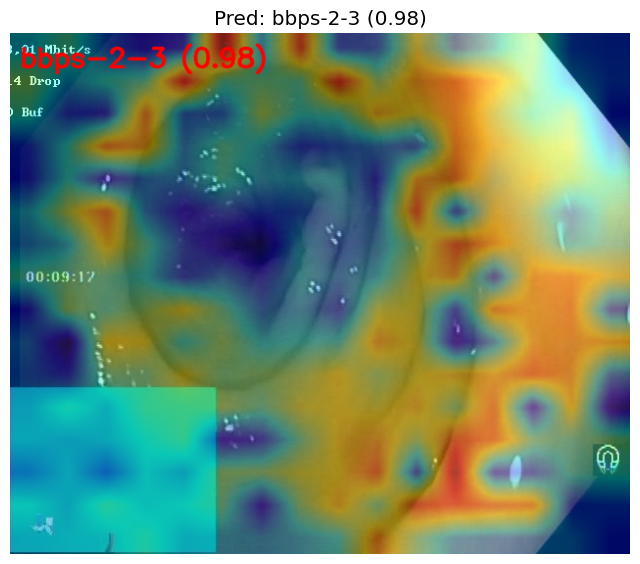

In [187]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import transforms

# ---------------- CONFIG ----------------
WEIGHTS = "/kaggle/working/Transfer_learned_final.pth"
IMAGE_PATH = "/kaggle/working/hk23_flat/bbps-2-3/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_quality-of-mucosal-views_bbps-2-3_0051f048-7d3c-4e25-9f26-59ae0be54270.jpg"
OUT_PATH = "/kaggle/working/inference_single.jpg"
IMAGE_SIZE = 224

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_NAMES = [
    'barretts',
    'barretts-short-segment',
    'bbps-0-1',
    'bbps-2-3',
    'cecum',
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis-a',
    'esophagitis-b-d',
    'hemorrhoids',
    'ileum',
    'impacted-stool',
    'polyps',
    'pylorus',
    'retroflex-rectum',
    'retroflex-stomach',
    'ulcerative-colitis-grade-0-1',
    'ulcerative-colitis-grade-1',
    'ulcerative-colitis-grade-1-2',
    'ulcerative-colitis-grade-2',
    'ulcerative-colitis-grade-2-3',
    'ulcerative-colitis-grade-3',
    'z-line'
]

class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.activations = None
        self.gradients = None
        
        # Hook into the final norm layer (captures all tokens)
        target = self.model.backbone.norm
        target.register_forward_hook(self._forward_hook)
        target.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        # output: (B, N+1, C) - includes CLS + patches
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        # grad_output[0]: (B, N+1, C)
        self.gradients = grad_output[0]

    def generate(self):
        # Get patch activations (exclude CLS token)
        patch_acts = self.activations[:, 1:, :]  # (B, N, C)
        
        # Use CLS token gradient as channel weights
        # Gradient shape: (B, N+1, C), take CLS gradient: (B, C)
        cls_grad = self.gradients[:, 0, :]  # Gradient w.r.t. CLS token
        
        # Weight patches by CLS importance
        weights = cls_grad.unsqueeze(1)  # (B, 1, C)
        cam = (weights * patch_acts).sum(dim=2)  # (B, N)
        
        # Normalize
        cam = torch.relu(cam)
        cam_min = cam.min(dim=1, keepdim=True)[0]
        cam_max = cam.max(dim=1, keepdim=True)[0]
        cam = (cam - cam_min) / (cam_max + 1e-6)
        
        return cam


# ---------------- TRANSFORM ----------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ---------------- MODEL ----------------
class DinoClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torch.hub.load(
            "facebookresearch/dinov2",
            "dinov2_vits14",
            pretrained=False
        )
        self.head = nn.Linear(384, num_classes)

        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, x):
        out = self.backbone(x)

        if isinstance(out, dict):
            if "x_norm_clstoken" in out:
                feat = out["x_norm_clstoken"]
            elif "x_norm_patchtokens" in out:
                feat = out["x_norm_patchtokens"].mean(dim=1)
            else:
                raise RuntimeError("Unknown DINOv2 output format")
        elif out.dim() == 3:
            feat = out.mean(dim=1)
        elif out.dim() == 2:
            feat = out
        else:
            raise RuntimeError(f"Unexpected output shape: {out.shape}")

        return self.head(feat)

    @classmethod
    def load_from_checkpoint(cls, ckpt_path, num_classes):
        model = cls(num_classes)
        ckpt = torch.load(ckpt_path, map_location="cpu")

        model.backbone.load_state_dict(
            ckpt["backbone_state_dict"], strict=False
        )
        model.head.load_state_dict(
            ckpt["head_state_dict"], strict=True
        )
        return model

# ---------------- INFERENCE ----------------
if __name__ == "__main__":
    # Load model
    model = DinoClassifier.load_from_checkpoint(
        WEIGHTS, num_classes=len(CLASS_NAMES)
    ).to(DEVICE)
    model.eval()

    # Read image
    bgr = cv2.imread(IMAGE_PATH)
    if bgr is None:
        raise FileNotFoundError(IMAGE_PATH)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = transform(rgb).unsqueeze(0).to(DEVICE)
    x.requires_grad_(True)

    # Grad-CAM setup
    cam_extractor = ViTGradCAM(model)

    # Forward
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    pred_idx = logits.argmax(dim=1).item()

    # Backward (Grad-CAM)
    model.zero_grad()
    logits[0, pred_idx].backward()

    cam_tokens = cam_extractor.generate()  # (1, N)

    # Tokens → spatial map
    num_patches = cam_tokens.shape[1]
    grid_size = int(num_patches ** 0.5)

    cam_map = cam_tokens[0].reshape(grid_size, grid_size)
    cam_map = cam_map - cam_map.min()
    cam_map = cam_map / (cam_map.max() + 1e-8)  # normalize to [0,1]
    cam_map = cam_map.detach().cpu().numpy()

    cam_map = cv2.resize(cam_map, (IMAGE_SIZE, IMAGE_SIZE))

    # Overlay
    # Convert Grad-CAM to heatmap
    heatmap = np.uint8(255 * cam_map)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.resize(heatmap_color, (bgr.shape[1], bgr.shape[0]))  # match original image size
    
    # Overlay
    overlay = cv2.addWeighted(bgr, 0.6, heatmap_color, 0.4, 0)


    label = CLASS_NAMES[pred_idx]
    conf = float(probs[0, pred_idx])

    cv2.putText(
        overlay,
        f"{label} ({conf:.2f})",
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

    import matplotlib.pyplot as plt

    # Convert BGR → RGB for display
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    # Display inline
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_rgb)
    plt.axis('off')
    plt.title(f"Pred: {label} ({conf:.2f})")
    plt.show()



In [183]:
class ViTAttentionCAM:
    def __init__(self, model):
        self.model = model
        self.attentions = None
        
        # Hook the last attention layer
        target = model.backbone.blocks[-1].attn
        target.register_forward_hook(self._forward_hook)
    
    def _forward_hook(self, module, input, output):
        # output is tuple: (attn_output, attn_weights)
        # attn_weights shape: (B, num_heads, N+1, N+1)
        self.attentions = output[1]
    
    def generate(self):
        # Average over attention heads
        attn = self.attentions.mean(dim=1)  # (B, N+1, N+1)
        
        # Use CLS token attention to patches
        cls_attn = attn[:, 0, 1:]  # (B, N)
        
        # Reshape to spatial map
        grid_size = int(cls_attn.shape[1]**0.5)
        cam = cls_attn.reshape(-1, grid_size, grid_size)
        
        # Normalize
        cam_min = cam.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0]
        cam_max = cam.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]
        cam = (cam - cam_min) / (cam_max + 1e-6)
        
        return cam

# In inference:
# Remove x.requires_grad_(True) and backward() - no gradients needed!
 # (1, grid_size, grid_size)

In [185]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision import transforms

# ---------------- CONFIG ----------------
WEIGHTS = "/kaggle/working/Transfer_learned_final.pth"
IMAGE_PATH = "/kaggle/working/hk23_flat/polyps/_kaggle_working_hyper-kvasir-labeled-images_labeled-images_lower-gi-tract_pathological-findings_polyps_038d119f-85bf-4f42-897b-677eb1450b94.jpg"
OUT_PATH = "/kaggle/working/inference_single.jpg"
IMAGE_SIZE = 224

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_NAMES = [
    'barretts',
    'barretts-short-segment',
    'bbps-0-1',
    'bbps-2-3',
    'cecum',
    'dyed-lifted-polyps',
    'dyed-resection-margins',
    'esophagitis-a',
    'esophagitis-b-d',
    'hemorrhoids',
    'ileum',
    'impacted-stool',
    'polyps',
    'pylorus',
    'retroflex-rectum',
    'retroflex-stomach',
    'ulcerative-colitis-grade-0-1',
    'ulcerative-colitis-grade-1',
    'ulcerative-colitis-grade-1-2',
    'ulcerative-colitis-grade-2',
    'ulcerative-colitis-grade-2-3',
    'ulcerative-colitis-grade-3',
    'z-line'
]




# ---------------- TRANSFORM ----------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# ---------------- MODEL ----------------
class DinoClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torch.hub.load(
            "facebookresearch/dinov2",
            "dinov2_vits14",
            pretrained=False
        )
        self.head = nn.Linear(384, num_classes)

        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, x):
        out = self.backbone(x)

        if isinstance(out, dict):
            if "x_norm_clstoken" in out:
                feat = out["x_norm_clstoken"]
            elif "x_norm_patchtokens" in out:
                feat = out["x_norm_patchtokens"].mean(dim=1)
            else:
                raise RuntimeError("Unknown DINOv2 output format")
        elif out.dim() == 3:
            feat = out.mean(dim=1)
        elif out.dim() == 2:
            feat = out
        else:
            raise RuntimeError(f"Unexpected output shape: {out.shape}")

        return self.head(feat)

    @classmethod
    def load_from_checkpoint(cls, ckpt_path, num_classes):
        model = cls(num_classes)
        ckpt = torch.load(ckpt_path, map_location="cpu")

        model.backbone.load_state_dict(
            ckpt["backbone_state_dict"], strict=False
        )
        model.head.load_state_dict(
            ckpt["head_state_dict"], strict=True
        )
        return model

# ---------------- INFERENCE ----------------
if __name__ == "__main__":
    # Load model
    model = DinoClassifier.load_from_checkpoint(
        WEIGHTS, num_classes=len(CLASS_NAMES)
    ).to(DEVICE)
    model.eval()

    # Read image
    bgr = cv2.imread(IMAGE_PATH)
    if bgr is None:
        raise FileNotFoundError(IMAGE_PATH)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = transform(rgb).unsqueeze(0).to(DEVICE)
    #x.requires_grad_(True)

    # Grad-CAM setup
    cam_extractor = ViTAttentionCAM(model)
    logits = model(x)  # Standard forward pass
    probs = F.softmax(logits, dim=1)
    pred_idx = logits.argmax(dim=1).item()
    
    # Generate attention map
    cam_tokens = cam_extractor.generate()   # (1, N)

    # Tokens → spatial map
    num_patches = cam_tokens.shape[1]
    grid_size = int(num_patches ** 0.5)

    cam_map = cam_tokens[0].reshape(grid_size, grid_size)
    cam_map = cam_map - cam_map.min()
    cam_map = cam_map / (cam_map.max() + 1e-8)  # normalize to [0,1]
    cam_map = cam_map.detach().cpu().numpy()

    cam_map = cv2.resize(cam_map, (IMAGE_SIZE, IMAGE_SIZE))

    # Overlay
    # Convert Grad-CAM to heatmap
    heatmap = np.uint8(255 * cam_map)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_color = cv2.resize(heatmap_color, (bgr.shape[1], bgr.shape[0]))  # match original image size
    
    # Overlay
    overlay = cv2.addWeighted(bgr, 0.6, heatmap_color, 0.4, 0)


    label = CLASS_NAMES[pred_idx]
    conf = float(probs[0, pred_idx])

    cv2.putText(
        overlay,
        f"{label} ({conf:.2f})",
        (10, 35),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (0, 0, 255),
        2,
        cv2.LINE_AA,
    )

    import matplotlib.pyplot as plt

    # Convert BGR → RGB for display
    overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    
    # Display inline
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_rgb)
    plt.axis('off')
    plt.title(f"Pred: {label} ({conf:.2f})")
    plt.show()



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [173]:
print(model.backbone)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

NameError: name 'self' is not defined

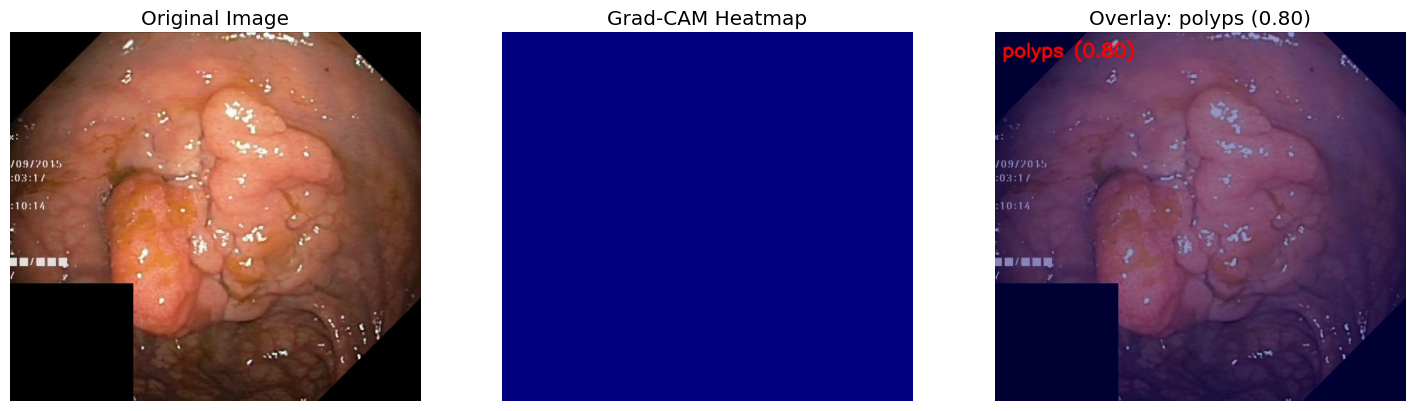

In [171]:
import matplotlib.pyplot as plt

# Convert BGR → RGB for display
original_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
heatmap_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Plot three images side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_rgb)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_rgb)
plt.axis('off')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(overlay_rgb)
plt.axis('off')
plt.title(f"Overlay: {label} ({conf:.2f})")

plt.show()


## Unet

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)  # logits


model = UNet().to(device)
model.load_state_dict(torch.load("unet_baseline_best_Final.pth", map_location=device))
model.eval()  # Set to evaluation mode

import matplotlib.pyplot as plt
import cv2

import cv2
import torch
import numpy as np

# Load and preprocess image
img_path = "transformed_output/images/0b556d02-f9ca-4270-b568-3200335c7d08.png"  # Change this to your image path
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320, 320))  # Resize to match training size

# Convert to tensor and normalize
img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0  # [3, H, W]
img = img.unsqueeze(0).to(device)  # Add batch dimension: [1, 3, H, W]


with torch.no_grad():
    output = model(img)
    mask_pred = (torch.sigmoid(output) > 0.5).float()

# Reload the original image for visualization (not normalized)
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
orig_img = cv2.resize(orig_img, (320, 320))

# Get mask as numpy array
mask_np = mask_pred.squeeze().cpu().numpy().astype(np.uint8)  # shape [H, W], values 0 or 1

# Find contours (boundaries) in the mask
contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
overlay = orig_img.copy()
cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)  # Blue boundary

# Show results
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Predicted Mask")
plt.imshow(mask_np, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay with Boundary")
plt.imshow(overlay)
plt.axis("off")

plt.show()

Using device: cuda


DeferredCudaCallError: CUDA call failed lazily at initialization with error: module 'torch' has no attribute 'version'

CUDA call was originally invoked at:

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
    self._run_once()
  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once
    handle._run()
  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
    reply_content = await reply_content
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
    res = shell.run_cell(
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
    result = self._run_cell(
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_55/1405654287.py", line 1, in <cell line: 0>
    import torch
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/torch/__init__.py", line 2088, in <module>
    _C._initExtension(_manager_path())
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1331, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 935, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 999, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py", line 356, in <module>
    _lazy_call(_check_capability)
  File "/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py", line 353, in _lazy_call
    _queued_calls.append((callable, traceback.format_stack()))


Testing

In [ ]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

# ---------------- CONFIG ----------------
WEIGHTS = "Transfer_learned_final.pth"
UNET_WEIGHTS = "unet_baseline_best_Final.pth"

IMAGE_SIZE = 224
UNET_IMAGE_SIZE = 320
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_NAMES = [
    'barretts','barretts-short-segment','bbps-0-1','bbps-2-3','cecum',
    'dyed-lifted-polyps','dyed-resection-margins','esophagitis-a',
    'esophagitis-b-d','hemorrhoids','ileum','impacted-stool','polyps',
    'pylorus','retroflex-rectum','retroflex-stomach',
    'ulcerative-colitis-grade-0-1','ulcerative-colitis-grade-1',
    'ulcerative-colitis-grade-1-2','ulcerative-colitis-grade-2',
    'ulcerative-colitis-grade-2-3','ulcerative-colitis-grade-3','z-line'
]

POLYP_IDX = CLASS_NAMES.index("polyps")

# ---------------- TRANSFORMS ----------------
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ---------------- MODELS ----------------
class DinoClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = torch.hub.load(
            "facebookresearch/dinov2", "dinov2_vits14", pretrained=False
        )
        self.head = nn.Linear(384, num_classes)

    def forward(self, x):
        out = self.backbone(x)
        if isinstance(out, dict):
            feat = out.get("x_norm_clstoken", out["x_norm_patchtokens"].mean(1))
        elif out.dim() == 3:
            feat = out.mean(1)
        else:
            feat = out
        return self.head(feat)

    @classmethod
    def load_from_checkpoint(cls, ckpt, num_classes):
        model = cls(num_classes)
        ckpt = torch.load(ckpt, map_location="cpu")
        model.backbone.load_state_dict(ckpt["backbone_state_dict"], strict=False)
        model.head.load_state_dict(ckpt["head_state_dict"])
        return model


class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = DoubleConv(3,64)
        self.enc2 = DoubleConv(64,128)
        self.enc3 = DoubleConv(128,256)
        self.enc4 = DoubleConv(256,512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512,1024)
        self.up4 = nn.ConvTranspose2d(1024,512,2,2)
        self.dec4 = DoubleConv(1024,512)
        self.up3 = nn.ConvTranspose2d(512,256,2,2)
        self.dec3 = DoubleConv(512,256)
        self.up2 = nn.ConvTranspose2d(256,128,2,2)
        self.dec2 = DoubleConv(256,128)
        self.up1 = nn.ConvTranspose2d(128,64,2,2)
        self.dec1 = DoubleConv(128,64)
        self.final = nn.Conv2d(64,1,1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4],1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3],1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2],1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1],1))
        return self.final(d1)

# ---------------- SEG METRICS ----------------
def dice(pred, gt):
    inter = (pred * gt).sum()
    return (2 * inter) / (pred.sum() + gt.sum() + 1e-8)

def iou(pred, gt):
    inter = (pred & gt).sum()
    union = (pred | gt).sum()
    return inter / (union + 1e-8)

# ---------------- EVALUATION ----------------
def evaluate(polyp_dir, mask_dir=None):
    clf = DinoClassifier.load_from_checkpoint(
        WEIGHTS, len(CLASS_NAMES)
    ).to(DEVICE)
    clf.eval()

    unet = UNet().to(DEVICE)
    unet.load_state_dict(torch.load(UNET_WEIGHTS, map_location=DEVICE))
    unet.eval()

    y_true = []
    y_pred = []
    dice_scores = []
    iou_scores = []

    for img_name in os.listdir(polyp_dir):
        img_path = os.path.join(polyp_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        x = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            logits = clf(x)
            probs = F.softmax(logits,1)
            pred_idx = logits.argmax(1).item()

        # binary labels: polyp = 1
        y_true.append(1)
        y_pred.append(1 if pred_idx == POLYP_IDX else 0)

        # segmentation
        if mask_dir:
            mask_path = os.path.join(mask_dir, img_name)
            if os.path.exists(mask_path):
                gt = cv2.imread(mask_path,0)
                gt = cv2.resize(gt,(UNET_IMAGE_SIZE,UNET_IMAGE_SIZE))
                gt = (gt>0).astype(np.uint8)

                img_u = cv2.resize(img,(UNET_IMAGE_SIZE,UNET_IMAGE_SIZE))
                img_u = torch.from_numpy(img_u).permute(2,0,1).float()/255.
                img_u = img_u.unsqueeze(0).to(DEVICE)

                with torch.no_grad():
                    pred = torch.sigmoid(unet(img_u))>0.5
                pred = pred.squeeze().cpu().numpy().astype(np.uint8)

                dice_scores.append(dice(pred,gt))
                iou_scores.append(iou(pred,gt))

    # ---------------- RESULTS ----------------
    print("\n=== CLASSIFICATION (POLYP DETECTION) ===")
    print(f"Accuracy  : {accuracy_score(y_true,y_pred):.4f}")
    print(f"Precision : {precision_score(y_true,y_pred):.4f}")
    print(f"Recall    : {recall_score(y_true,y_pred):.4f}  <-- sensitivity")
    print(f"F1-score  : {f1_score(y_true,y_pred):.4f}")

    fnr = 1 - recall_score(y_true,y_pred)
    print(f"False Negative Rate: {fnr:.4f}")

    if dice_scores:
        print("\n=== SEGMENTATION (POLYPS) ===")
        print(f"Mean Dice: {np.mean(dice_scores):.4f}")
        print(f"Mean IoU : {np.mean(iou_scores):.4f}")

# ---------------- MAIN ----------------
if __name__ == "__main__":
    evaluate(
        polyp_dir="polyp_images",
        mask_dir="polyp_masks"  # optional
    )
